In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pysta
import stc

import os

%load_ext autoreload
%autoreload 2

## load STA results

In [2]:
def load_sta_stat(dataset_name, folder_name="data", tap = 8):     
#     stim, spike_train, info = pysta.load_data(dataset_name, folder_name)

    folder_name = "{}_tap{}_sta".format(dataset_name, tap)
    sta_stat = pd.read_csv(os.path.join(folder_name, "stat_more.csv"))

    # subtract center from min,max
    sta_stat["min"] -= 0.5
    sta_stat["max"] -= 0.5

    sta_stat["peak_diff"] = sta_stat["max"] - sta_stat["min"] 

    # calc polarity
    pos = np.abs(sta_stat["max"])
    neg = np.abs(sta_stat["min"])

    #sta_result["polarity"] = (pos - neg) / np.sqrt(pos) / np.sqrt(neg)
    # sta_result["polarity"] = (pos - neg) / np.minimum(pos, neg)
    sta_stat["polarity"] = np.maximum(pos, neg) / np.minimum(pos, neg) * np.sign(pos-neg)

    # calc d_prime
    sta_stat["PSNR"] = (sta_stat["max"] - sta_stat["min"]) / sta_stat["sigma"]


    return sta_stat
    
sta_stat1 = load_sta_stat("20180618")
sta_stat1["dataset"] = "20180618"
sta_stat2 = load_sta_stat("20180621")
sta_stat2["dataset"] = "20180621"
sta_stat3 = load_sta_stat("20180626")
sta_stat3["dataset"] = "20180626"
# sta_stat4 = load_sta_stat("20180828")
# sta_stat4["dataset"] = "20180828"

# combine all patches 
# sta_stat = pd.concat([sta_stat1, sta_stat2, sta_stat3, sta_stat4])
sta_stat = pd.concat([sta_stat1, sta_stat2, sta_stat3])

print("total = ", len(sta_stat))
print(sta_stat["cell_type"].value_counts())
print(sta_stat["cell_type"].value_counts() / len(sta_stat))

total =  389
OFF        169
unknown    129
ON          91
Name: cell_type, dtype: int64
OFF        0.434447
unknown    0.331620
ON         0.233933
Name: cell_type, dtype: float64


In [3]:
sta_stat

channel_name  num_samples  num_spikes       max  max_time_bin       min  \
0            12a         1332        1978 -0.320526             4 -0.790192   
1            12b          889        1228 -0.313518             5 -0.592020   
2            12c           58          59 -0.322034             3 -0.745763   
3            13a          722         963 -0.390447             3 -0.760125   
4            13b          383         415 -0.253012             5 -0.828916   
..           ...          ...         ...       ...           ...       ...   
151          86c          526         705 -0.296454             5 -0.573050   
152          86d          149         151 -0.271523             5 -0.675497   
153          87a         3872        9120 -0.283882             4 -0.886513   
154          87b         3512        3797 -0.255201             5 -0.576508   
155          87c          535         595 -0.408403             3 -0.678992   

     min_time_bin     sigma  peak_diff  polarity       PSNR cell_type  \
0               5  0.038540   0.469666 -2.465300  12.186541       OFF   
1               4  0.029235   0.278502 -1.888312   9.526389        ON   
2               5  0.068445   0.423729 -2.315789   6.190784   unknown   
3               5  0.033203   0.369678 -1.946809  11.134041       OFF   
4               4  0.034440   0.575904 -3.276190  16.721866        ON   
..            ...       ...        ...       ...        ...       ...   
151             4  0.027016   0.276596 -1.933014  10.238226        ON   
152             3  0.046548   0.403974 -2.487805   8.678597        ON   
153             5  0.027801   0.602632 -3.122827  21.676952       OFF   
154             3  0.019283   0.321306 -2.259030  16.662341        ON   
155             5  0.026295   0.270588 -1.662551  10.290554       OFF   

      dataset  
0    20180618  
1    20180618  
2    20180618  
3    20180618  
4    20180618  
..        ...  
151  20180626  
152  20180626  
153  20180626  
154  20180626  
155  20180626  

[389 rows x 13 columns]

In [4]:
x_data = np.log10(sta_stat["num_spikes"])
y_data = np.log10(sta_stat['sigma']**2)

# correlation coeff
rho = np.corrcoef(x_data, y_data)[0,1]
print(rho)

-0.8465567506146641


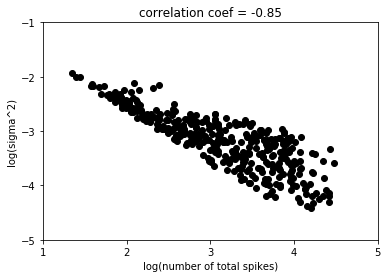

In [5]:
plt.scatter(x_data, y_data, marker='o', color='k')
# plt.xlabel('log(number of samples)')
plt.xlabel('log(number of total spikes)')
plt.ylabel('log(sigma^2)')

plt.title('correlation coef = {:.2f}'.format(rho))

plt.xlim([1, 5])
plt.xticks([1, 2, 3, 4, 5])
plt.ylim([-5, -1])
plt.yticks([-5, -4, -3, -2, -1])

# ax.set_xticklabels(["10^1","10^2","10^3","10^4","10^5"])

plt.savefig("figure/combined_n_vs_sig.pdf")
plt.savefig("figure/combined_n_vs_sig.png")

[-0.59693156 -1.31231239]
[[ 0.00036403 -0.00112758]
 [-0.00112758  0.0036868 ]]


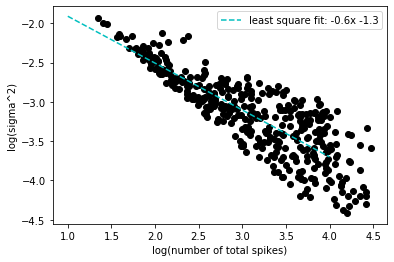

In [6]:
# fit to ax + b
# plt.figure(figsize=(8,6))
plt.scatter(x_data, y_data, marker='o', color='k')
# plt.xlabel('log(number of samples)')
plt.xlabel('log(number of total spikes)')
plt.ylabel('log(sigma^2)')

from scipy import optimize

def fit_func(x, a, b):
    return a * x + b

params, params_covariance = optimize.curve_fit(fit_func, x_data, y_data,
                                               p0=[-1, 0])

# def fit_func(x, b):
#     return -1 * x + b
# params, params_covariance = optimize.curve_fit(fit_func, x_data, y_data,
#                                                p0=[0])
print(params)
print(params_covariance)

x = np.linspace(1,4, 40)
plt.plot(x, fit_func(x, *params), 'c--', label='least square fit: {:.1f}x {:.1f}'.format(*params))
# plt.plot(x, fit_func(x, *params), 'k--', label='least square fit: -x {:.1f}'.format(*params))

plt.legend()

plt.savefig("figure/combined_n_vs_sig_fit.pdf")
plt.savefig("figure/combined_n_vs_sig_fit.png")

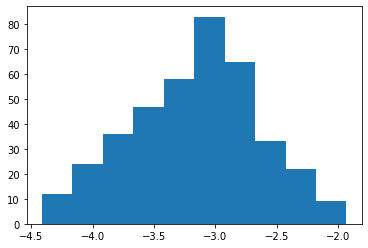

In [7]:
# select x by quantizing sigma and take minimum of x
# y_bins = np.linspace(-2.3, -0.8, 30)
# plt.hist(y_data, y_bins)
y_bins = np.linspace(-4.5, -1.5, 30)
plt.hist(y_data)

# fit selected samples to a x + b
x_selected = list()
y_selected = list()
idx_selected = list()

for i in range(len(y_bins)-1):
    idx = np.logical_and(y_data >= y_bins[i], y_data < y_bins[i+1])
    cnt = np.sum(idx)
    
    if cnt >0:
        xs = np.array(x_data[idx])
        ys = np.array(y_data[idx])

        # take min of x
        min_x = np.min(xs)        
        arg_min_x = np.argmin(xs)
        
        x_selected.append(min_x)
        y_selected.append(ys[arg_min_x])        
#         print(np.where(idx)[0], arg_min_x)
        idx_selected.append(np.where(idx)[0][arg_min_x])

x_selected = np.array(x_selected)
y_selected = np.array(y_selected)

-0.9852803733493424


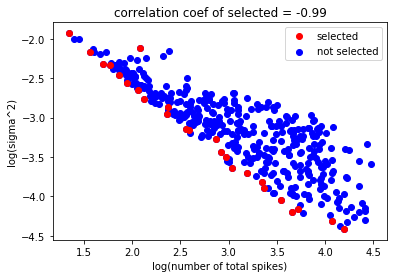

In [8]:
# cross correlation
rho_selected = np.corrcoef(x_selected, y_selected)[0,1]
print(rho_selected)

plt.scatter(x_data, y_data, color='b', label='not selected')
plt.plot(x_selected, y_selected, 'ro', label='selected')
plt.legend()

plt.xlabel('log(number of total spikes)')
# plt.xlabel('log(number of samples)')
plt.ylabel('log(sigma^2)')

plt.title('correlation coef of selected = {:.2f}'.format(rho_selected))

plt.savefig("figure/combined_n_vs_sig_selected.pdf")
plt.savefig("figure/combined_n_vs_sig_selected.png")

[-0.91988017 -0.71817452]
[[ 0.00110747 -0.00297866]
 [-0.00297866  0.00871236]]


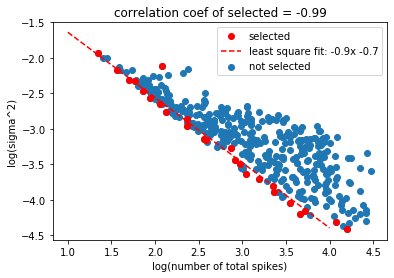

In [9]:
# fit selected samples to ax+b
def fit_func(x, a, b):
    return a * x + b

params, params_covariance = optimize.curve_fit(fit_func, x_selected, y_selected,
                                               p0=[-1, 0])
# def fit_func(x, b):
#     return - x + b

# params, params_covariance = optimize.curve_fit(fit_func, x_selected, y_selected,
#                                                p0=[0])

print(params)
print(params_covariance)


# plt.figure(figsize=(8,6))
plt.scatter(x_data, y_data, label='not selected')
plt.plot(x_selected, y_selected, 'ro', label='selected')

x = np.linspace(1,4, 40)
plt.plot(x, fit_func(x, *params), 'r--', label='least square fit: {:.1f}x {:.1f}'.format(*params))

plt.xlabel('log(number of total spikes)')
# plt.xlabel('log(number of samples)')
plt.ylabel('log(sigma^2)')
plt.legend()


plt.title('correlation coef of selected = {:.2f}'.format(rho_selected))

plt.savefig("figure/combined_n_vs_sig_fit_selected.pdf")
plt.savefig("figure/combined_n_vs_sig_fit_selected.png")

-0.4151300358392151


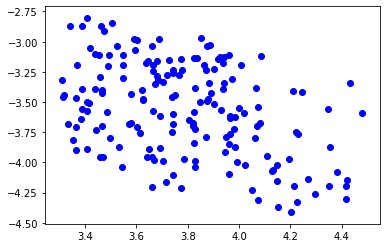

In [10]:
# plot for enough samples

spike_per_dim = 4 # hyper parameter that I get to choose

idx_enough_samples = sta_stat["num_spikes"] >= 512*spike_per_dim
#idx_enough_samples = sta_stat["num_samples"] >= 512*spike_per_dim
x_data = np.log10(sta_stat.loc[idx_enough_samples,"num_spikes"])
y_data = np.log10(sta_stat.loc[idx_enough_samples,'sigma']**2)

# correlation coeff
rho = np.corrcoef(x_data, y_data)[0,1]
print(rho)

plt.scatter(x_data, y_data, color='b', label='not selected')


In [11]:
# helper function to plot histograms of a column by cell_type
def plot_histogram_by_cell_type(clusters, col_name, alpha=0.5, separate_figure=False, XLIM=None):
    if separate_figure:
        plt.figure()
        
        
    idx_on = clusters["cell_type"] == "OFF"
    clusters.loc[idx_on, col_name].hist(alpha=alpha, color='b', label='OFF')
    
    if XLIM is not None:
        plt.xlim(XLIM)

    if separate_figure:
        plt.xlabel(col_name + " (OFF)")
        plt.ylabel("count")
        plt.show()    
    
    if separate_figure:
        plt.figure()
        
        
    idx_on = clusters["cell_type"] == "ON"
    clusters.loc[idx_on, col_name].hist(alpha=alpha, color='r', label='ON')
    
    if XLIM is not None:
        plt.xlim(XLIM)
    
    if separate_figure:
        plt.xlabel(col_name + " (ON)")
        plt.ylabel("count")
        plt.show()
        
    if separate_figure:
        plt.figure()

        
    idx_unknown = clusters["cell_type"] == "unknown"
    clusters.loc[idx_unknown, col_name].hist(alpha=alpha, color='k', label='unknown')
    
    if XLIM is not None:
        plt.xlim(XLIM)

    if separate_figure:
        plt.xlabel(col_name + " (unknown)")
        plt.ylabel("count")
        plt.show()
    else: # plot once
        plt.xlabel(col_name)
        plt.ylabel("count")
        plt.legend()

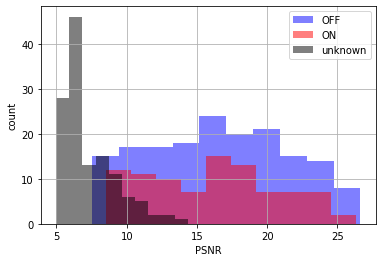

In [12]:
plot_histogram_by_cell_type(sta_stat, "PSNR", alpha=0.5)

plt.savefig("figure/combined_PSNR.pdf")
plt.savefig("figure/combined_PSNR.png")

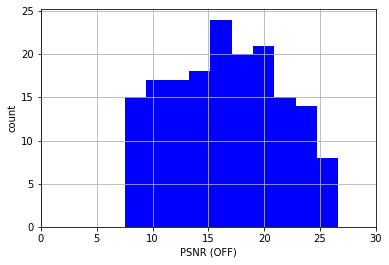

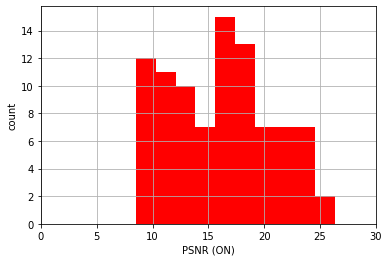

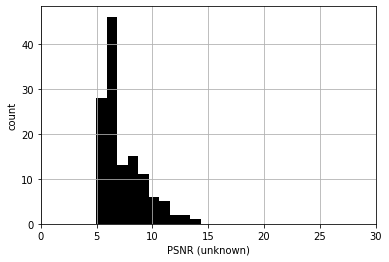

8.504175017619025
7.529598911088799


In [13]:
plot_histogram_by_cell_type(sta_stat, "PSNR", alpha=1, separate_figure=True, XLIM=[0,30])

# print min values by types
print(np.min(sta_stat.loc[sta_stat["cell_type"]=="ON","PSNR"]))
print(np.min(sta_stat.loc[sta_stat["cell_type"]=="OFF","PSNR"]))



# plt.savefig("figure/combined_PSNR_each.pdf")
# plt.savefig("figure/combined_PSNR_each.png")

Text(0, 0.5, 'number of spikes')

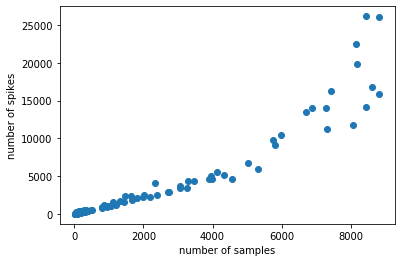

In [14]:
idx_unknown = sta_stat["cell_type"]=="unknown"
sta_stat_unknown = sta_stat.loc[idx_unknown]

plt.scatter(sta_stat_unknown["num_samples"], sta_stat_unknown["num_spikes"])
plt.xlabel('number of samples')
plt.ylabel('number of spikes')

## load clustering results

In [15]:
def load_clustering(dataset_name, tap=8, dim=3):
    folder_name = "{}_tap{}_cov_classic_cluster_dim{}".format(dataset_name, tap, dim)
#     filename = os.path.join(folder_name, "clusters_combined.csv")
    filename = os.path.join(folder_name, "clusters.csv")    

    return pd.read_csv(filename)

dim = 2
# dim = 3

cluster1 = load_clustering("20180618", dim=dim)
cluster1["dataset"] = "20180618"
cluster2 = load_clustering("20180621", dim=dim)
cluster2["dataset"] = "20180621"
cluster3 = load_clustering("20180626", dim=dim)
cluster3["dataset"] = "20180626"
# cluster4 = load_clustering("20180828")
# cluster4["dataset"] = "20180828"


# combine all patches 
# cluster = pd.concat([cluster1, cluster2, cluster3, cluster4])
cluster = pd.concat([cluster1, cluster2, cluster3])

print("total = ", len(cluster))
print(cluster["cell_type"].value_counts())
print(cluster["cell_type"].value_counts() / len(sta_stat))

total =  389
OFF        169
unknown    129
ON          91
Name: cell_type, dtype: int64
OFF        0.434447
unknown    0.331620
ON         0.233933
Name: cell_type, dtype: float64


In [16]:
# # sanity check
# plt.scatter(sta_stat["PSNR"], cluster["PSNR"])

In [17]:
# # merge num_sikes
# cluster = cluster.merge(sta_stat[["dataset","channel_name", "num_spikes"]], on=["dataset","channel_name"])

In [18]:
# with enough samples
spike_per_dim = 4 # hyper parameter that I get to choose

idx_enough_samples = cluster["num_spikes"]>512*spike_per_dim
cluster_with_enough_samples = cluster.loc[idx_enough_samples]

print("total = ", len(cluster_with_enough_samples))
print(cluster_with_enough_samples["cell_type"].value_counts())
print(cluster_with_enough_samples["cell_type"].value_counts() / len(sta_stat))


total =  171
OFF        84
ON         48
unknown    39
Name: cell_type, dtype: int64
OFF        0.215938
ON         0.123393
unknown    0.100257
Name: cell_type, dtype: float64


In [19]:
cluster_with_enough_samples

channel_name  num_spikes cell_type       PSNR      eig1      eig2  \
7            14a        5973        ON  25.775064  0.620785  0.571746   
9            17a        5929   unknown   8.452868  0.436700  0.434049   
10           17b        2553   unknown   8.515376  0.570595  0.559954   
21           23a       12115       OFF  22.562123  0.604328  0.517577   
22           23b        4619        ON  11.990694  0.700543  0.608037   
..           ...         ...       ...        ...       ...       ...   
142          82b        2842       OFF  15.507029  0.798825  0.714066   
144          83a       17646       OFF  20.351671  0.493440  0.462766   
149          86a        3186        ON  19.576154  0.952703  0.766365   
153          87a        9120       OFF  21.676952  0.590420  0.517161   
154          87b        3797        ON  16.662341  0.487358  0.482080   

         eig3  converged      PSNR1      PSNR2   weight1   weight2  \
7    0.562778       True  25.876759  16.480697  0.651436  0.348564   
9    0.430598       True   6.245005   5.991843  0.503208  0.496792   
10   0.552507       True   5.244271   5.530482  0.491501  0.508499   
21   0.516272       True  20.525984  11.345342  0.602712  0.397288   
22   0.595794       True  17.952531  17.924992  0.526547  0.473453   
..        ...        ...        ...        ...       ...       ...   
142  0.700224       True  14.167554   5.978526  0.597454  0.402546   
144  0.458015       True   6.760831  17.626832  0.493059  0.506941   
149  0.749286       True   9.892318  19.695189  0.276750  0.723250   
153  0.512286       True  19.050973  14.196890  0.601526  0.398474   
154  0.475510       True   9.349949  12.006460  0.464024  0.535976   

     inner_product   dataset  
7        -0.222871  20180618  
9        -0.251448  20180618  
10       -0.268908  20180618  
21       -0.002663  20180618  
22       -0.357312  20180618  
..             ...       ...  
142      -0.185087  20180626  
144      -0.096472  20180626  
149       0.588351  20180626  
153       0.056410  20180626  
154      -0.129389  20180626  

[171 rows x 14 columns]

No handles with labels found to put in legend.


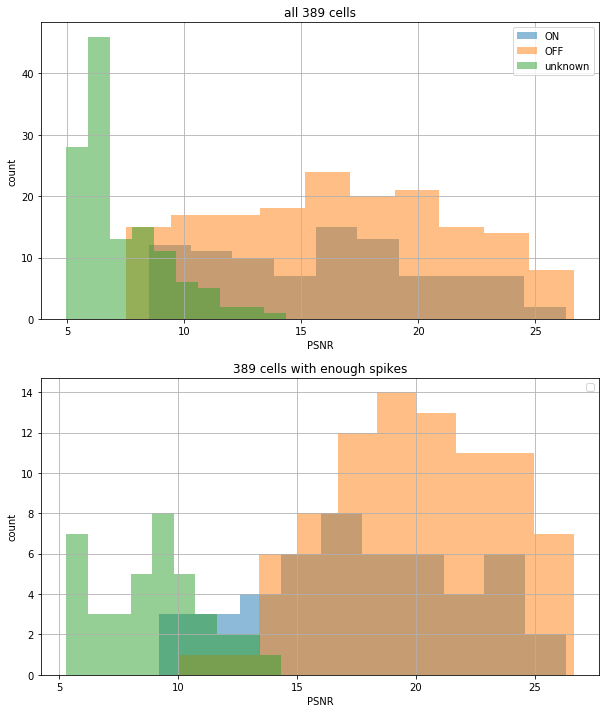

In [20]:
col_name = "PSNR"
plt.figure(figsize=(10,12))
plt.subplot(211)
pysta.plot_histogram_by_cell_type(cluster, col_name)
plt.title("all {} cells".format(len(cluster)))
plt.subplot(212)
pysta.plot_histogram_by_cell_type(cluster_with_enough_samples, col_name)
plt.title("{} cells with enough spikes".format(len(cluster)))

plt.legend()

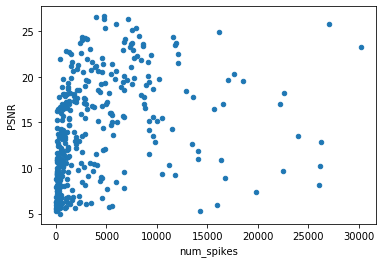

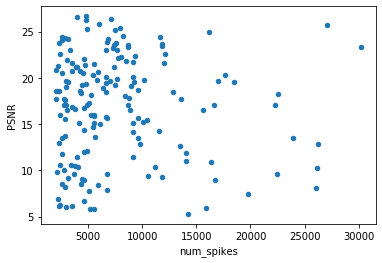

In [21]:
cluster.plot.scatter("num_spikes", "PSNR")
cluster_with_enough_samples.plot.scatter("num_spikes", "PSNR")

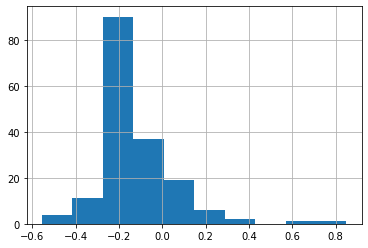

In [22]:
cluster_with_enough_samples["inner_product"].hist()

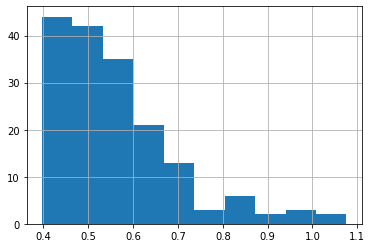

In [23]:
cluster_with_enough_samples["eig1"].hist()

In [24]:
idx_on = cluster_with_enough_samples["cell_type"] == "ON"
idx_off = cluster_with_enough_samples["cell_type"] == "OFF"
idx_unknown = cluster_with_enough_samples["cell_type"] == "unknown"

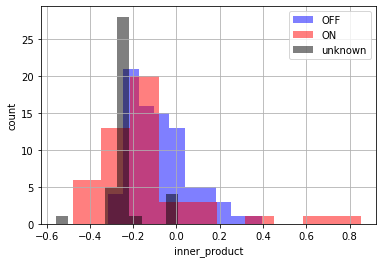

In [25]:
plot_histogram_by_cell_type(cluster_with_enough_samples, "inner_product")
plt.savefig('figure/combined_cluster_dim{}_spd{}_inner_product_hist.pdf'.format(dim,spike_per_dim))
plt.savefig('figure/combined_cluster_dim{}_spd{}_inner_product_hist.png'.format(dim,spike_per_dim))

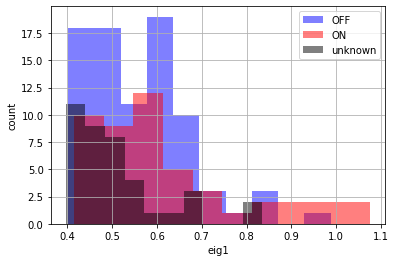

In [26]:
plot_histogram_by_cell_type(cluster_with_enough_samples, "eig1")

Text(0, 0.5, '1st eigenvalue')

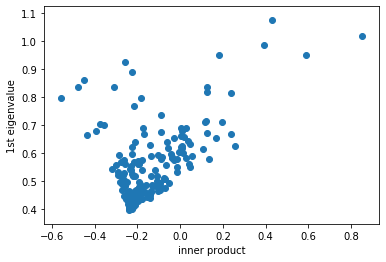

In [27]:
plt.scatter(cluster_with_enough_samples["inner_product"], cluster_with_enough_samples["eig1"])
plt.xlabel('inner product')
plt.ylabel('1st eigenvalue')

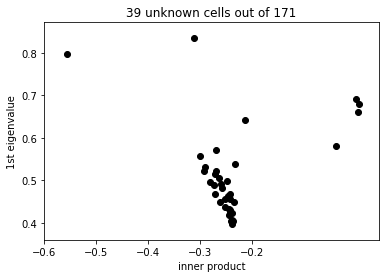

In [28]:
plt.scatter(cluster_with_enough_samples.loc[idx_unknown,"inner_product"], cluster_with_enough_samples.loc[idx_unknown,"eig1"], c="k")
plt.xlabel('inner product')
plt.ylabel('1st eigenvalue')

plt.xticks([-0.6, -0.5, -0.4, -0.3, -0.2])
plt.title ("{} unknown cells out of {}".format(np.sum(idx_unknown),len(cluster_with_enough_samples)))
plt.savefig('figure/combined_cluster_dim{}_spd{}_inner_product_vs_eig1_unknown.pdf'.format(dim,spike_per_dim))
plt.savefig('figure/combined_cluster_dim{}_spd{}_inner_product_vs_eig1_unknown.png'.format(dim,spike_per_dim))

171


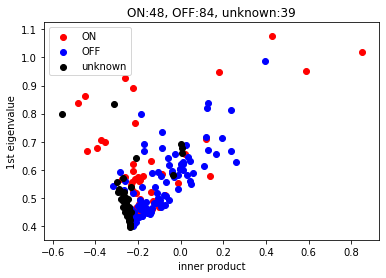

In [29]:
def plot_inner_product_vs_eig1(cluster_with_enough_samples):
    idx_on = cluster_with_enough_samples["cell_type"] == "ON"
    idx_off = cluster_with_enough_samples["cell_type"] == "OFF"
    idx_unknown = cluster_with_enough_samples["cell_type"] == "unknown"

    plt.scatter(cluster_with_enough_samples.loc[idx_on,"inner_product"], cluster_with_enough_samples.loc[idx_on,"eig1"], c="r")
    plt.scatter(cluster_with_enough_samples.loc[idx_off,"inner_product"], cluster_with_enough_samples.loc[idx_off,"eig1"], c="b")
    plt.scatter(cluster_with_enough_samples.loc[idx_unknown,"inner_product"], cluster_with_enough_samples.loc[idx_unknown,"eig1"], c="k")
    plt.xlabel('inner product')
    plt.ylabel('1st eigenvalue')

    plt.title ("ON:{}, OFF:{}, unknown:{}".format(np.sum(idx_on),np.sum(idx_off),np.sum(idx_unknown)))

    plt.legend(["ON", "OFF", "unknown"])
    

print(len(cluster_with_enough_samples))
plot_inner_product_vs_eig1(cluster_with_enough_samples)

plt.savefig('figure/combined_cluster_dim{}_spd{}_inner_product_vs_eig1.pdf'.format(dim,spike_per_dim))
plt.savefig('figure/combined_cluster_dim{}_spd{}_inner_product_vs_eig1.png'.format(dim,spike_per_dim))

In [30]:
cluster_with_enough_samples.sort_values('inner_product').head(30)#.sort_values("dataset")
# cluster_with_enough_samples.sort_values(['dataset','inner_product'])

channel_name  num_spikes cell_type       PSNR      eig1      eig2  \
64           36c        4098   unknown  10.318830  0.798256  0.620102   
24           22a        2860        ON  17.556724  0.838246  0.704459   
38           32b        3530        ON  16.838700  0.862429  0.749463   
44           35a        9638        ON  13.477084  0.665520  0.552200   
109          85b        4002        ON  11.494061  0.678136  0.597015   
43           34b        4208        ON  18.520772  0.706069  0.597161   
22           23b        4619        ON  11.990694  0.700543  0.608037   
67           37b        9568       OFF  18.715314  0.542621  0.476537   
25           22b        2413   unknown   6.267735  0.835159  0.782430   
65           46b        2306   unknown   6.176081  0.558057  0.554718   
104          56b        2961   unknown   6.055893  0.521560  0.518974   
104          77a        2879   unknown   8.146201  0.531850  0.520963   
86           46b        2762       OFF  10.083432  0.592556  0.580456   
64           46a        3505   unknown   6.157515  0.495557  0.494839   
57           42b        8472        ON  21.819161  0.567641  0.502737   
10           17c        5516   unknown   5.800503  0.489674  0.481081   
18           23b        4379   unknown   8.533363  0.514523  0.505090   
45           36a        5207   unknown   5.783477  0.468460  0.461560   
10           17b        2553   unknown   8.515376  0.570595  0.559954   
26           26c        6699        ON  20.090976  0.498963  0.470083   
75           54c        3407   unknown  10.567115  0.522441  0.521627   
71           53b        6622       OFF  19.471693  0.529478  0.499515   
122          71b        7557        ON  23.712959  0.575136  0.510658   
28           27b        5059   unknown   7.714152  0.505017  0.497758   
6            16a       22460   unknown   9.654894  0.448151  0.420615   
76           54d        2966        ON  19.675728  0.927184  0.759760   
109          62b        2308       OFF  12.982289  0.559727  0.550488   
100          72c        6703        ON   9.601153  0.490013  0.486040   
108          62a        4582   unknown   8.960171  0.491259  0.482335   
67           48b        4660   unknown  14.343462  0.482386  0.475528   

         eig3  converged      PSNR1      PSNR2   weight1   weight2  \
64   0.613533       True  18.892517  18.855896  0.523945  0.476055   
24   0.671715       True  18.716530  14.826105  0.647365  0.352635   
38   0.716215       True  17.935097  14.497685  0.648691  0.351309   
44   0.548982       True  25.869758  22.670575  0.553190  0.446810   
109  0.581718       True  15.845651  14.882373  0.515154  0.484846   
43   0.588002       True  21.502776  19.148252  0.566082  0.433918   
22   0.595794       True  17.952531  17.924992  0.526547  0.473453   
67   0.469468       True  20.868490  16.619655  0.544735  0.455265   
25   0.732217       True  12.855868  10.573821  0.379899  0.620101   
65   0.549498       True   6.037890   5.739434  0.483477  0.516523   
104  0.517117       True   6.931242   5.869391  0.504508  0.495492   
104  0.515625       True   5.655792   5.737066  0.472642  0.527358   
86   0.562291       True  12.554679   8.637957  0.503793  0.496207   
64   0.488377       True   5.597080   6.001722  0.493646  0.506354   
57   0.496190       True  22.195185  13.698065  0.543629  0.456371   
10   0.475638       True   5.709631   5.685947  0.499609  0.500391   
18   0.504289       True   6.896053   5.960878  0.494406  0.505594   
45   0.458992       True   6.665177   5.940820  0.497908  0.502092   
10   0.552507       True   5.244271   5.530482  0.491501  0.508499   
26   0.461593       True  19.797816  12.161479  0.533655  0.466345   
75   0.513524       True   6.718130   6.225924  0.489557  0.510443   
71   0.496398       True  18.382167  10.654929  0.557391  0.442609   
122  0.508055       True  25.088171  19.314276  0.541793  0.458207   
28   0.490758       True   7.365840   5.784147  0.503374  0.

## threshold by PSNRs & sort by inner product

In [31]:
PSNR_threshold = 8.5
idx_thresholded = (cluster_with_enough_samples["inner_product"] < 0) & (cluster_with_enough_samples["PSNR1"] > PSNR_threshold) & (cluster_with_enough_samples["PSNR2"] > PSNR_threshold)
cluster_thresholded = cluster_with_enough_samples.loc[idx_thresholded].sort_values('inner_product')

print(len(cluster_thresholded))
cluster_thresholded

63


channel_name  num_spikes cell_type       PSNR      eig1      eig2  \
64           36c        4098   unknown  10.318830  0.798256  0.620102   
24           22a        2860        ON  17.556724  0.838246  0.704459   
38           32b        3530        ON  16.838700  0.862429  0.749463   
44           35a        9638        ON  13.477084  0.665520  0.552200   
109          85b        4002        ON  11.494061  0.678136  0.597015   
..           ...         ...       ...        ...       ...       ...   
19           21a        3114       OFF  24.182765  0.655560  0.625129   
106          61a        8017       OFF  22.265948  0.531427  0.494167   
24           24b        4795       OFF  26.300102  0.580599  0.572773   
87           64b        8643       OFF  23.344654  0.602733  0.542088   
21           23a       12115       OFF  22.562123  0.604328  0.517577   

         eig3  converged      PSNR1      PSNR2   weight1   weight2  \
64   0.613533       True  18.892517  18.855896  0.523945  0.476055   
24   0.671715       True  18.716530  14.826105  0.647365  0.352635   
38   0.716215       True  17.935097  14.497685  0.648691  0.351309   
44   0.548982       True  25.869758  22.670575  0.553190  0.446810   
109  0.581718       True  15.845651  14.882373  0.515154  0.484846   
..        ...        ...        ...        ...       ...       ...   
19   0.608992       True  20.548731  13.089513  0.611807  0.388193   
106  0.482321       True  18.615127  13.401243  0.586128  0.413872   
24   0.567813       True  21.286261  15.186880  0.594581  0.405419   
87   0.536521       True  20.518699  13.344694  0.550941  0.449059   
21   0.516272       True  20.525984  11.345342  0.602712  0.397288   

     inner_product   dataset  
64       -0.555696  20180626  
24       -0.479533  20180626  
38       -0.450240  20180618  
44       -0.437553  20180618  
109      -0.394291  20180621  
..             ...       ...  
19       -0.028465  20180626  
106      -0.012712  20180626  
24       -0.012388  20180618  
87       -0.004678  20180618  
21       -0.002663  20180618  

[63 rows x 14 columns]

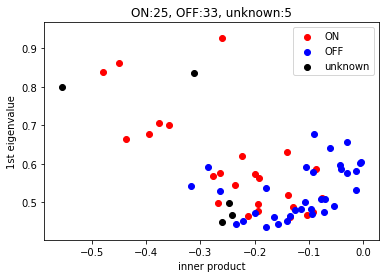

In [32]:
plot_inner_product_vs_eig1(cluster_thresholded)
# plt.savefig('figure/cluster_inner_product_vs_eig1_dim{}_spd{}.pdf'.format(dim,spike_per_dim))
# plt.savefig('figure/cluster_inner_product_vs_eig1_dim{}_spd{}.png'.format(dim,spike_per_dim))

28 20180626 36c unknown -0.5556963504206558 18.892516557831094 18.855895533334955
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_0_temporal.png
28 20180626 22a ON -0.4795333338556548 18.71652962287388 14.826105037089825
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_1_temporal.png
28 20180618 32b ON -0.4502400545599075 17.93509690561089 14.497685481659946
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_2_temporal.png
28 20180618 35a ON -0.437553088087474 25.869757681146517 22.67057515548843
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_3_temporal.png
28 20180621 85b ON -0.3942908140324295 15.845651433119675 14.882373073758574
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_4_temporal.png
28 20180618 34b ON -0.3758961443957734 21.50277558898307 19.148251997286067
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_5_temporal.png
28 20180618 23b ON -0.35731214766153363 17.952531437999124 17.92499246

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_21_temporal.png
28 20180621 71a ON -0.2115083825581618 8.592085649346089 9.695777171073617
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_22_temporal.png
28 20180626 32a OFF -0.1991558490209556 10.939325965603032 10.86932258418566
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_23_temporal.png
28 20180621 43c ON -0.19824851543608 8.64768414109721 11.25983233538809
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_24_temporal.png
28 20180618 54a ON -0.1939120710032716 10.71580195392842 10.35688703462408
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_25_temporal.png
28 20180621 34b ON -0.1932513549351083 9.872469602572957 8.925451857499349
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_26_temporal.png
28 20180621 43b ON -0.1911562828765948 12.130420181049795 9.09400790855574
figure/combined_cluster_dim2_spd4_sorted_by_inner_product_dim2_27_temporal.pn

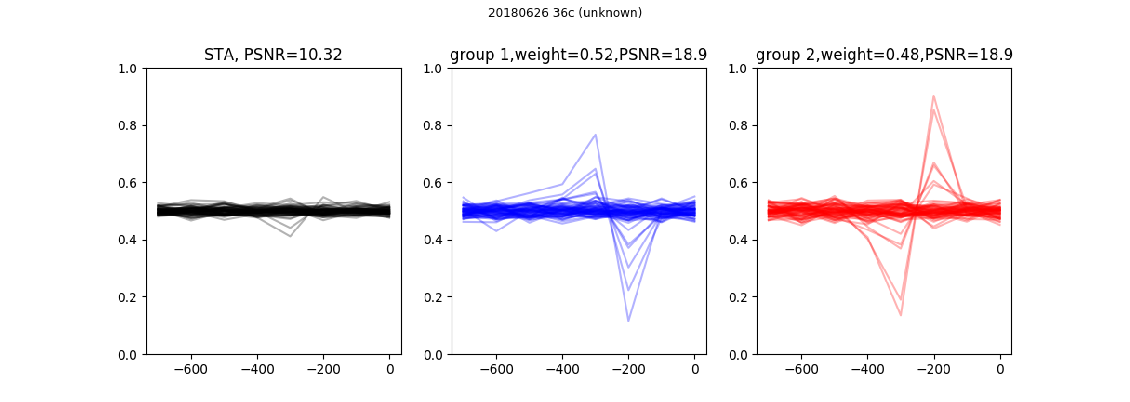

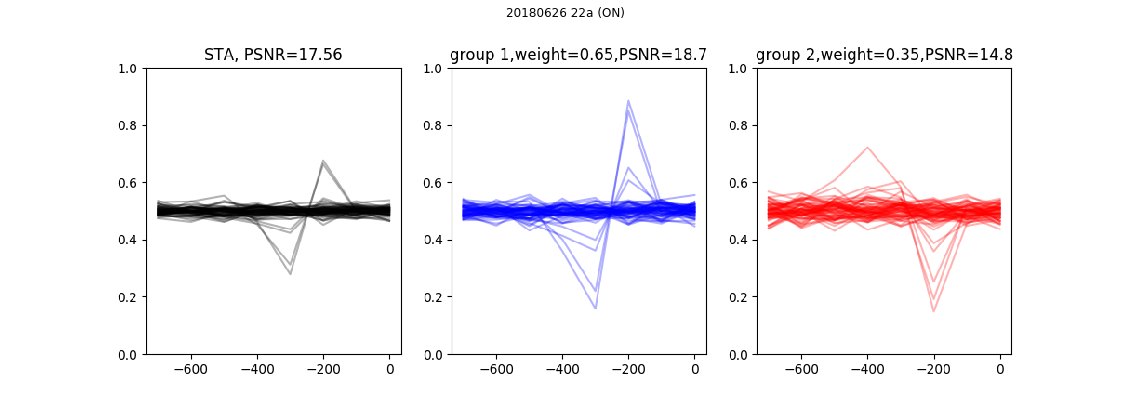

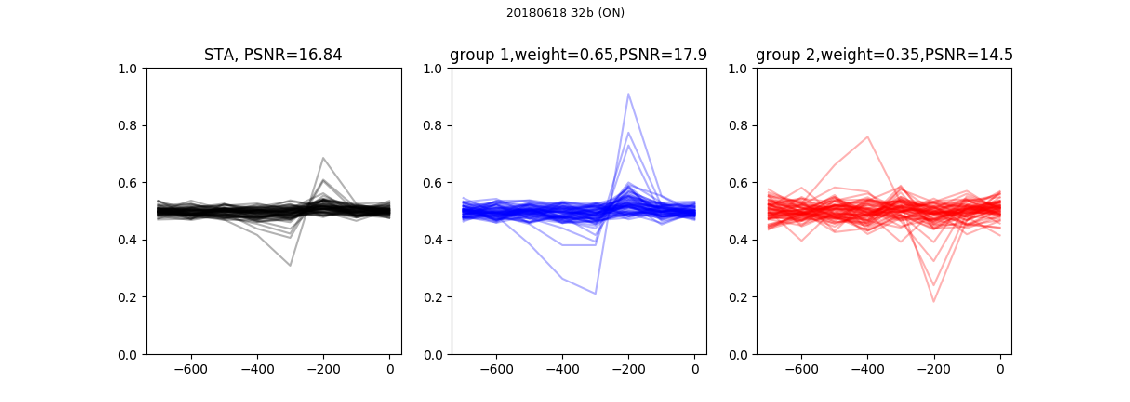

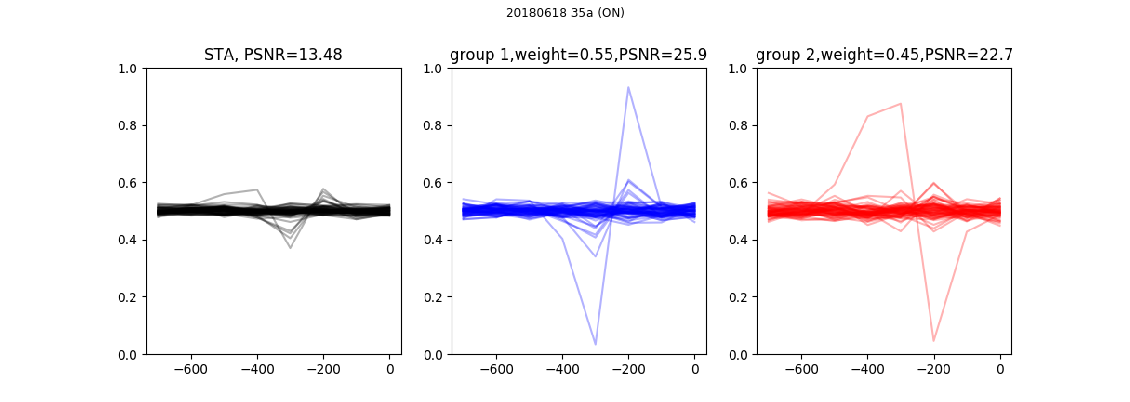

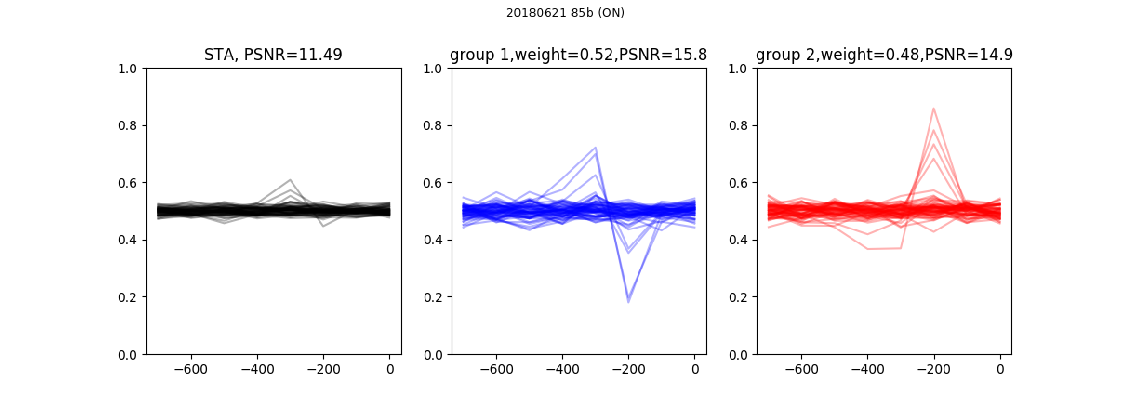

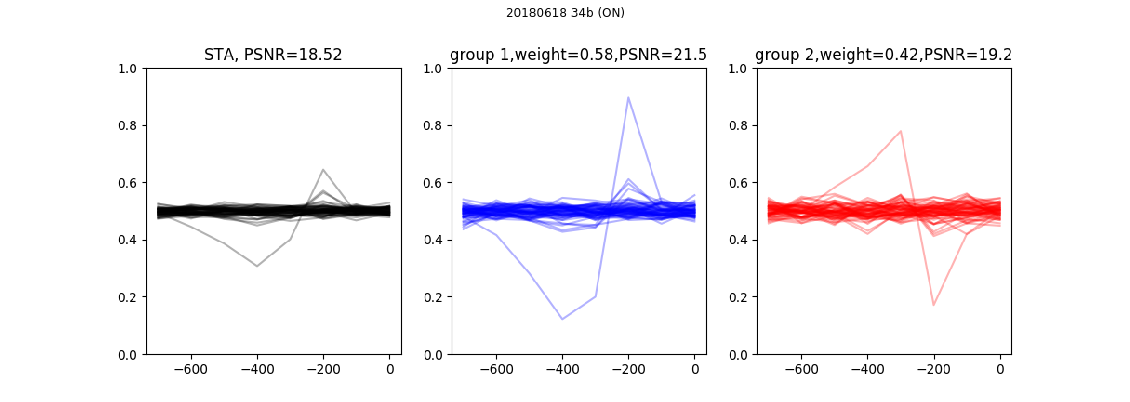

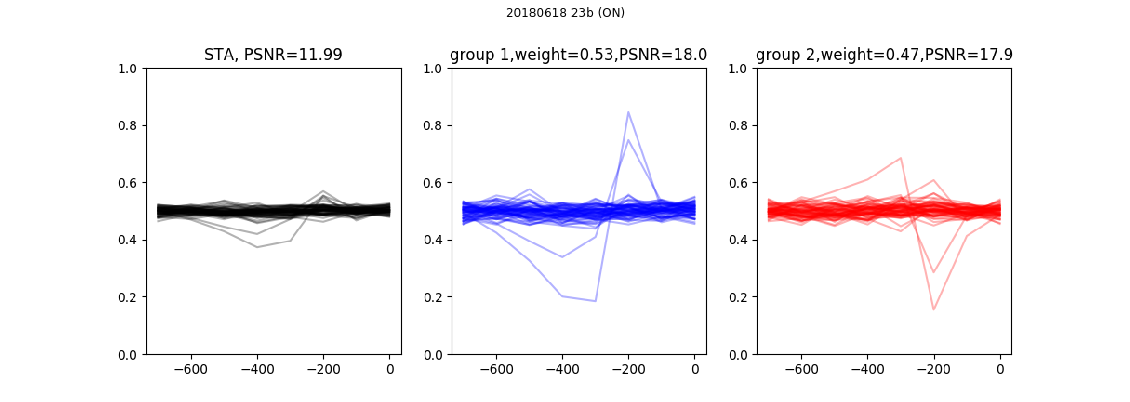

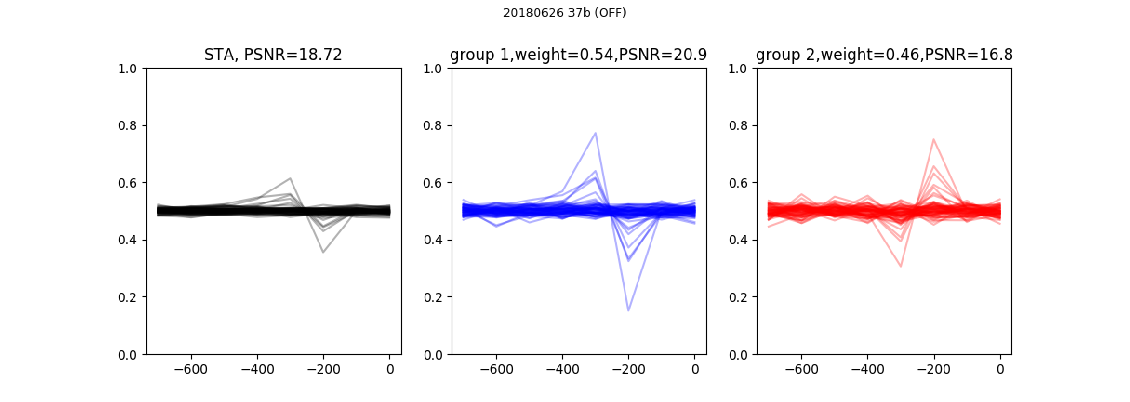

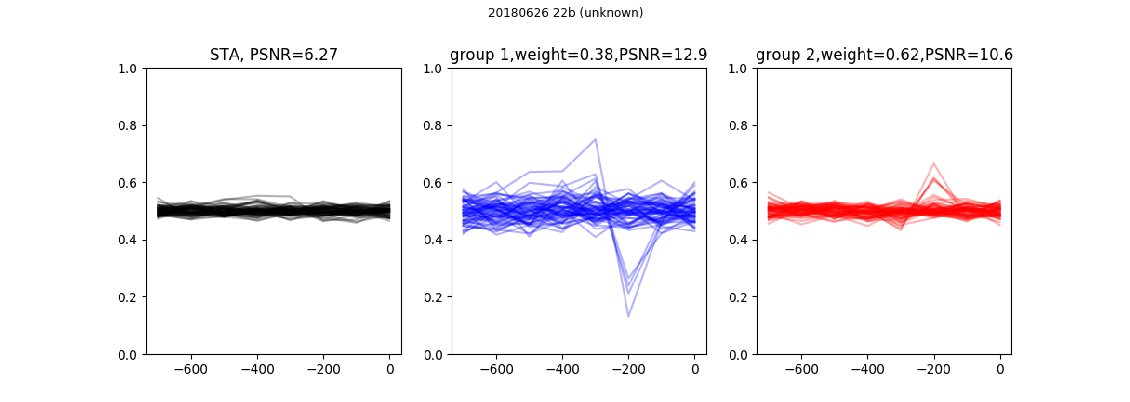

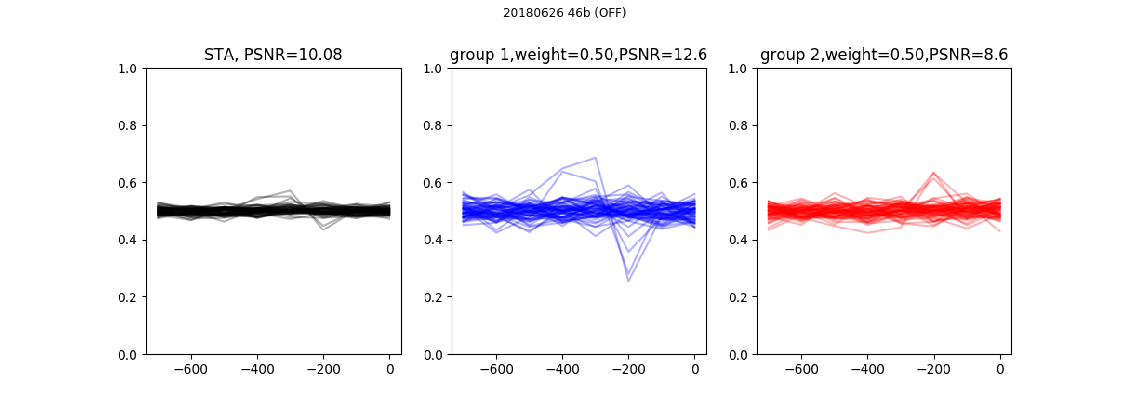

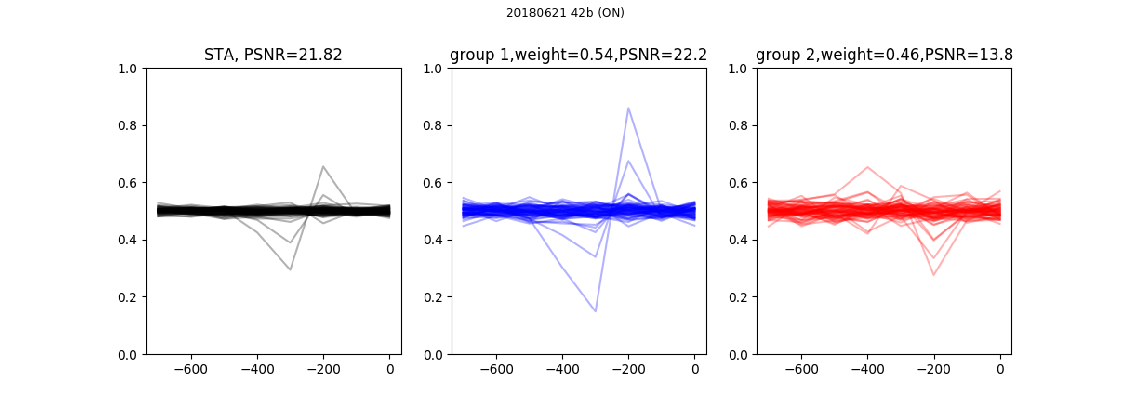

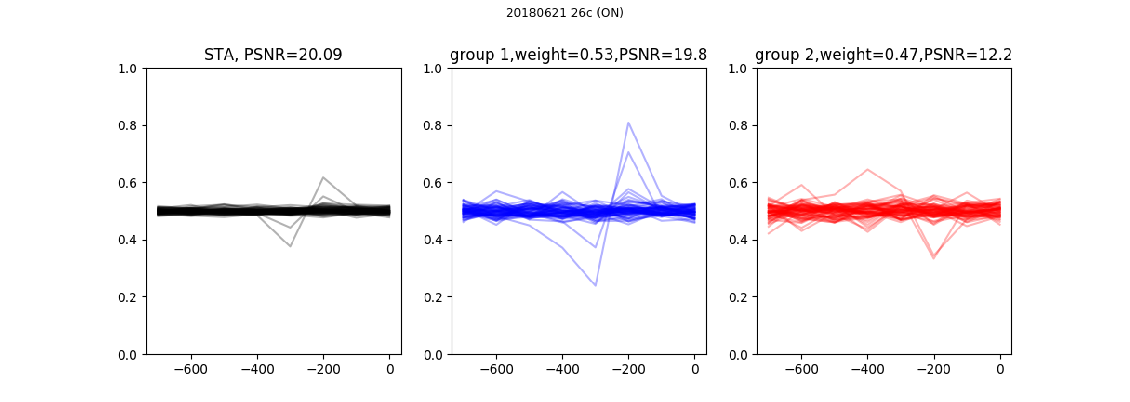

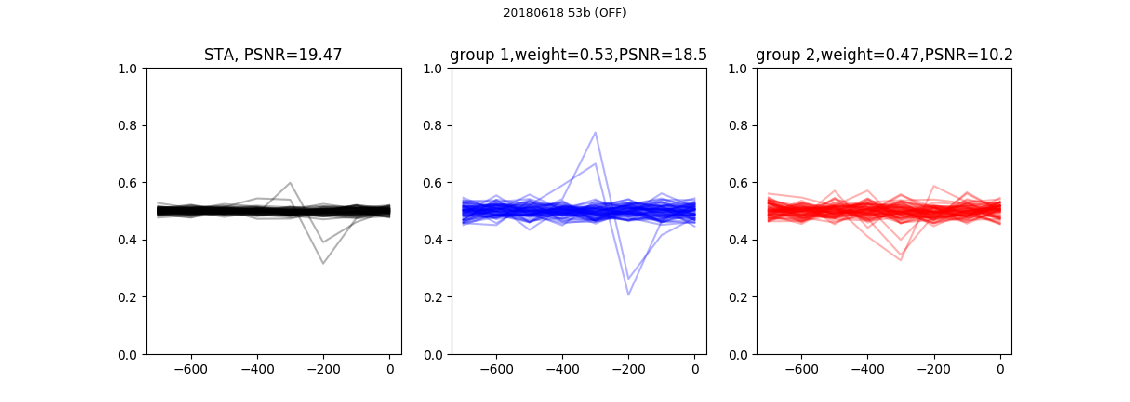

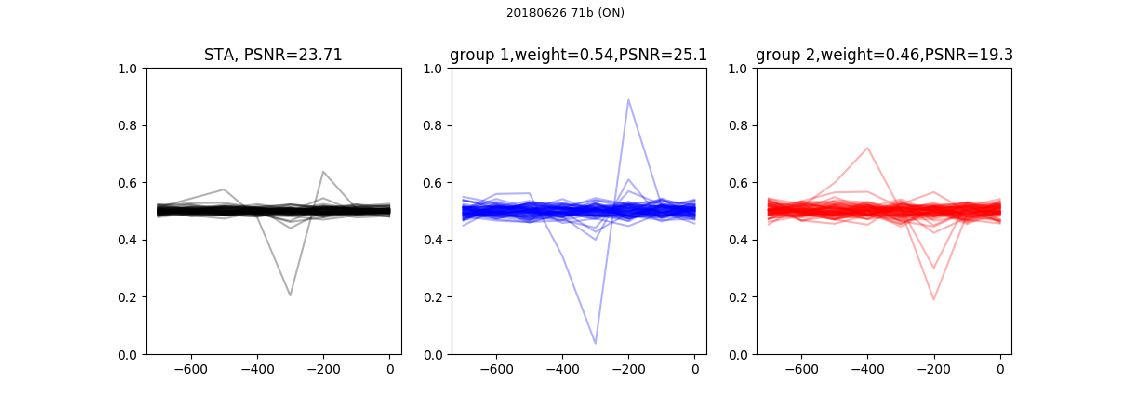

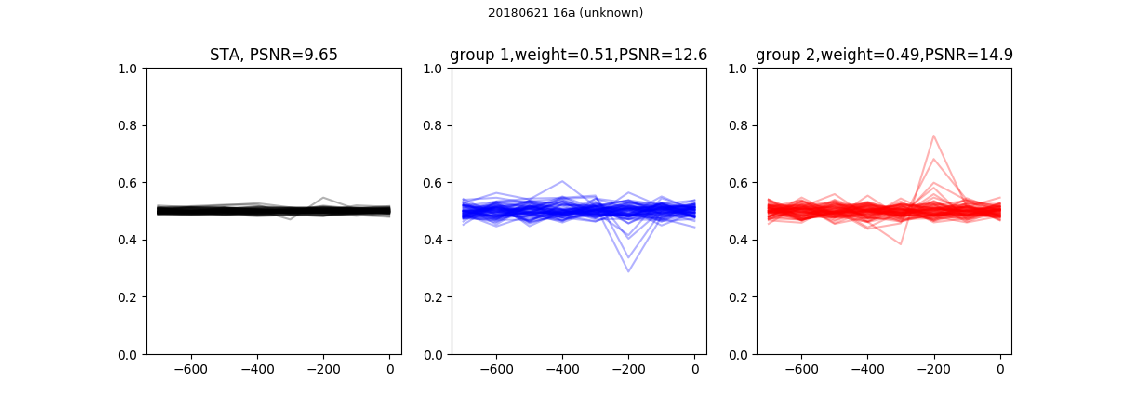

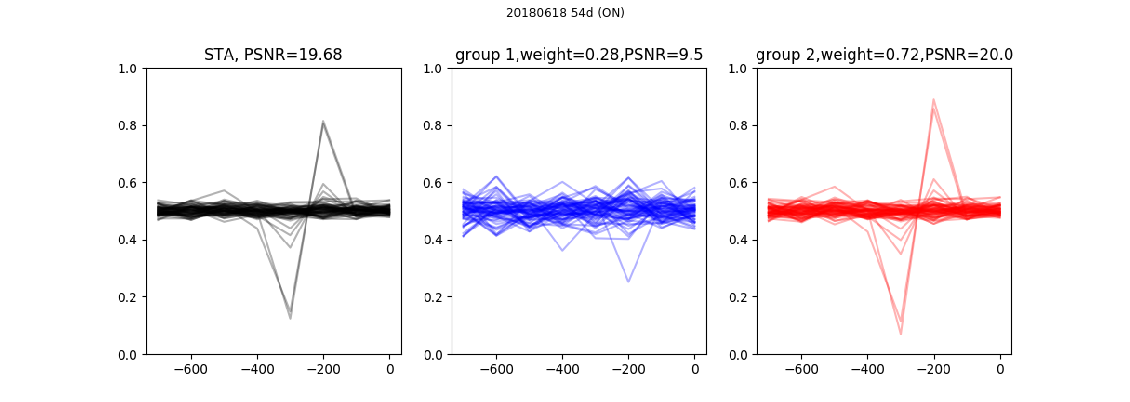

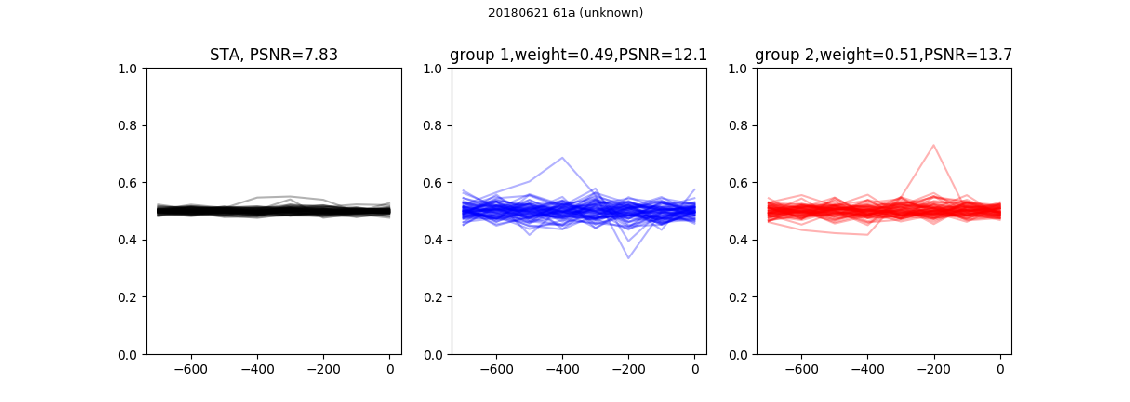

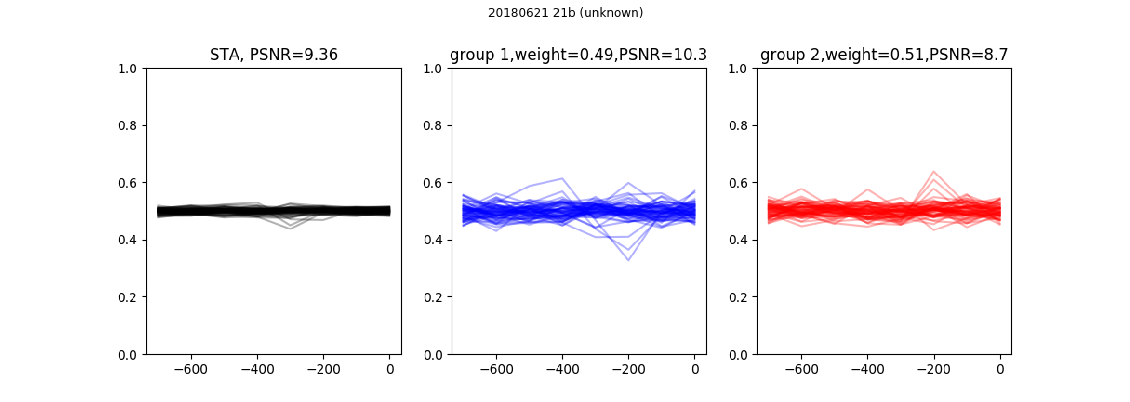

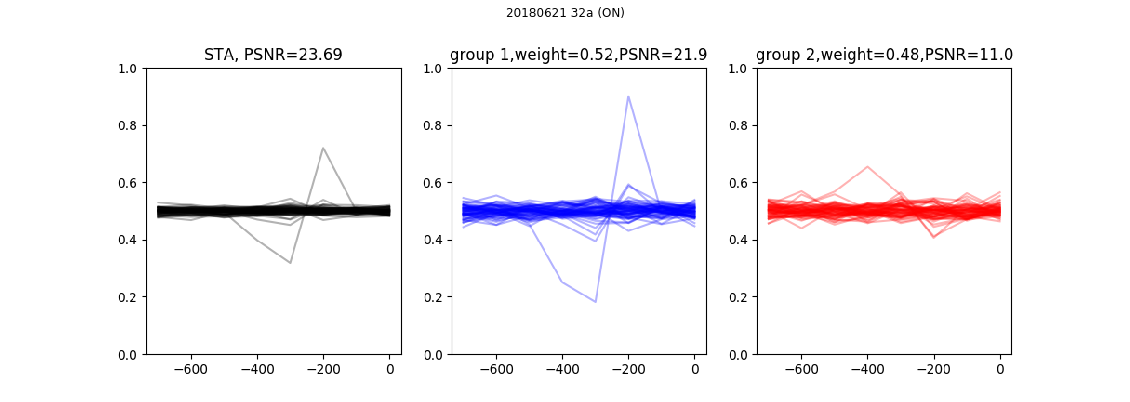

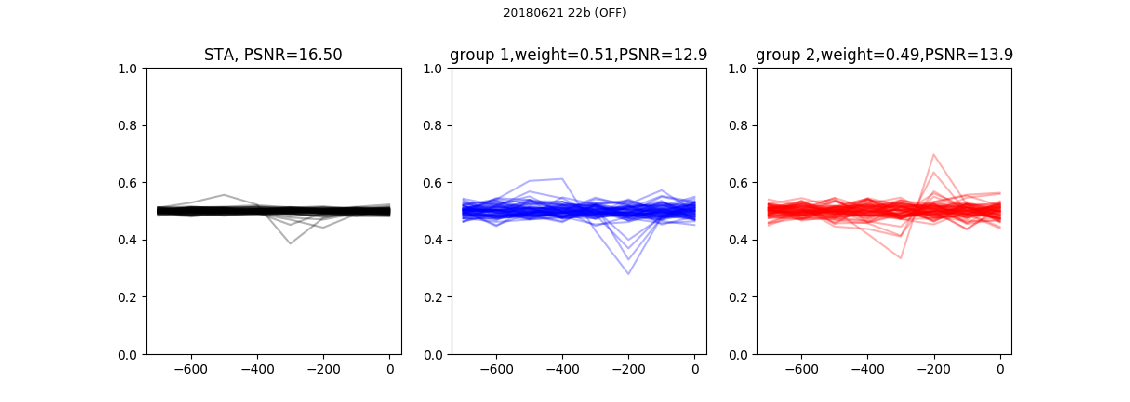

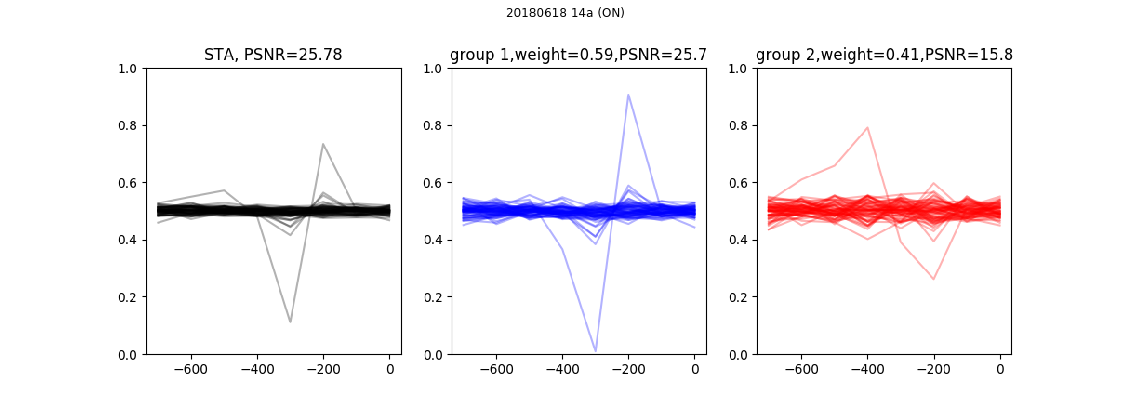

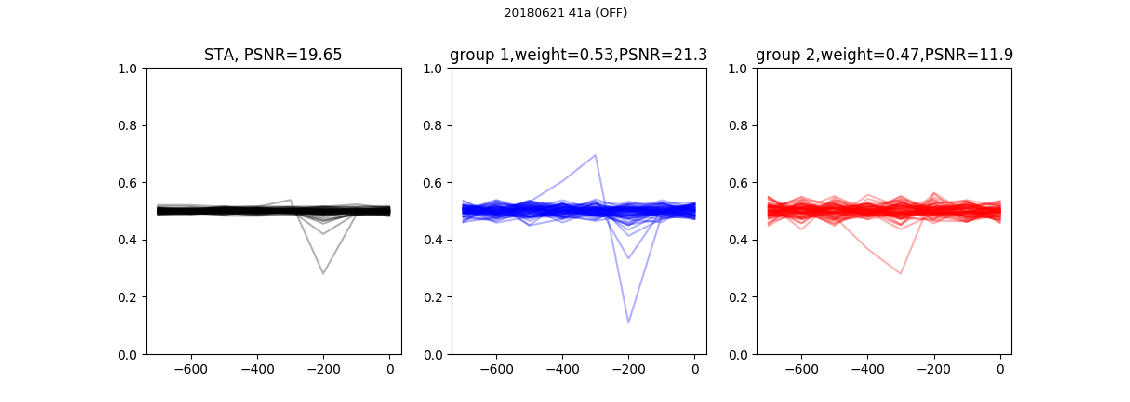

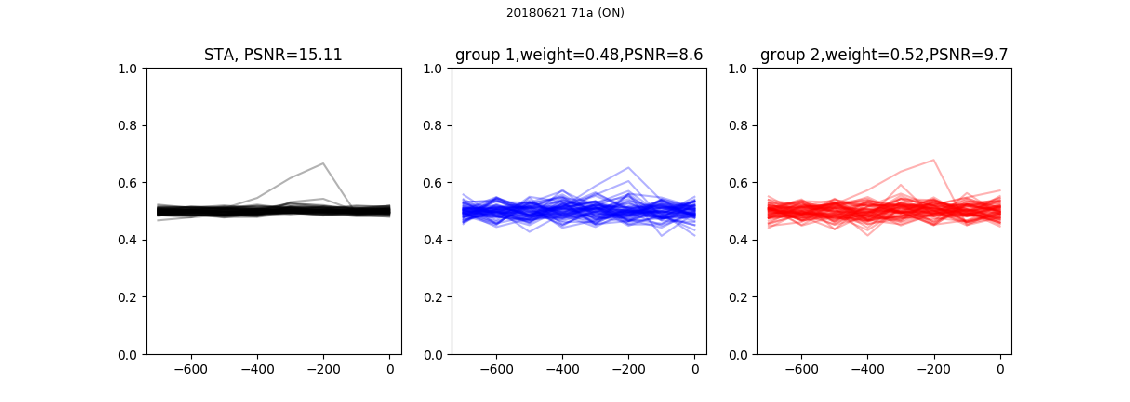

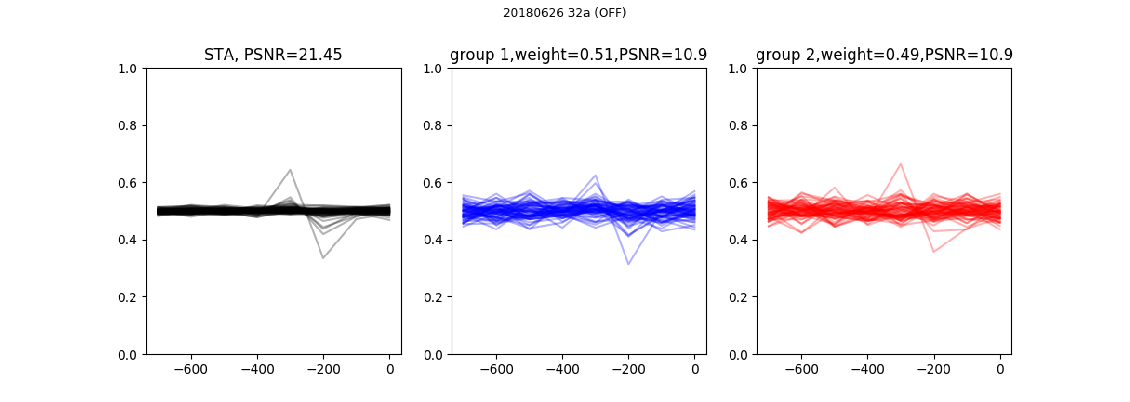

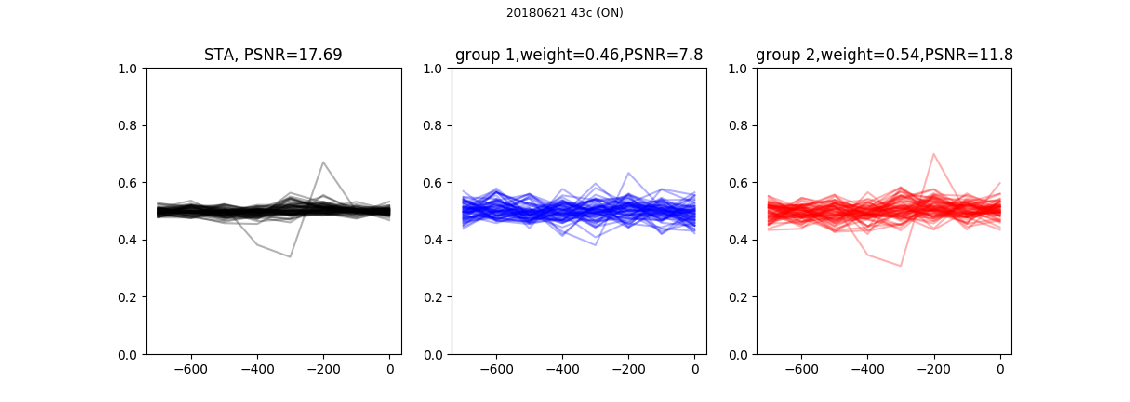

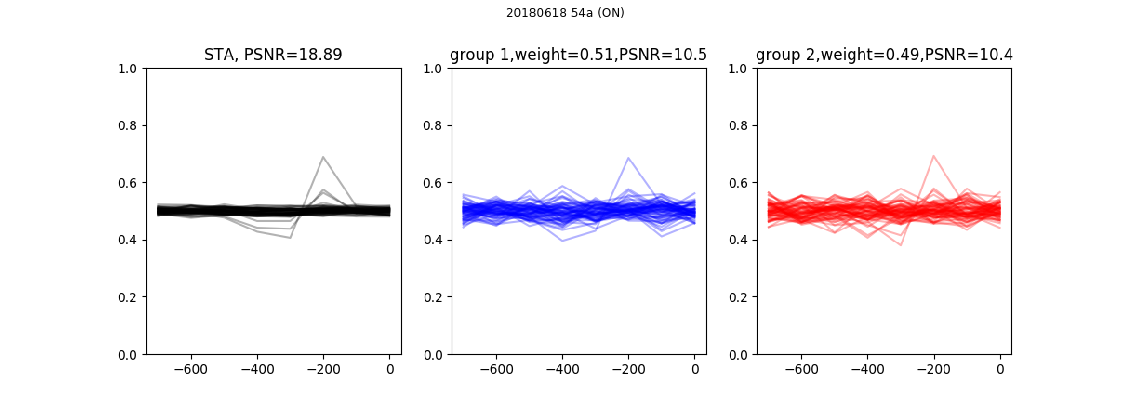

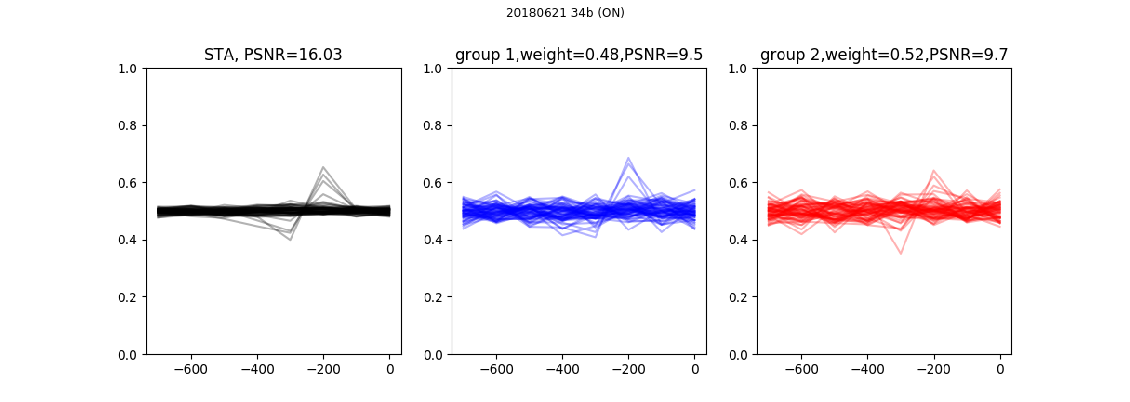

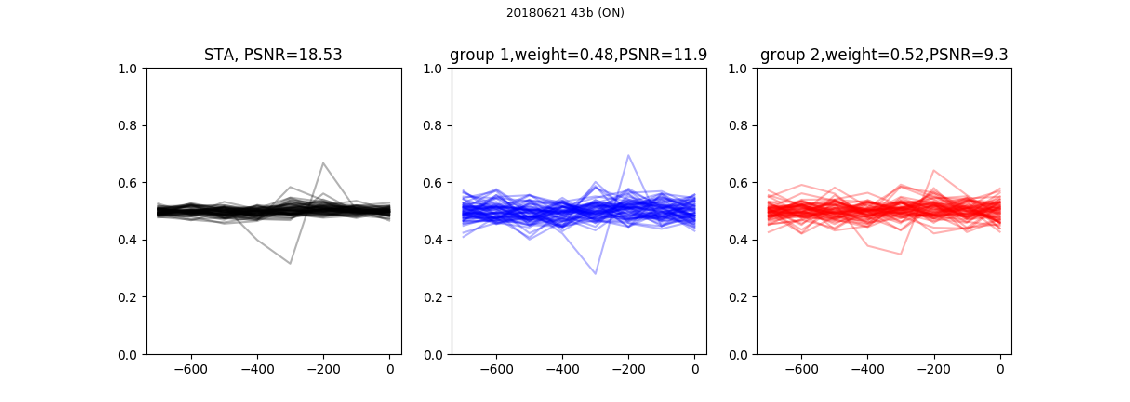

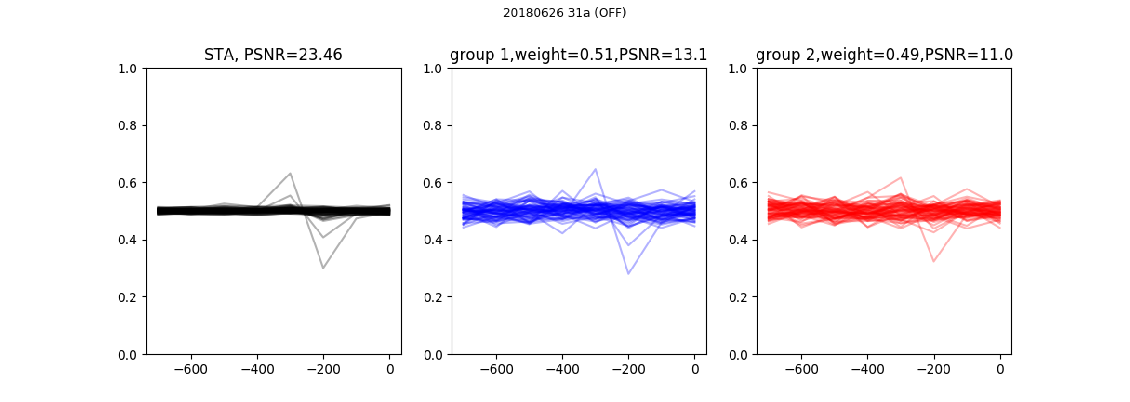

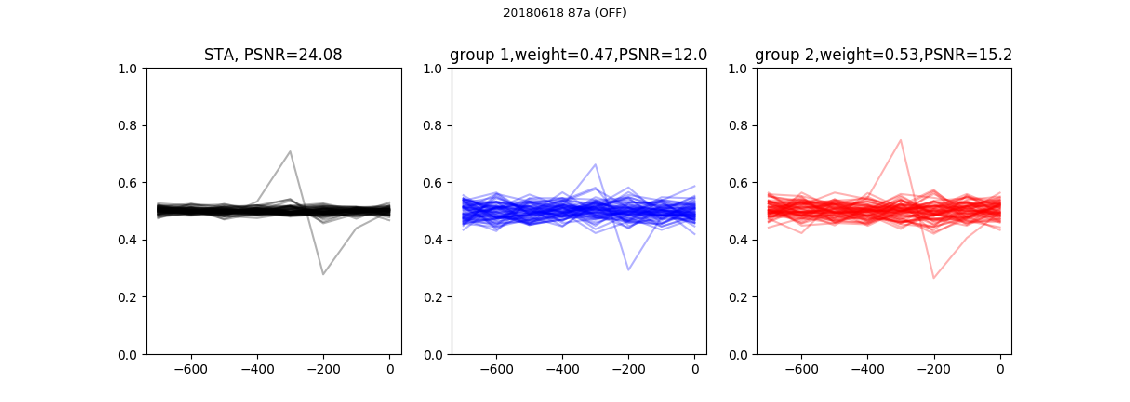

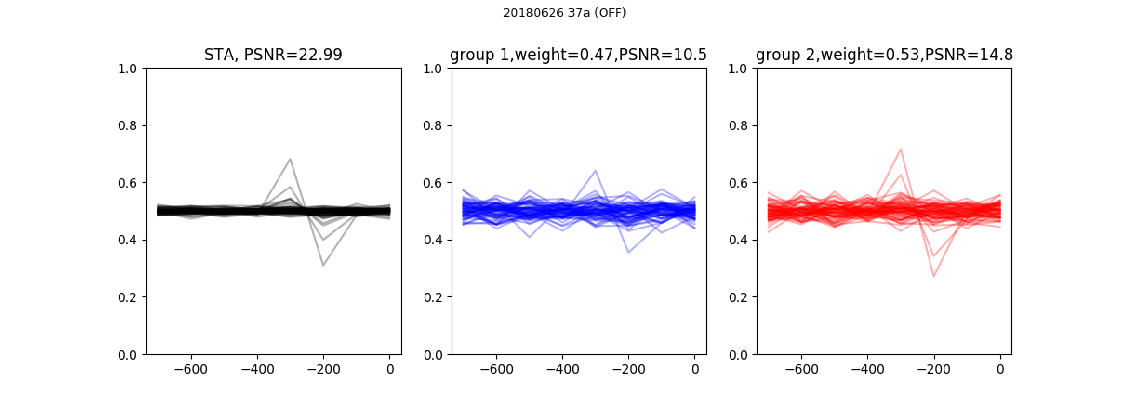

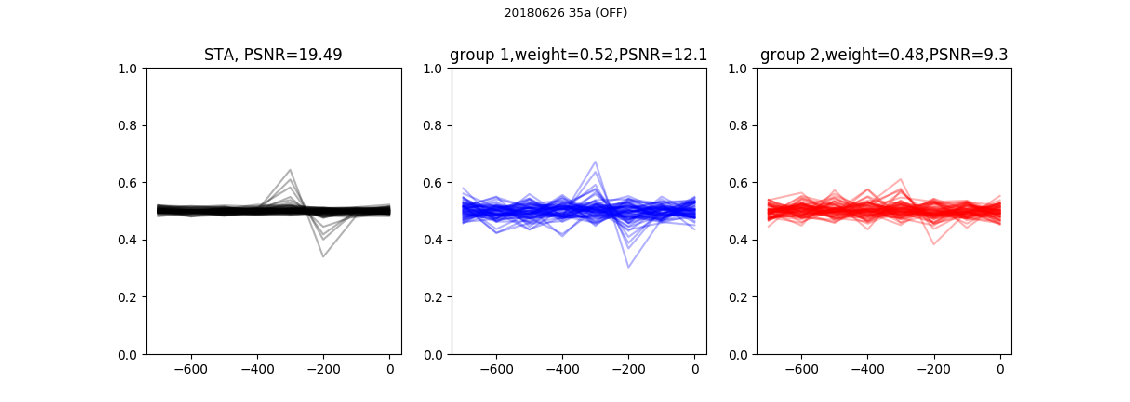

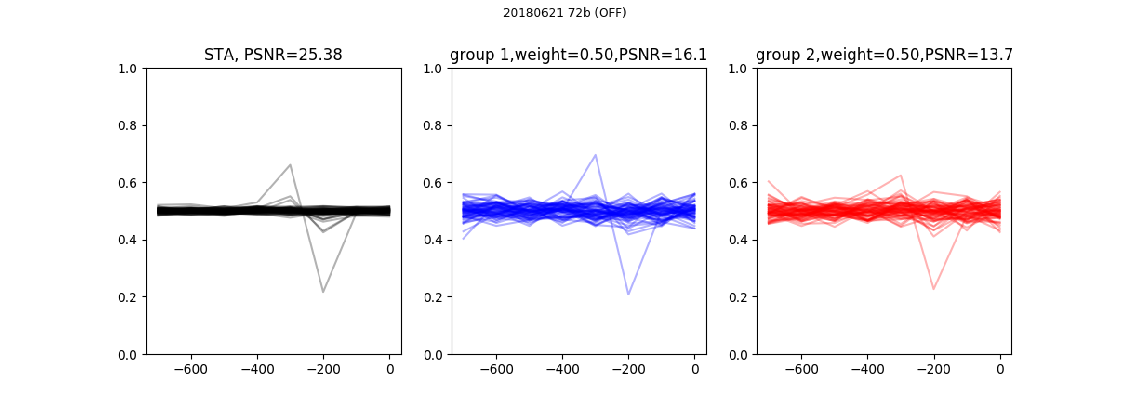

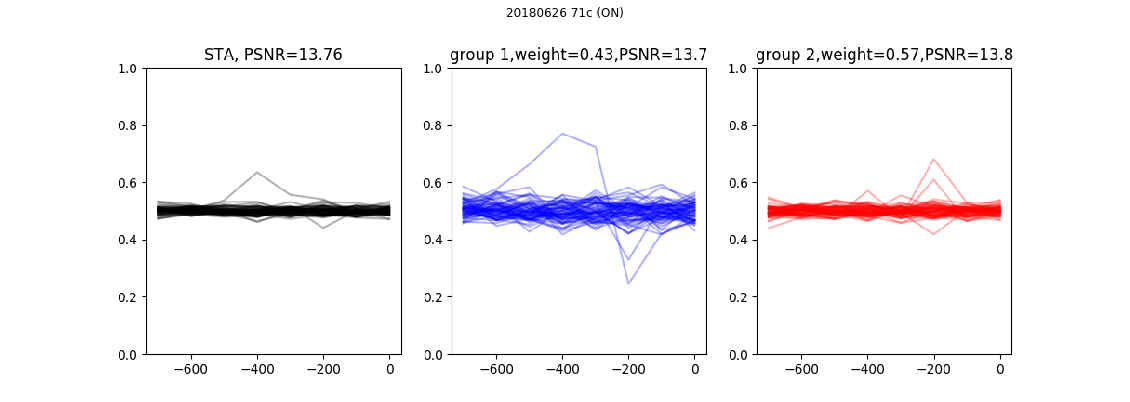

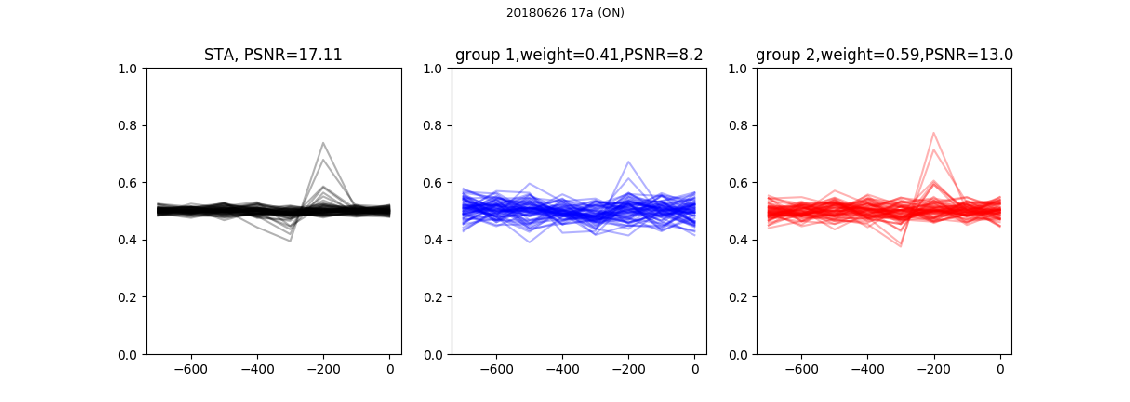

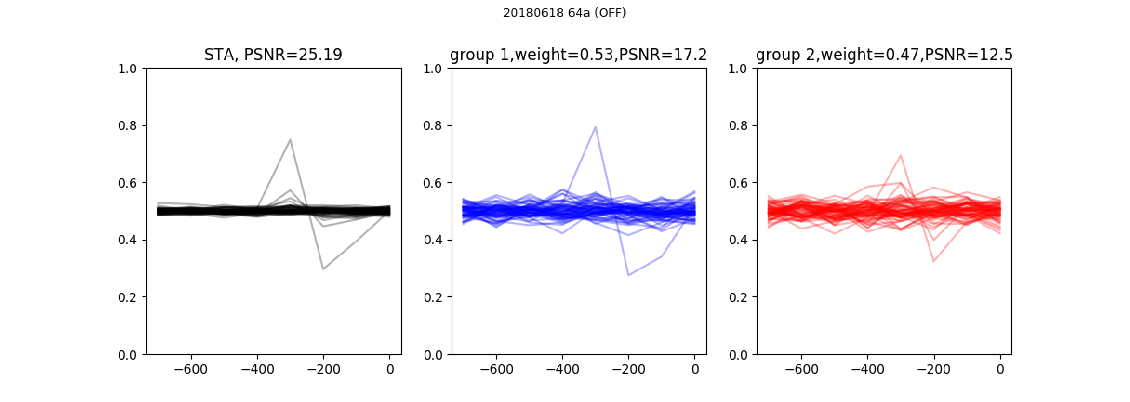

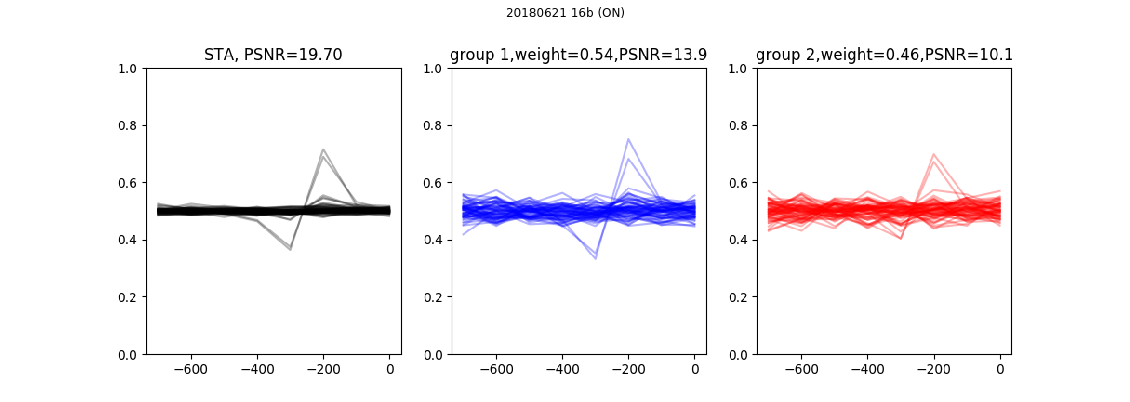

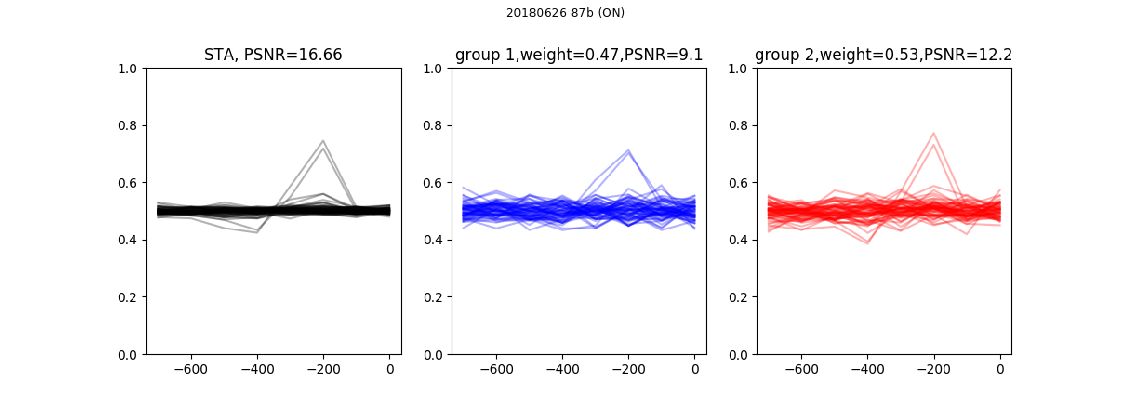

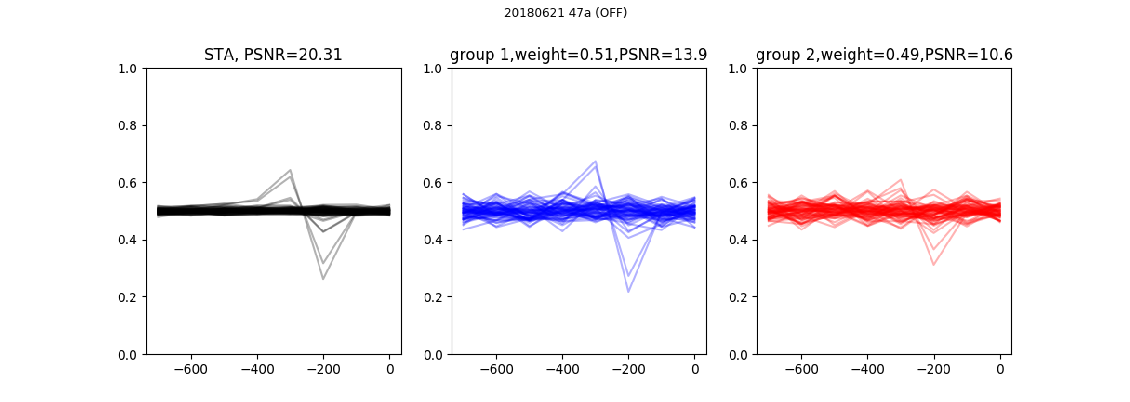

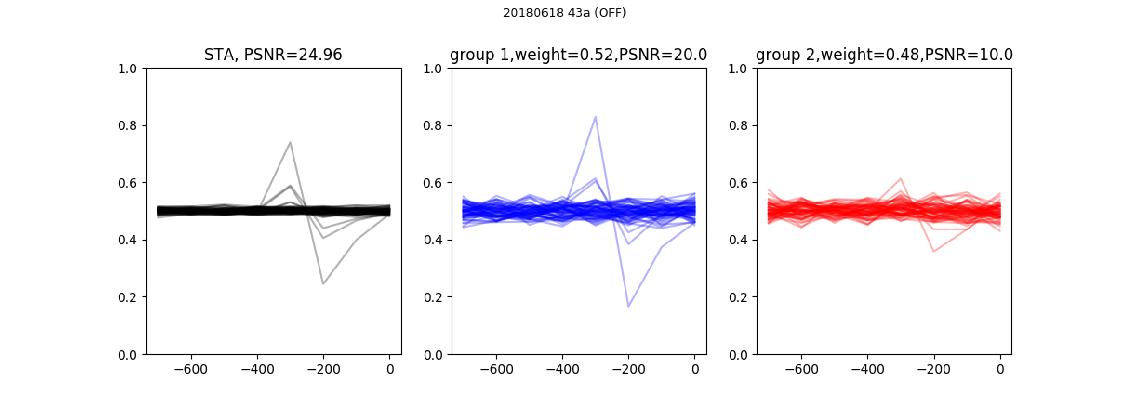

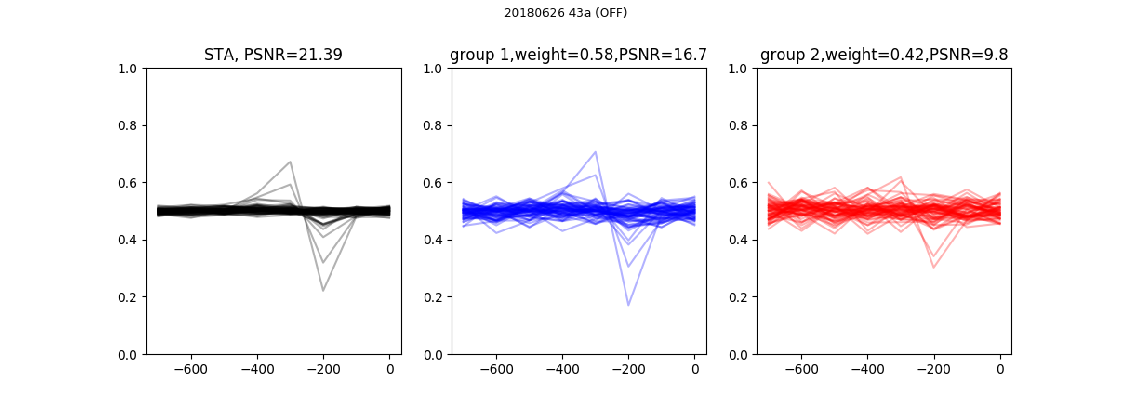

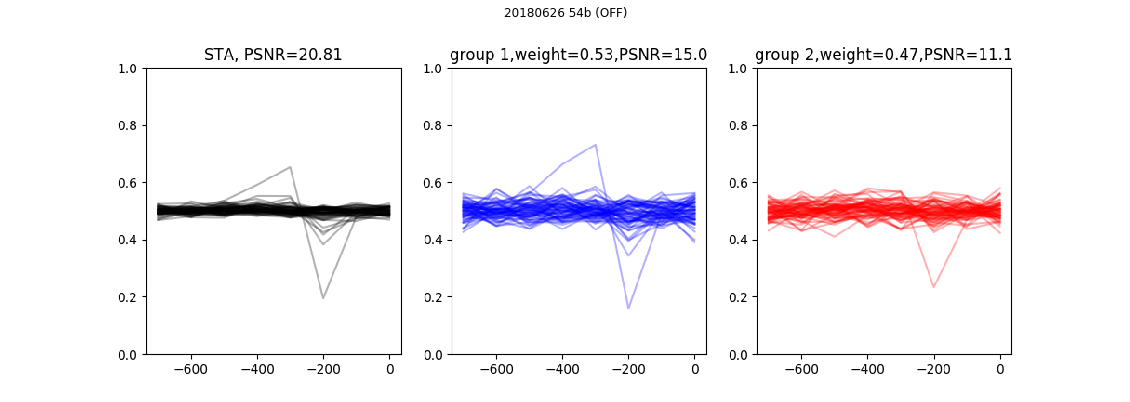

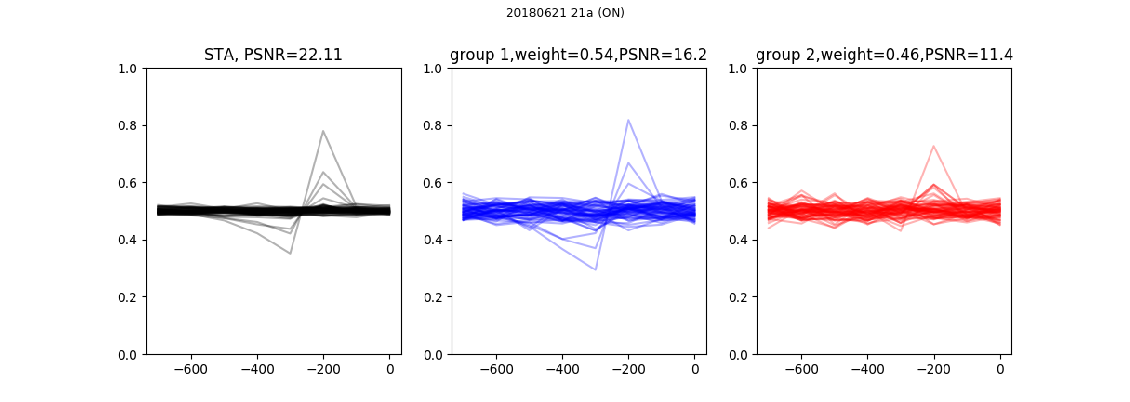

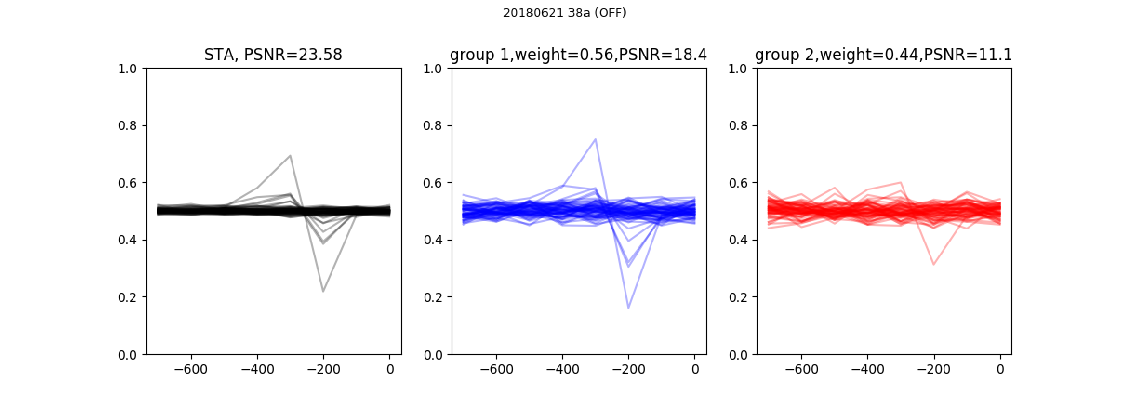

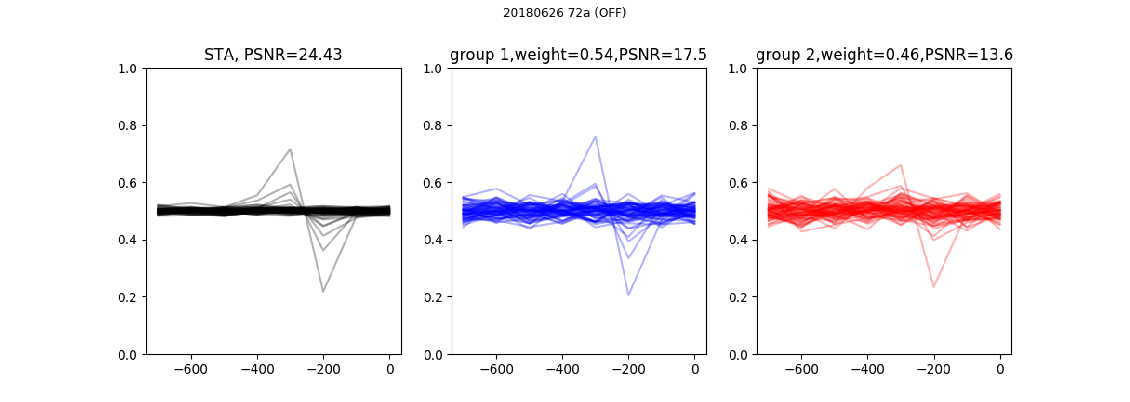

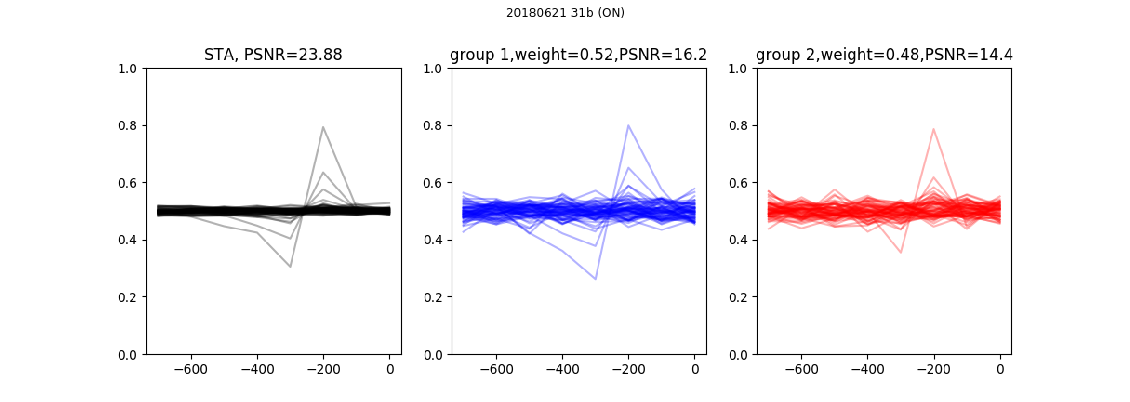

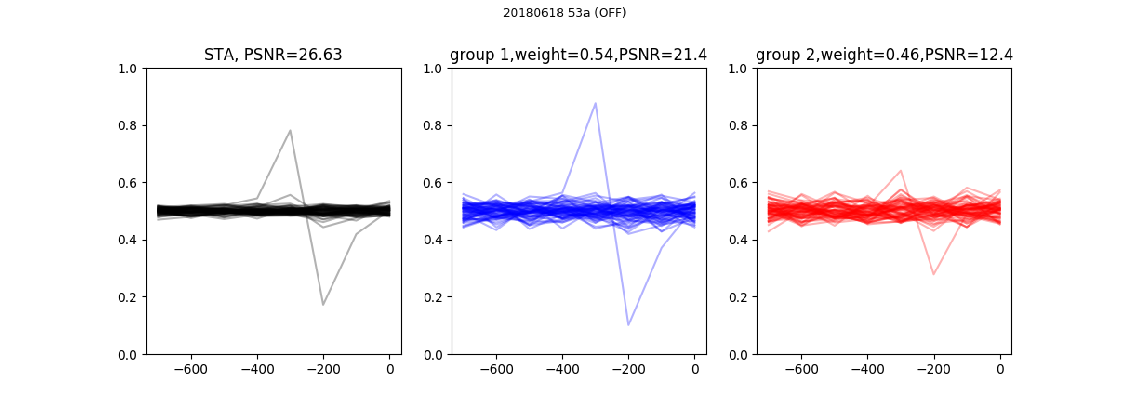

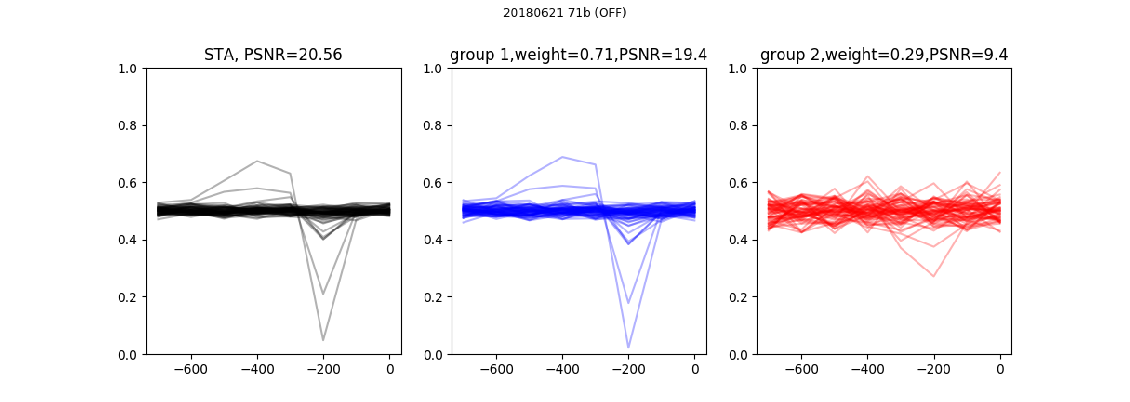

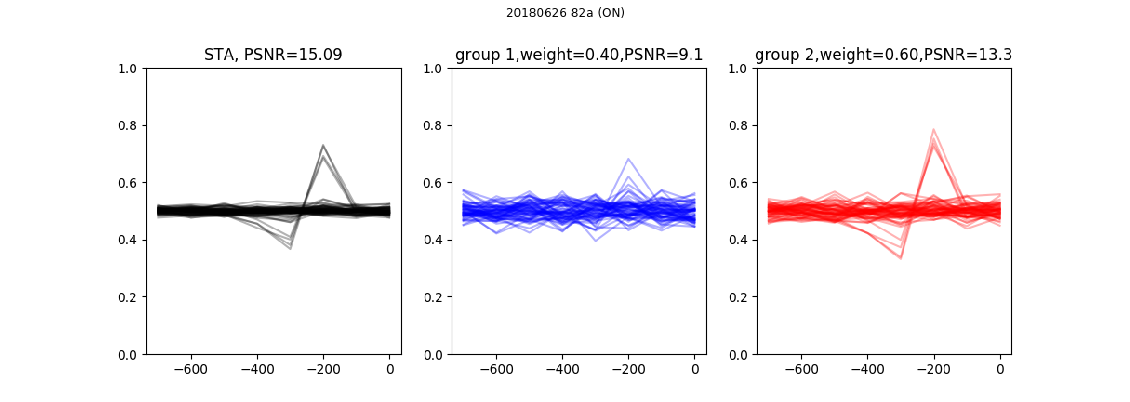

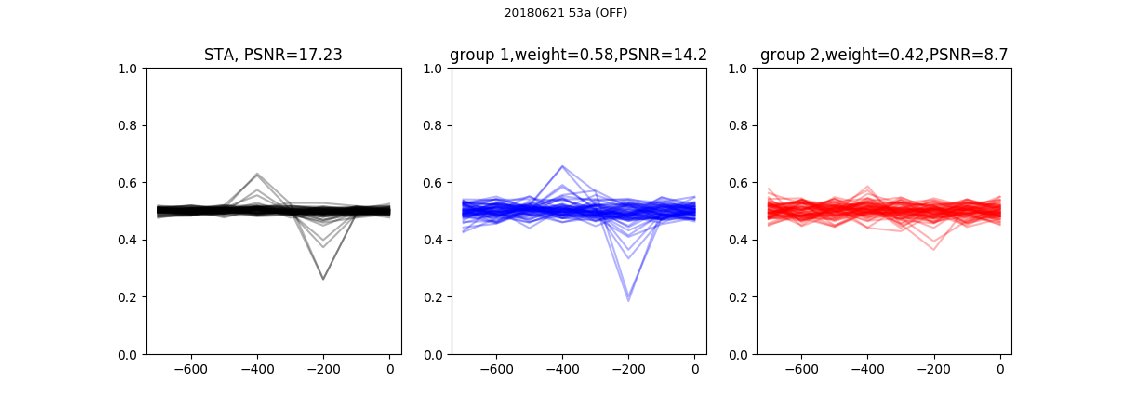

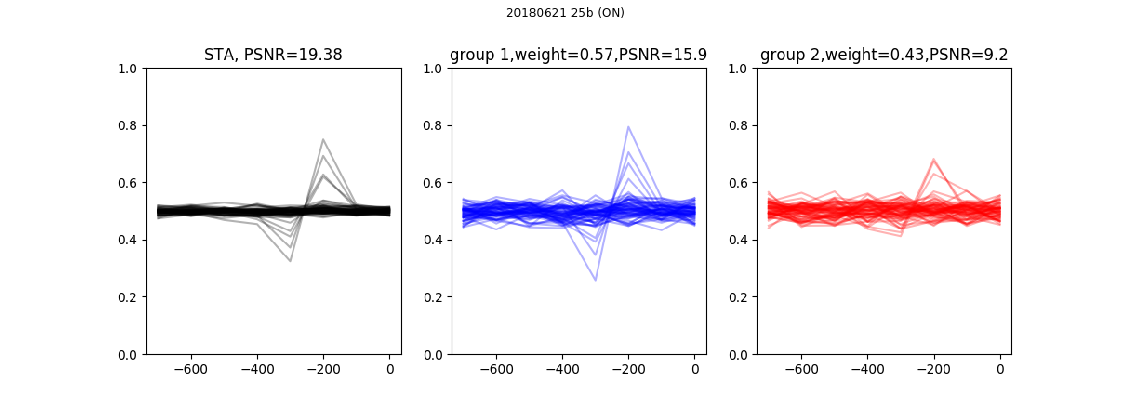

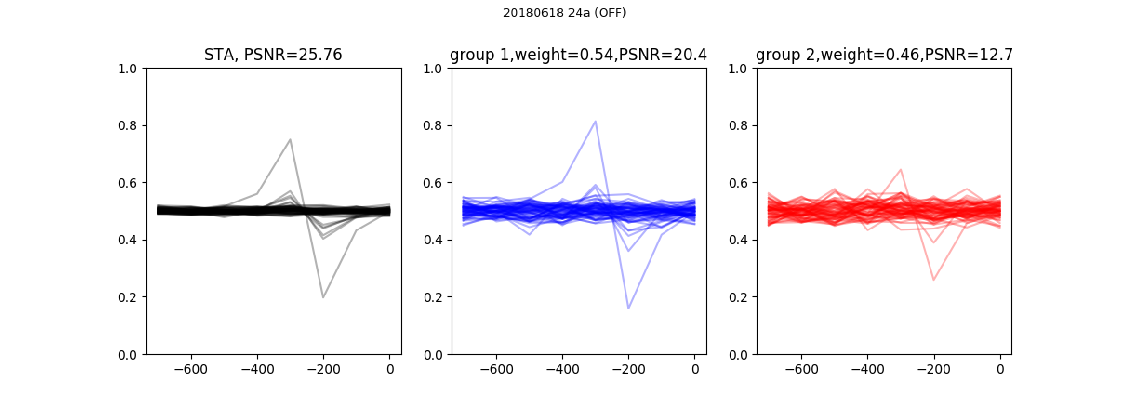

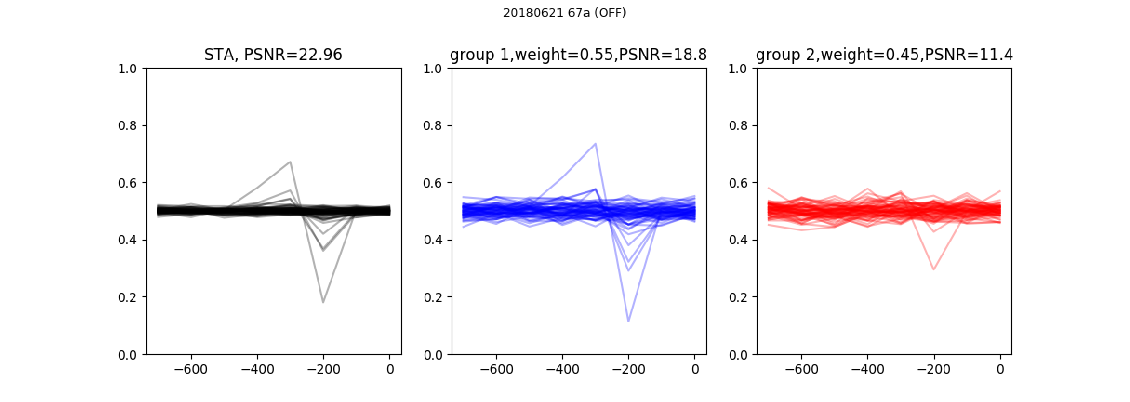

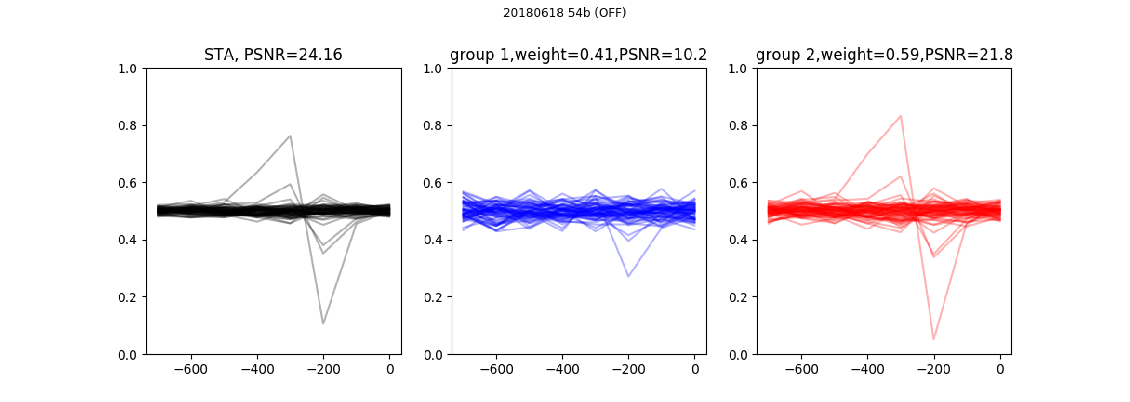

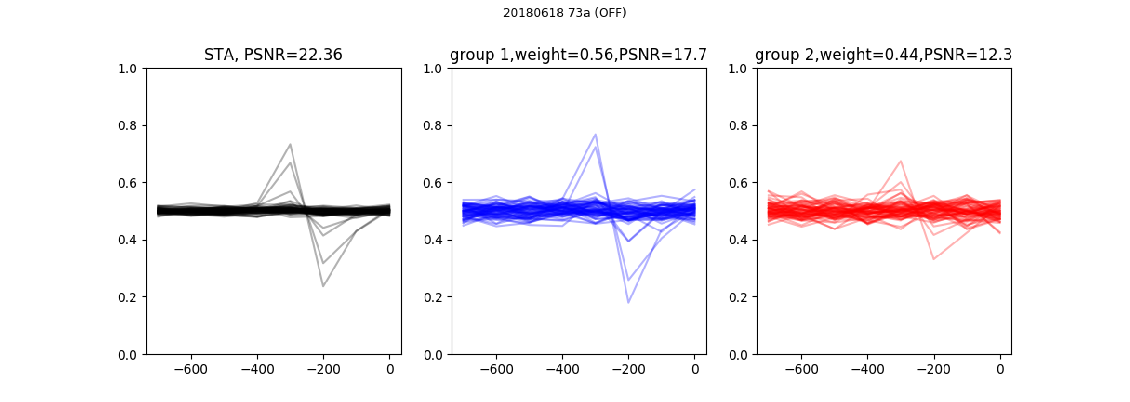

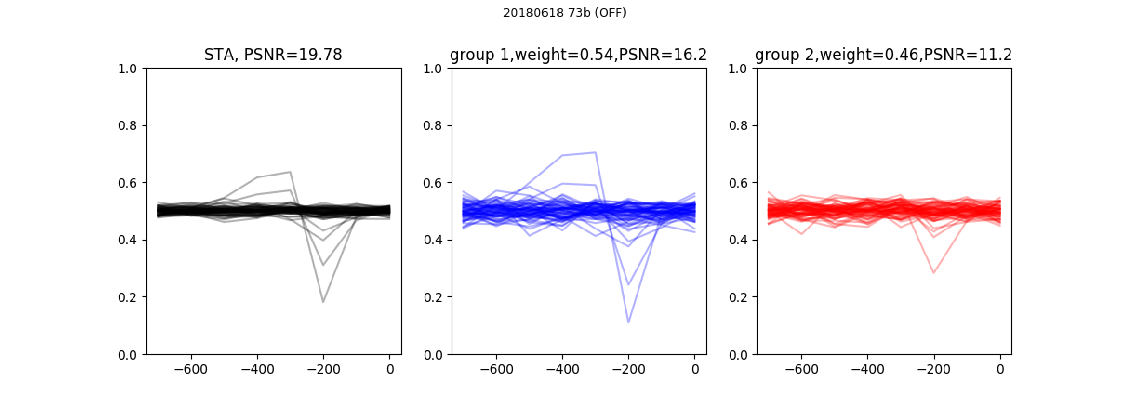

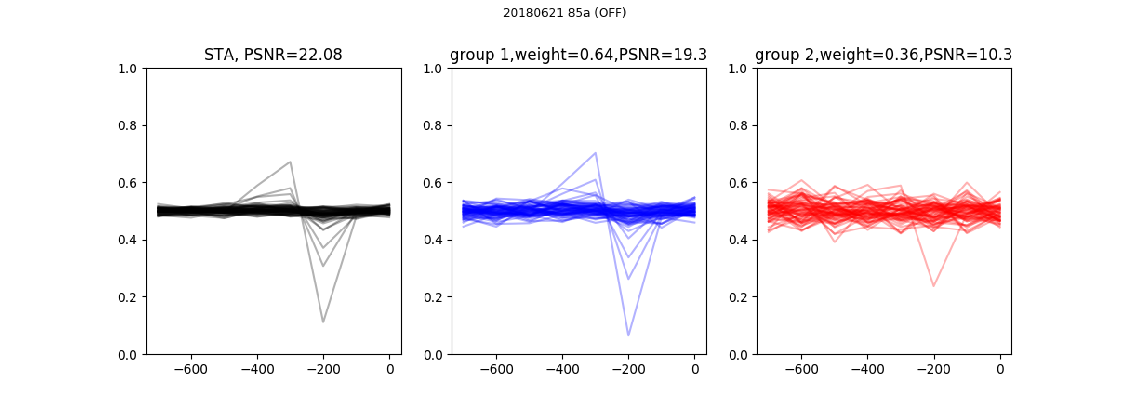

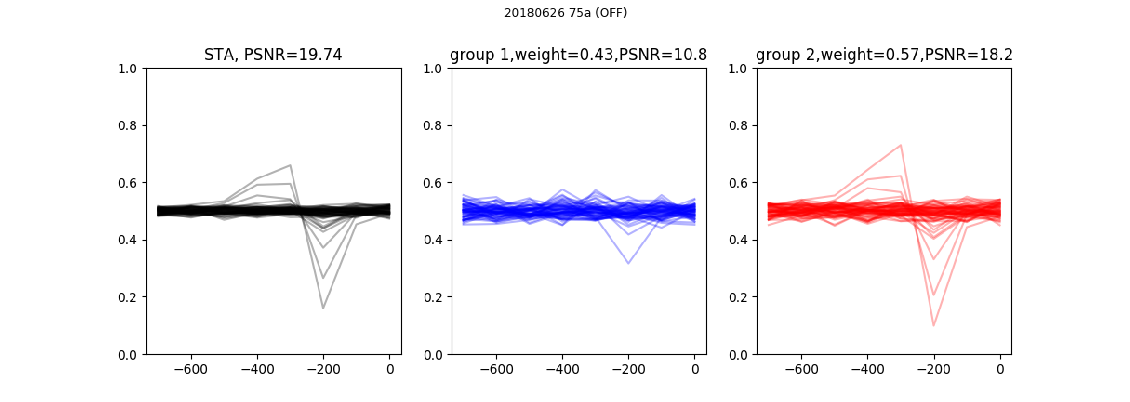

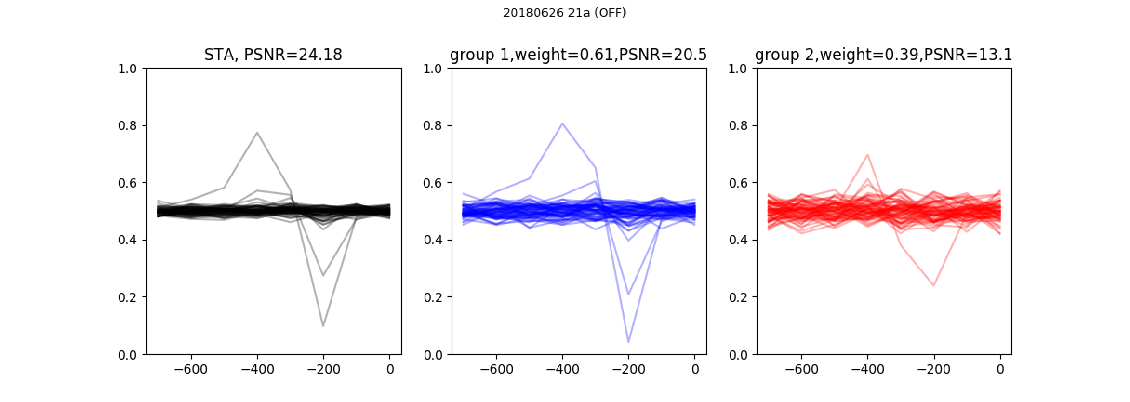

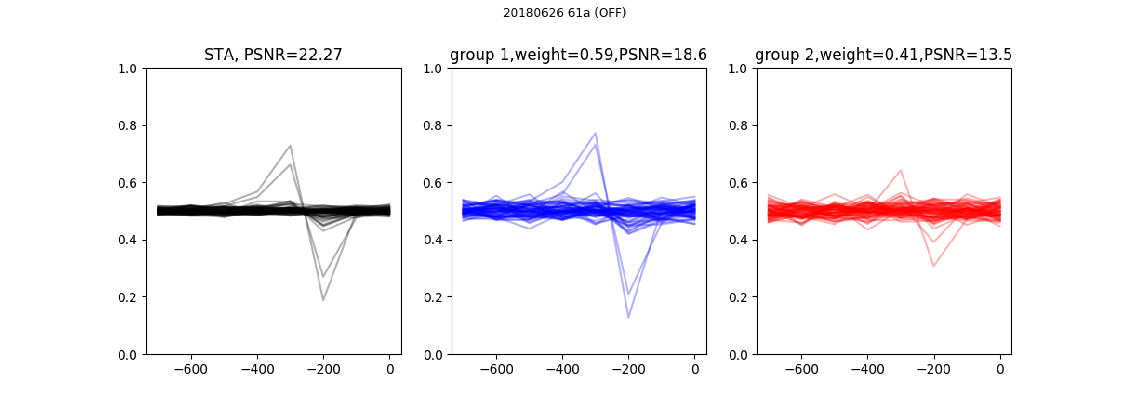

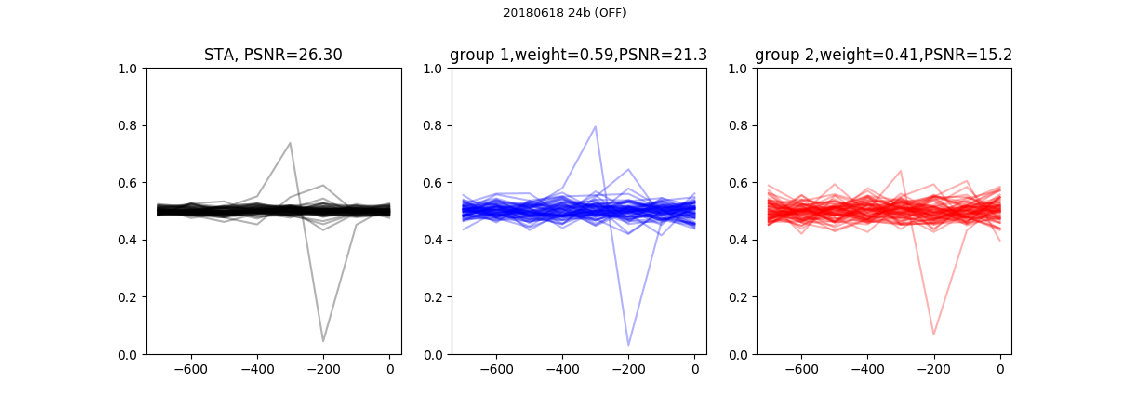

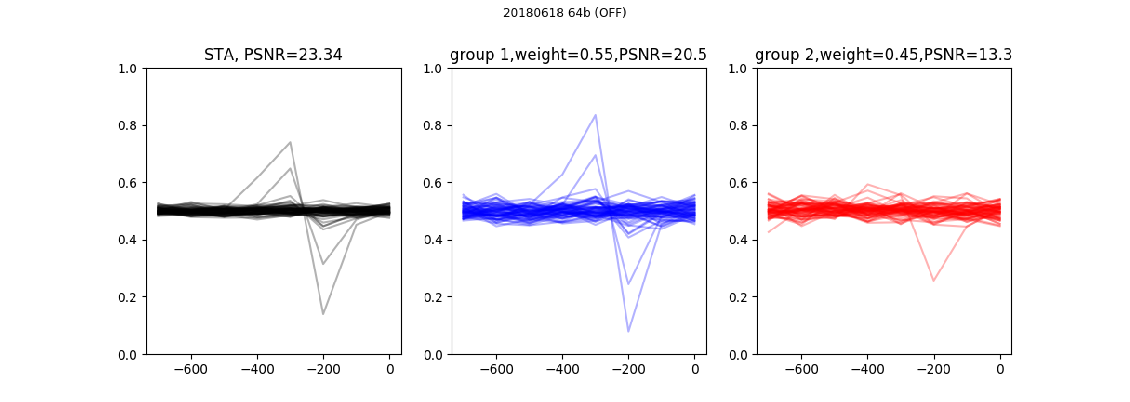

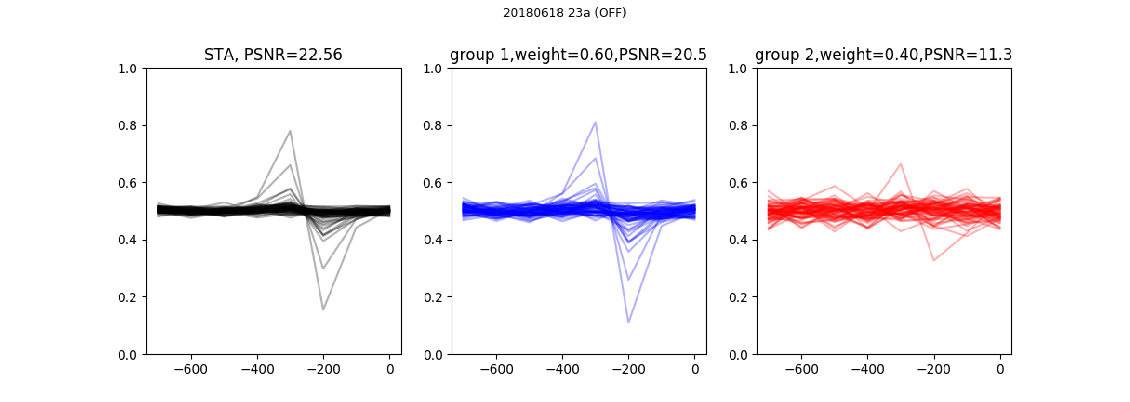

In [33]:
# sort by inner product and plot
def plot_an_example(series, dim, temporal_profile=True, spatial_profile=[], filename=None):
    dataset_name = series["dataset"]
    folder_name = "{}_tap8_stc_classic_cluster_dim{}".format(dataset_name,dim)
    channel_name = series["channel_name"]
    cell_type = series["cell_type"]
    inner_product = series["inner_product"]

    PSNR = series["PSNR"]        
    PSNR1 = series["PSNR1"]
    PSNR2 = series["PSNR2"]

    print(i, dataset_name, channel_name, cell_type, inner_product, PSNR1, PSNR2)
    
    if temporal_profile:
        plt.figure(figsize=(20,8))
        im1 = plt.imread(os.path.join(folder_name, "{}_d{}_centers.png".format(channel_name,dim)))
        
        plt.imshow(im1)
        plt.box('off')
        plt.axis('off')
        
        plt.title(dataset_name + " " + channel_name + " ({})".format(cell_type))
        if filename is not None:
            plt.savefig("{}_temporal.png".format(filename))
            print("{}_temporal.png".format(filename))

    for group_idx in spatial_profile:
        plt.figure(figsize=(20,8))
        im1 = plt.imread(os.path.join(folder_name, "{}_d{}_center_{}.png".format(channel_name,dim,group_idx)))
        
        plt.imshow(im1)
        plt.box('off')
        plt.axis('off')
        
        if filename is not None:
            plt.savefig("{}_spatial_{}.png".format(filename,group_idx))
            print("{}_spatial_{}.png".format(filename,group_idx))

        
def plot_examples(cluster_sorted, dim, temporal_profile=True, spatial_profile=[], filename=None):            
    for i in range(len(cluster_sorted)):
        
        if filename is not None:
            filename_i = "figure/{}_dim{}_{}".format(filename, dim, i)

        plot_an_example(cluster_sorted.iloc[i], dim, temporal_profile=temporal_profile, spatial_profile=spatial_profile, filename=filename_i)

        
plot_examples(cluster_thresholded, dim, filename="combined_cluster_dim{}_spd{}_sorted_by_inner_product".format(dim,spike_per_dim))

## manual check (dim=2)

28 20180626 35a OFF -0.15627982702162962 12.18316817875788 9.312846925688195


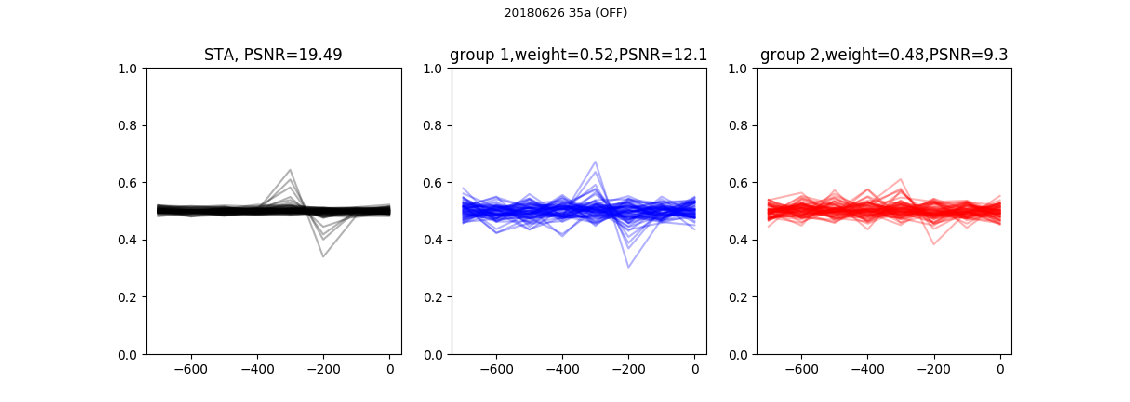

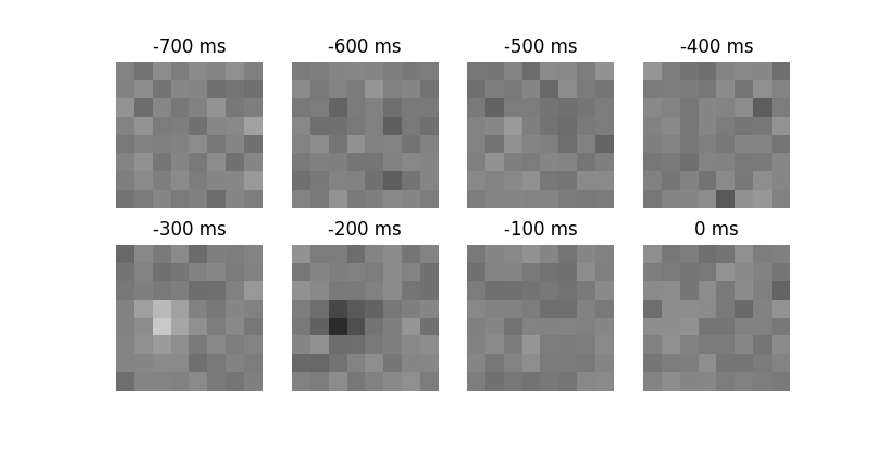

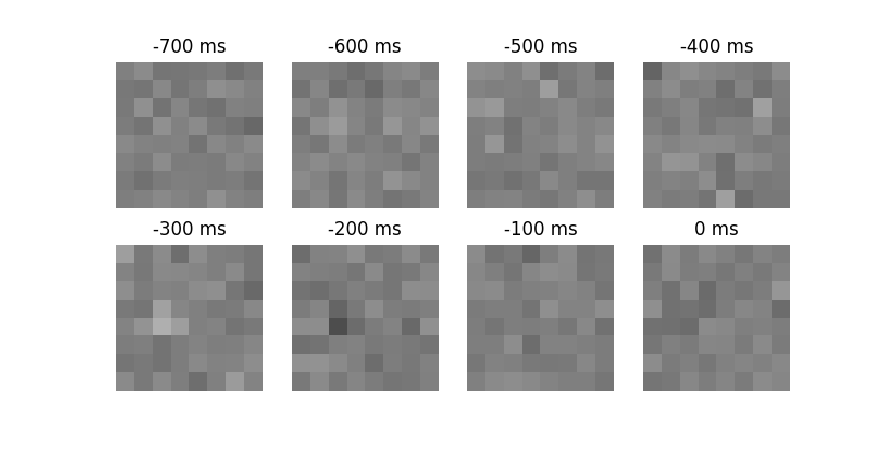

In [34]:
# double check
# plot_an_example(cluster_thresholded.iloc[16], dim, temporal_profile=True, spatial_profile=[1, 2])
# plot_an_example(cluster_thresholded.iloc[20], dim, temporal_profile=True, spatial_profile=[1, 2])
# plot_an_example(cluster_thresholded.iloc[22], dim, temporal_profile=True, spatial_profile=[1, 2])
plot_an_example(cluster_thresholded.iloc[31], dim, temporal_profile=True, spatial_profile=[1, 2])

## manual inspection (dim=2)

23


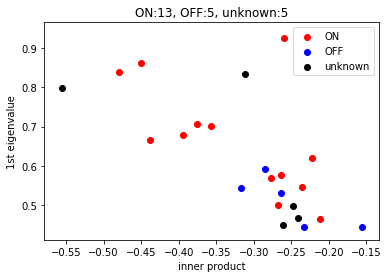

In [35]:
# manual inspection
idx_checked = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 31]
cluster_checked = cluster_thresholded.iloc[idx_checked]

print(len(cluster_checked))

plot_inner_product_vs_eig1(cluster_checked)

(-0.6, 0)

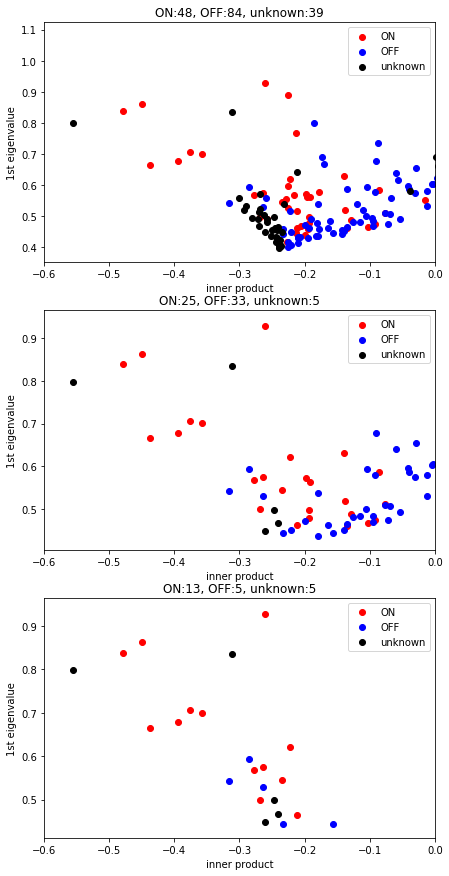

In [36]:
plt.figure(figsize=(7,15))
plt.subplot(311)
plot_inner_product_vs_eig1(cluster_with_enough_samples)
plt.xlim([-0.6, 0])
plt.subplot(312)
plot_inner_product_vs_eig1(cluster_thresholded)
plt.xlim([-0.6, 0])
plt.subplot(313)
plot_inner_product_vs_eig1(cluster_checked)
plt.xlim([-0.6, 0])

In [37]:
# # sort by inner product and plot

# cluster_sorted_by_inner_product = cluster_with_enough_samples.sort_values('inner_product').head(30)#.sort_values("dataset")

# def threshold_groups(cluster_sorted, dim, filename, PSNR_threshold):
        
#     cnt = 1
    
#     cell_type_selected = list()
#     PSNR_selected = list()
#     PSNR1_selected = list()
#     PSNR2_selected = list()    
    
#     for i in range(len(cluster_sorted)):
#         dataset_name = cluster_sorted.iloc[i]["dataset"]
#         folder_name = "{}_tap8_stc_classic_cluster_dim{}".format(dataset_name,dim)
#         channel_name = cluster_sorted.iloc[i]["channel_name"]
#         cell_type = cluster_sorted.iloc[i]["cell_type"]

#         PSNR = cluster_sorted.iloc[i]["PSNR"]        
#         PSNR1 = cluster_sorted.iloc[i]["PSNR1"]
#         PSNR2 = cluster_sorted.iloc[i]["PSNR2"]

        
#         if (PSNR1 >= PSNR_threshold) and (PSNR2 >= PSNR_threshold):
#             print(cell_type, PSNR1, PSNR2)
#             cell_type_selected.append(cell_type)
#             PSNR_selected.append(PSNR)
#             PSNR1_selected.append(PSNR1)
#             PSNR2_selected.append(PSNR2)            
        
#             plt.figure(figsize=(20,8))
#             im1 = plt.imread(os.path.join(folder_name, "{}_d{}_centers.png".format(channel_name,dim)))
#             plt.imshow(im1)
#             plt.box('off')
#             plt.axis('off')
#             plt.title(dataset_name + " " + channel_name + " ({})".format(cell_type))
#             plt.savefig("figure/{}_{}_dim{}.png".format(filename, cnt, dim))

#             plt.show()

#             cnt = cnt + 1
    
#     return cell_type_selected, PSNR_selected, PSNR1_selected, PSNR2_selected

# cell_type_selected, PSNR_selected, PSNR1_selected, PSNR2_selected = threshold_groups(cluster_sorted_by_inner_product, dim, "cluster_inner_product", 8.5)


In [38]:
cluster_checked

channel_name  num_spikes cell_type       PSNR      eig1      eig2  \
64           36c        4098   unknown  10.318830  0.798256  0.620102   
24           22a        2860        ON  17.556724  0.838246  0.704459   
38           32b        3530        ON  16.838700  0.862429  0.749463   
44           35a        9638        ON  13.477084  0.665520  0.552200   
109          85b        4002        ON  11.494061  0.678136  0.597015   
43           34b        4208        ON  18.520772  0.706069  0.597161   
22           23b        4619        ON  11.990694  0.700543  0.608037   
67           37b        9568       OFF  18.715314  0.542621  0.476537   
25           22b        2413   unknown   6.267735  0.835159  0.782430   
86           46b        2762       OFF  10.083432  0.592556  0.580456   
57           42b        8472        ON  21.819161  0.567641  0.502737   
26           26c        6699        ON  20.090976  0.498963  0.470083   
71           53b        6622       OFF  19.471693  0.529478  0.499515   
122          71b        7557        ON  23.712959  0.575136  0.510658   
6            16a       22460   unknown   9.654894  0.448151  0.420615   
76           54d        2966        ON  19.675728  0.927184  0.759760   
77           61a        6741   unknown   7.826017  0.497795  0.488286   
12           21b       10519   unknown   9.359431  0.466609  0.459186   
33           32a       11842        ON  23.692912  0.544881  0.489408   
14           22b       15606       OFF  16.500673  0.443572  0.439005   
7            14a        5973        ON  25.775064  0.620785  0.571746   
94           71a        9182        ON  15.114864  0.463777  0.463223   
55           35a        9247       OFF  19.494948  0.444619  0.438636   

         eig3  converged      PSNR1      PSNR2   weight1   weight2  \
64   0.613533       True  18.892517  18.855896  0.523945  0.476055   
24   0.671715       True  18.716530  14.826105  0.647365  0.352635   
38   0.716215       True  17.935097  14.497685  0.648691  0.351309   
44   0.548982       True  25.869758  22.670575  0.553190  0.446810   
109  0.581718       True  15.845651  14.882373  0.515154  0.484846   
43   0.588002       True  21.502776  19.148252  0.566082  0.433918   
22   0.595794       True  17.952531  17.924992  0.526547  0.473453   
67   0.469468       True  20.868490  16.619655  0.544735  0.455265   
25   0.732217       True  12.855868  10.573821  0.379899  0.620101   
86   0.562291       True  12.554679   8.637957  0.503793  0.496207   
57   0.496190       True  22.195185  13.698065  0.543629  0.456371   
26   0.461593       True  19.797816  12.161479  0.533655  0.466345   
71   0.496398       True  18.382167  10.654929  0.557391  0.442609   
122  0.508055       True  25.088171  19.314276  0.541793  0.458207   
6    0.417214       True  12.633903  14.917845  0.507878  0.492122   
76   0.752497       True   9.463352  19.956145  0.283012  0.716988   
77   0.475730       True  12.518911  14.101404  0.467577  0.532423   
12   0.451273       True  10.295135   9.558150  0.491069  0.508931   
33   0.483369       True  21.882193  11.168337  0.514584  0.485416   
14   0.435544       True  12.989618  13.688844  0.522820  0.477180   
7    0.562778       True  25.876759  16.480697  0.651436  0.348564   
94   0.457468       True   8.592086   9.695777  0.478111  0.521889   
55   0.430879       True  12.183168   9.312847  0.515437  0.484563   

     inner_product   dataset  
64       -0.555696  20180626  
24       -0.479533  20180626  
38       -0.450240  20180618  
44       -0.437553  20180618  
109      -0.394291  20180621  
43       -0.375896  20180618  
22       -0.357312  20180618  
67       -0.316784  20180626  
25       -0.311454  20180626  
86       -0.285117  20180626  
57       -0.277464  20180621  
26       -0.268226  20180621  
71       -0.264190  20180618  
122      -0.263539  20180626  
6        -0.260887  20180621  
76       -0.260261  20180618  
77       -0.247584  20180621  
12       -0.

28 20180626 36c unknown -0.5556963504206558 18.892516557831094 18.855895533334955
figure/combined_cluster_dim2_spd4_checked_dim2_0_temporal.png
figure/combined_cluster_dim2_spd4_checked_dim2_0_spatial_1.png
figure/combined_cluster_dim2_spd4_checked_dim2_0_spatial_2.png
28 20180626 22a ON -0.4795333338556548 18.71652962287388 14.826105037089825
figure/combined_cluster_dim2_spd4_checked_dim2_1_temporal.png
figure/combined_cluster_dim2_spd4_checked_dim2_1_spatial_1.png
figure/combined_cluster_dim2_spd4_checked_dim2_1_spatial_2.png
28 20180618 32b ON -0.4502400545599075 17.93509690561089 14.497685481659946
figure/combined_cluster_dim2_spd4_checked_dim2_2_temporal.png
figure/combined_cluster_dim2_spd4_checked_dim2_2_spatial_1.png
figure/combined_cluster_dim2_spd4_checked_dim2_2_spatial_2.png
28 20180618 35a ON -0.437553088087474 25.869757681146517 22.67057515548843
figure/combined_cluster_dim2_spd4_checked_dim2_3_temporal.png
figure/combined_cluster_dim2_spd4_checked_dim2_3_spatial_1.png
fi

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


figure/combined_cluster_dim2_spd4_checked_dim2_7_spatial_1.png
figure/combined_cluster_dim2_spd4_checked_dim2_7_spatial_2.png
28 20180626 22b unknown -0.3114541298227819 12.855867557116532 10.573821103095483
figure/combined_cluster_dim2_spd4_checked_dim2_8_temporal.png
figure/combined_cluster_dim2_spd4_checked_dim2_8_spatial_1.png
figure/combined_cluster_dim2_spd4_checked_dim2_8_spatial_2.png
28 20180626 46b OFF -0.28511666645634315 12.554678960098562 8.63795701903527
figure/combined_cluster_dim2_spd4_checked_dim2_9_temporal.png
figure/combined_cluster_dim2_spd4_checked_dim2_9_spatial_1.png
figure/combined_cluster_dim2_spd4_checked_dim2_9_spatial_2.png
28 20180621 42b ON -0.2774643031189084 22.19518511940807 13.698064965892224
figure/combined_cluster_dim2_spd4_checked_dim2_10_temporal.png
figure/combined_cluster_dim2_spd4_checked_dim2_10_spatial_1.png
figure/combined_cluster_dim2_spd4_checked_dim2_10_spatial_2.png
28 20180621 26c ON -0.26822576362197964 19.797815855126494 12.1614792589

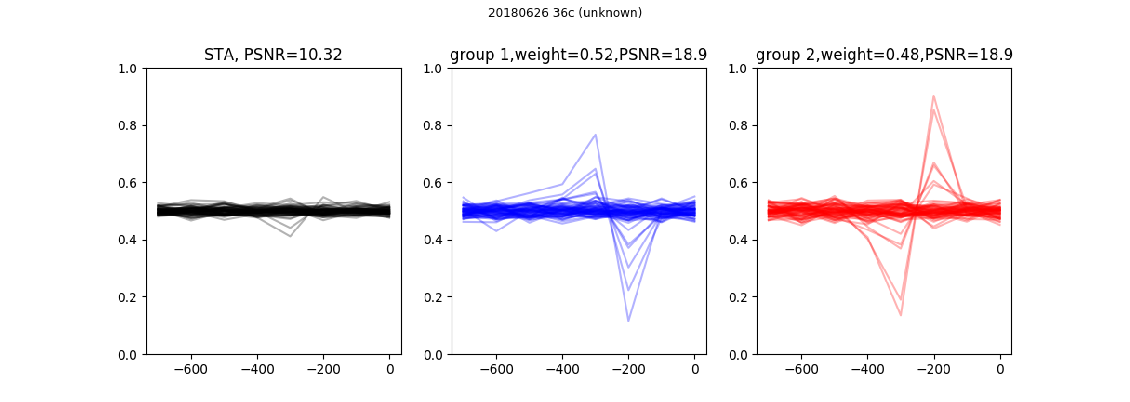

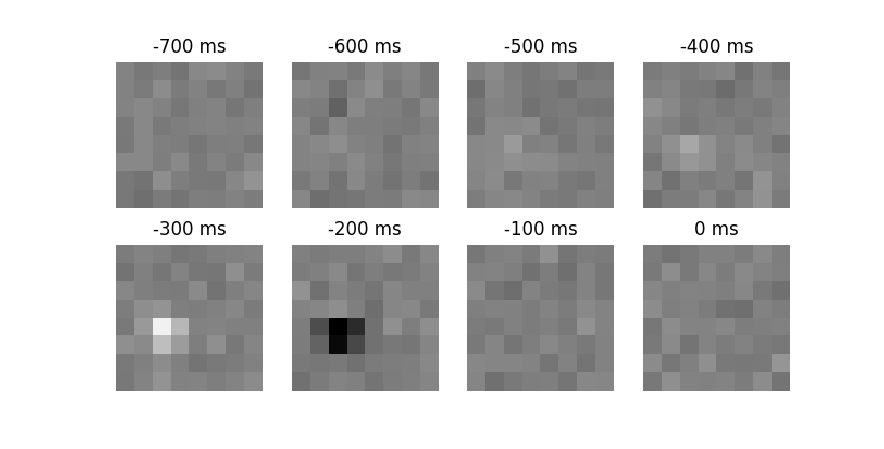

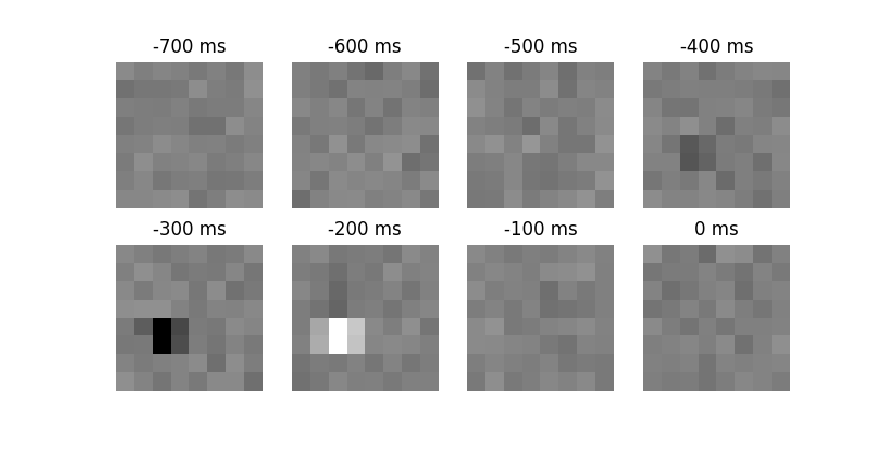

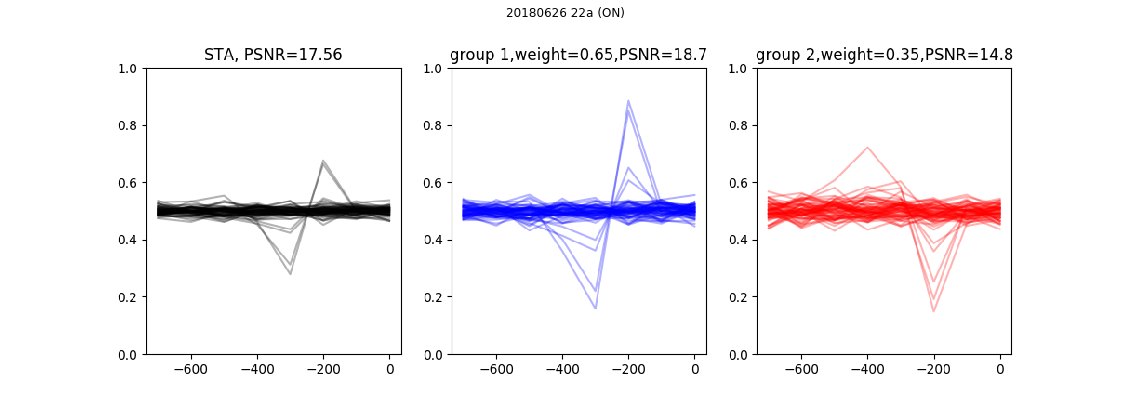

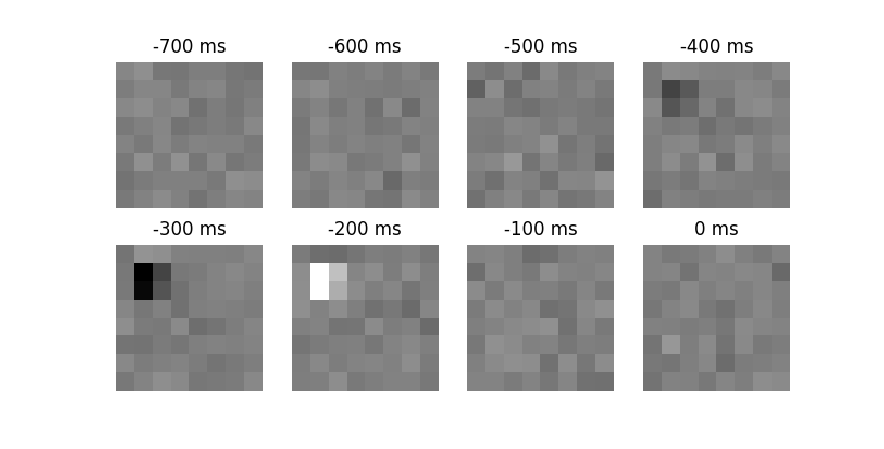

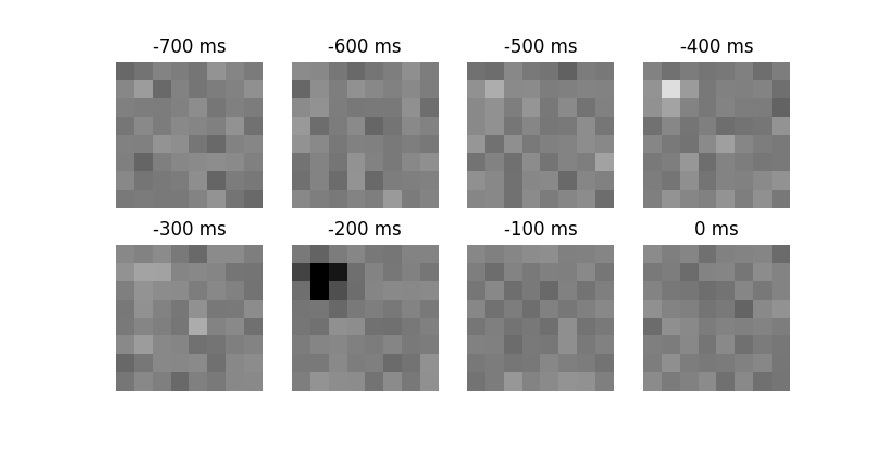

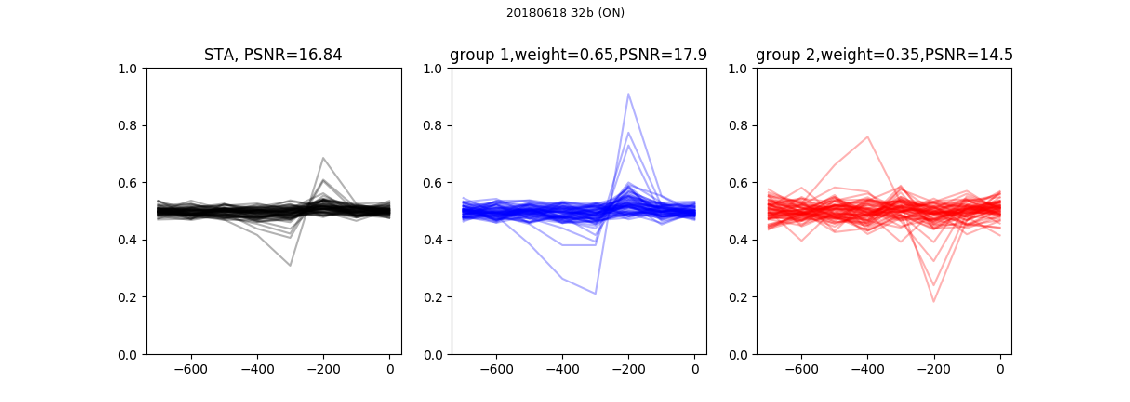

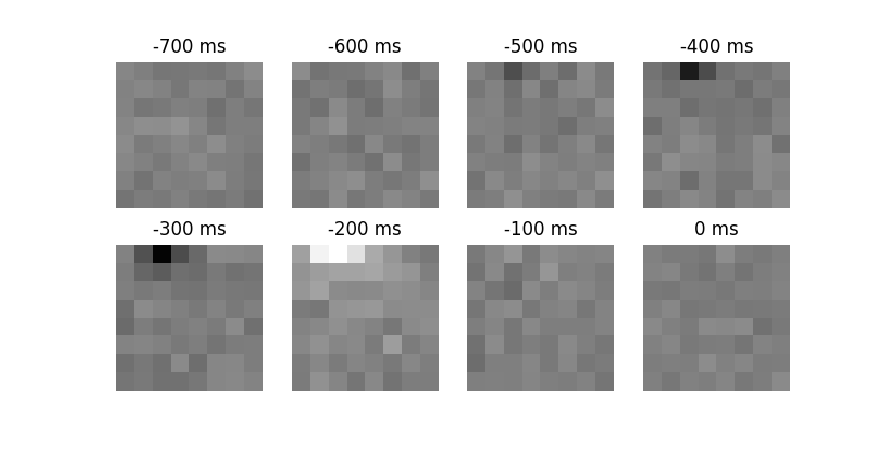

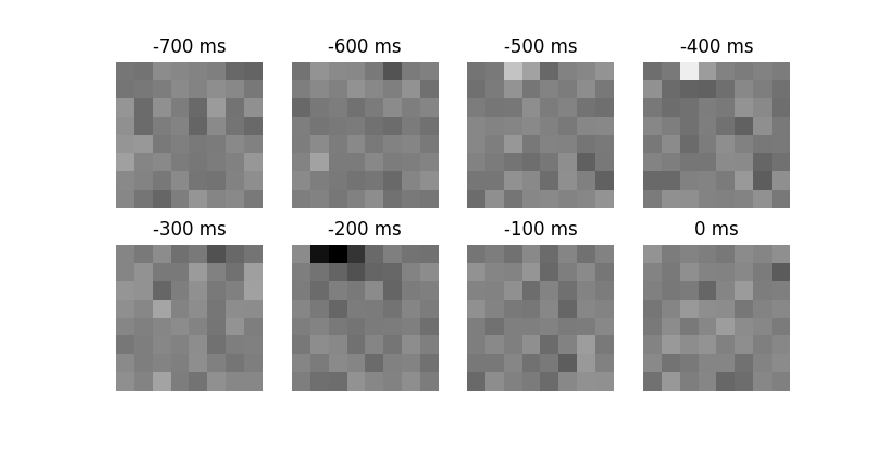

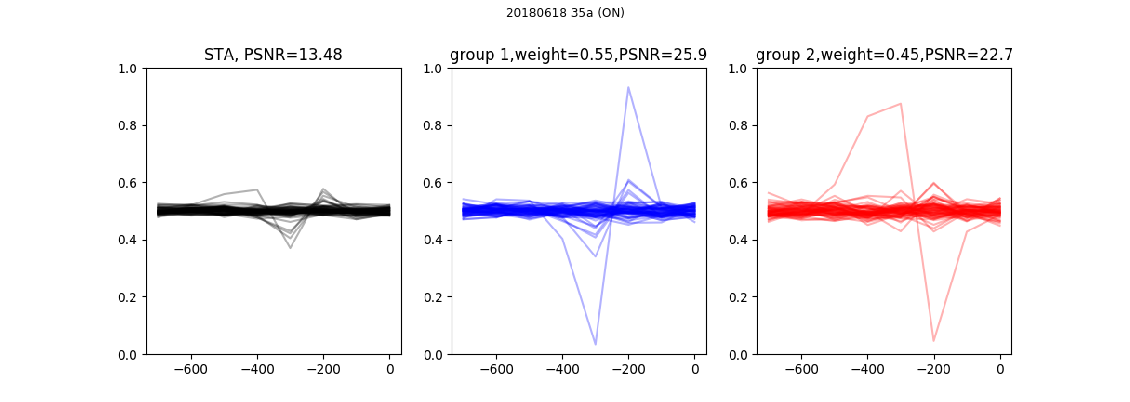

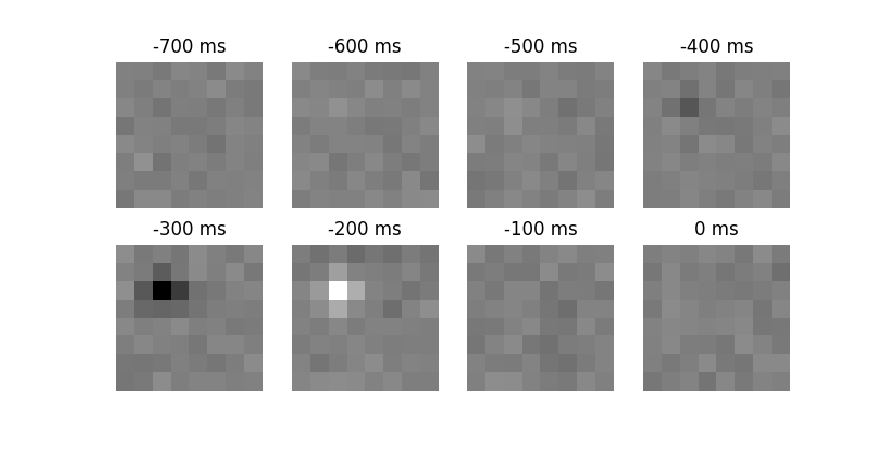

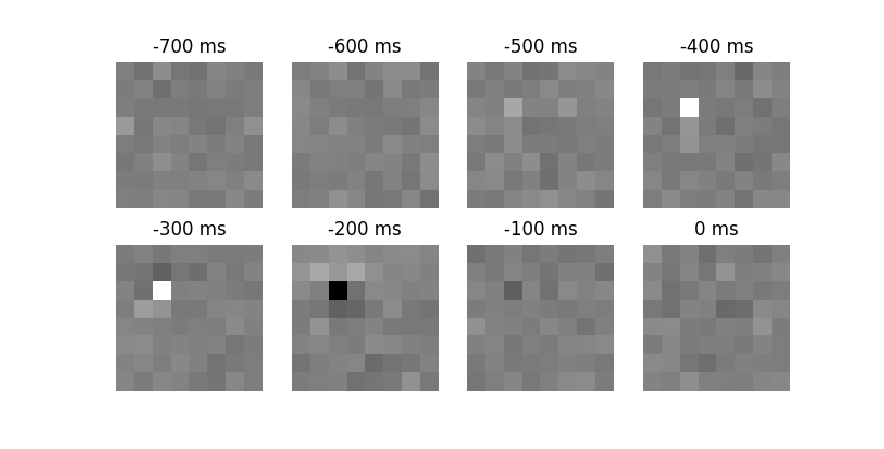

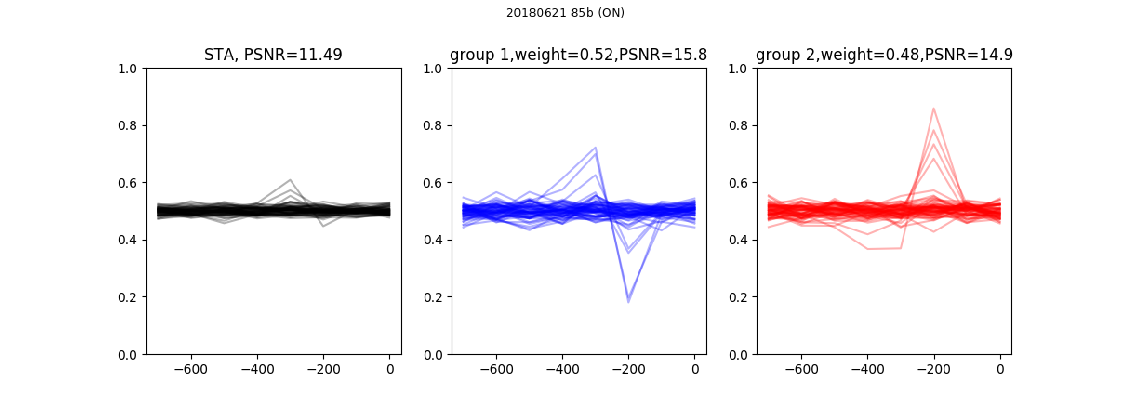

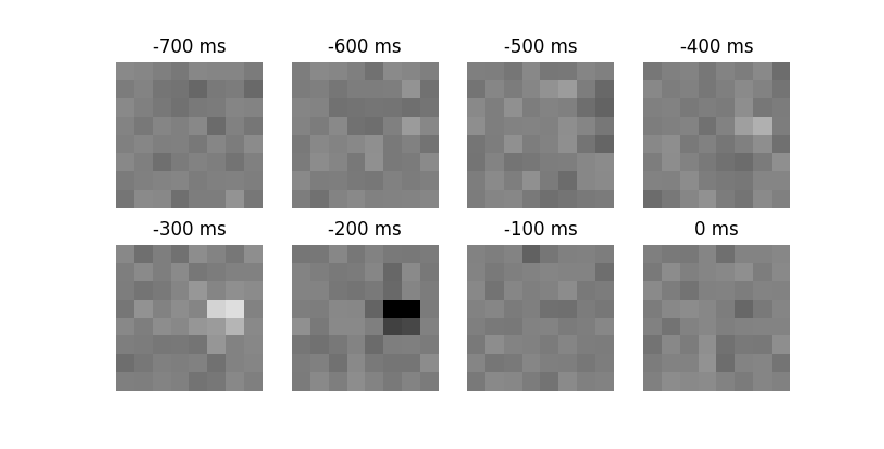

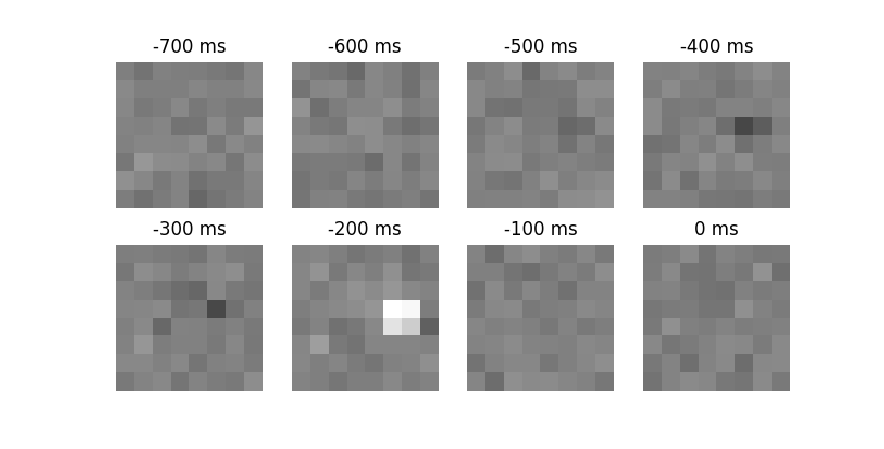

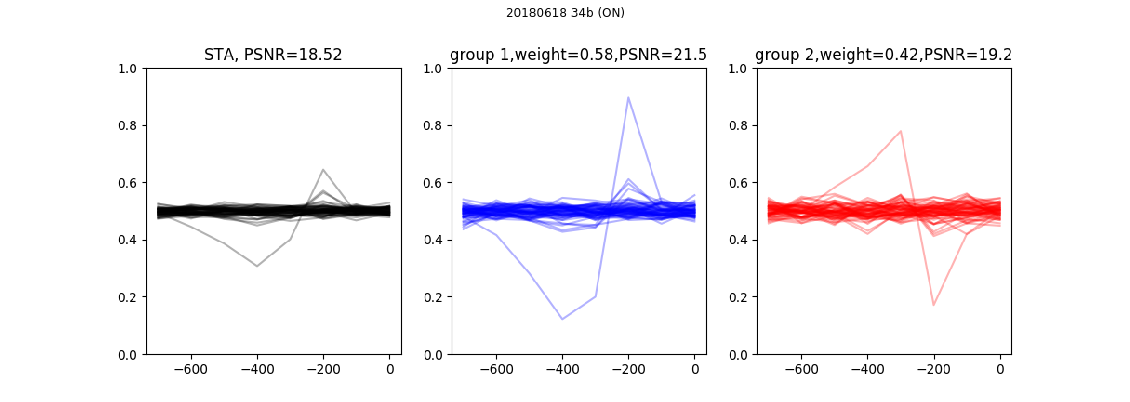

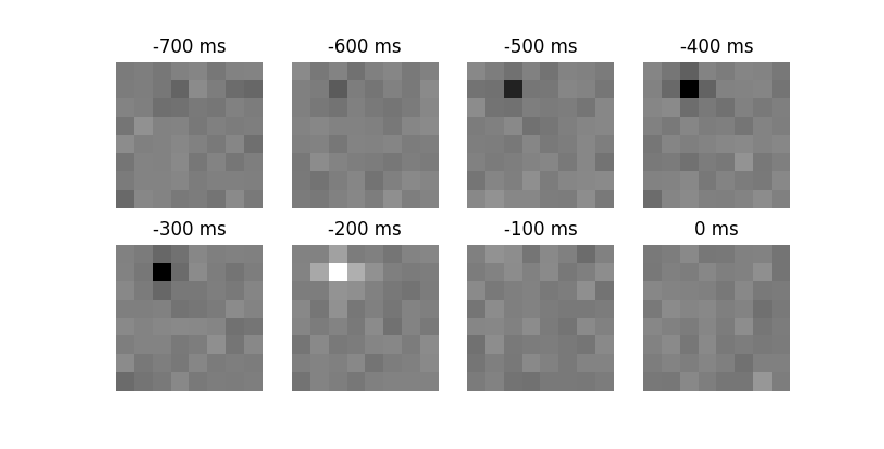

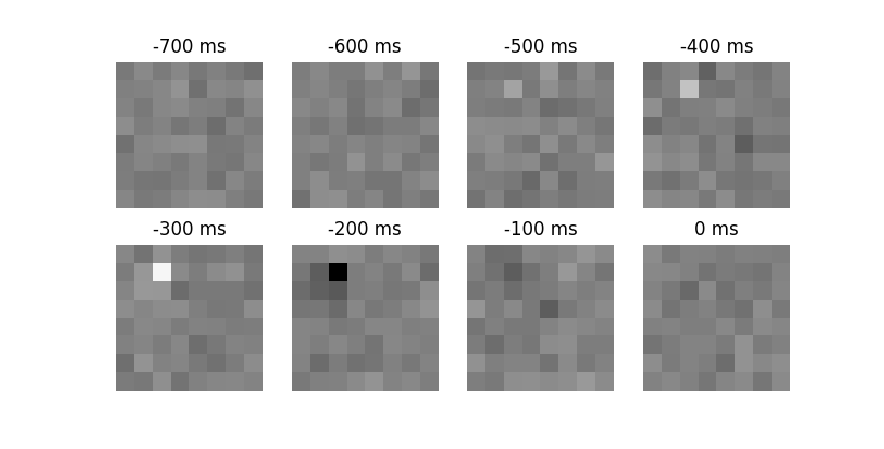

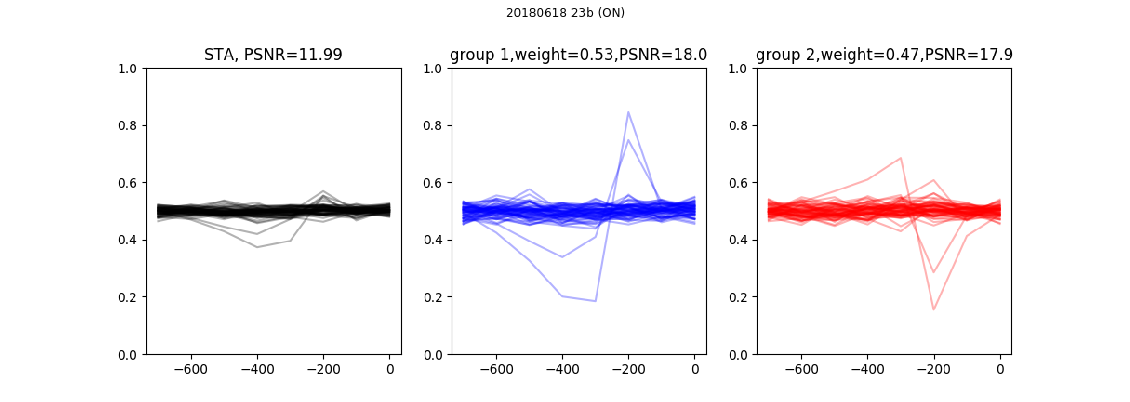

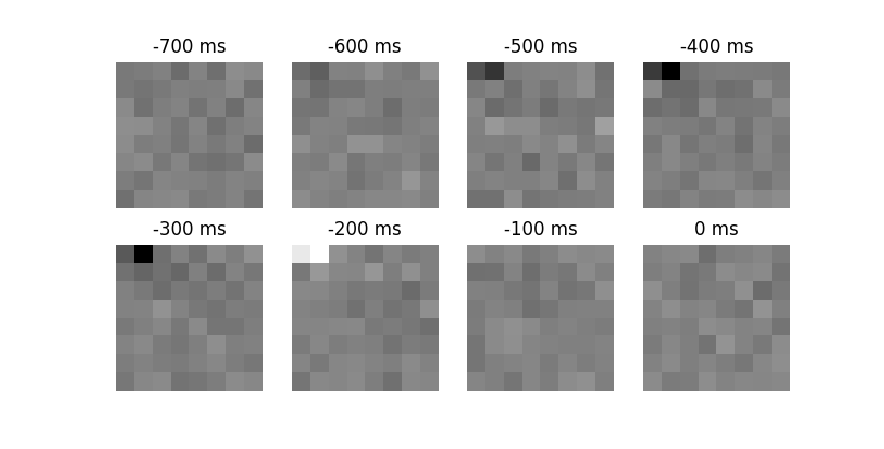

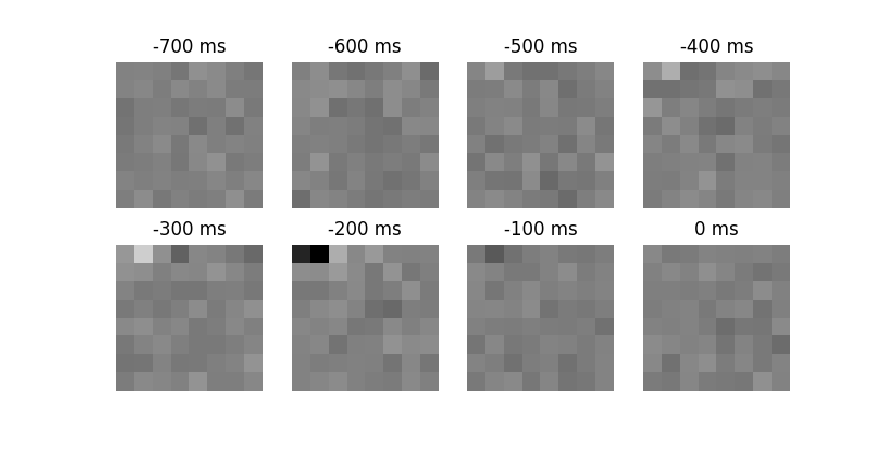

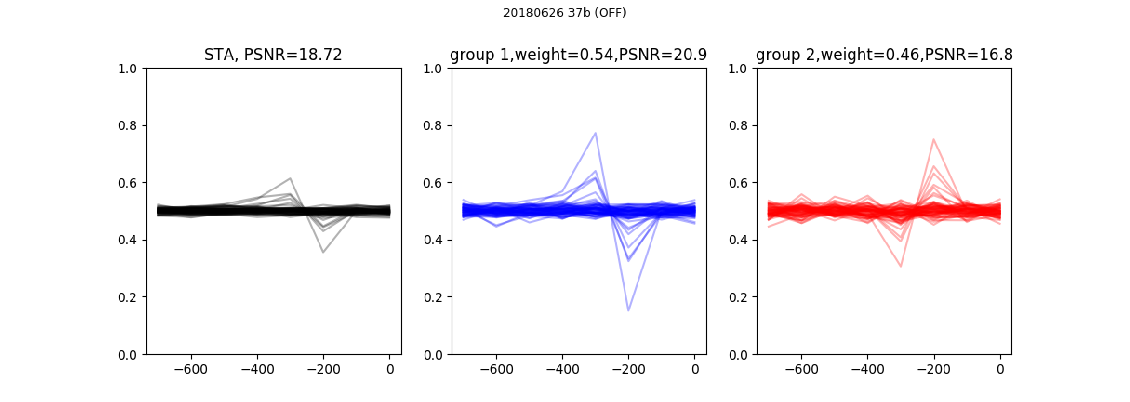

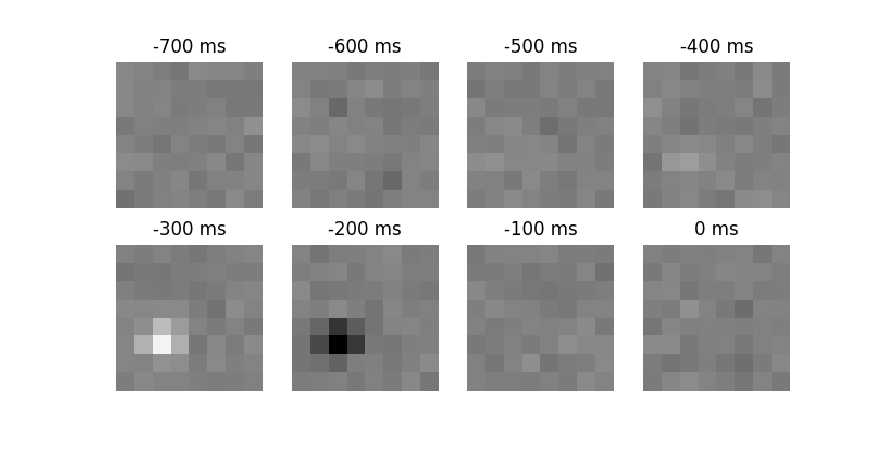

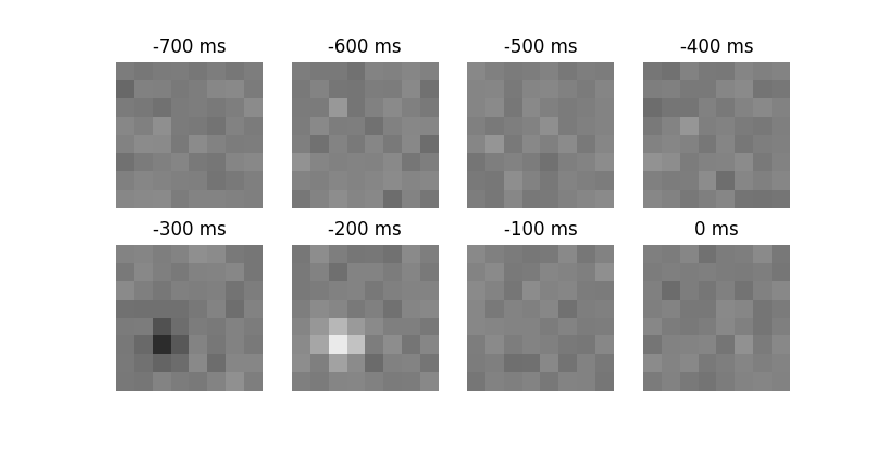

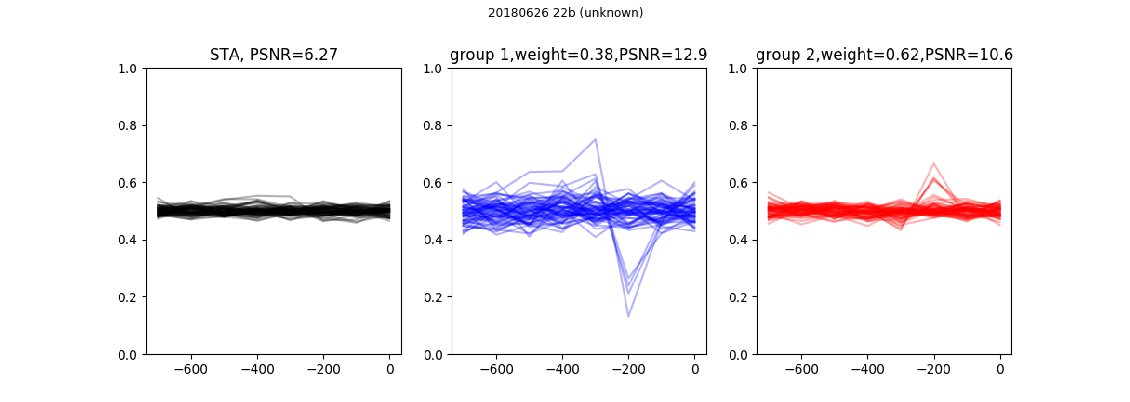

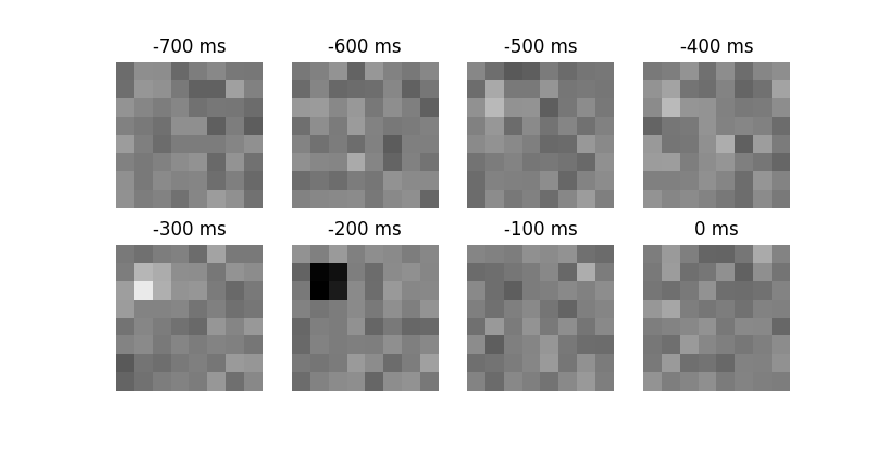

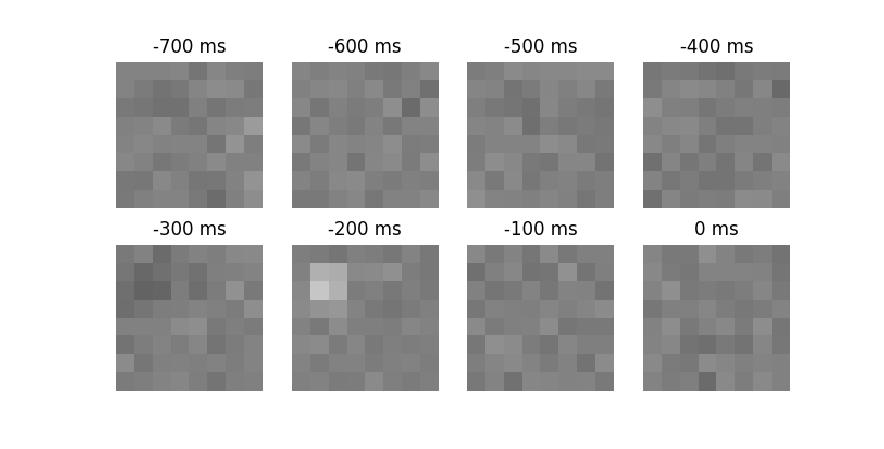

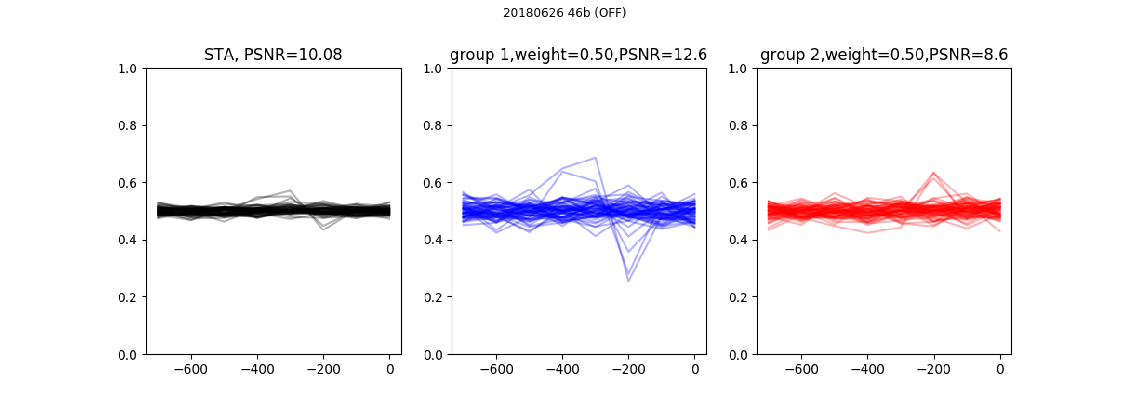

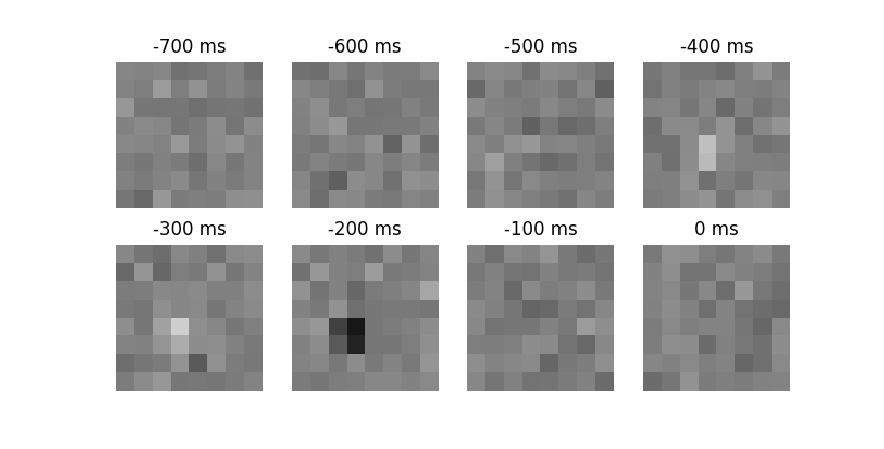

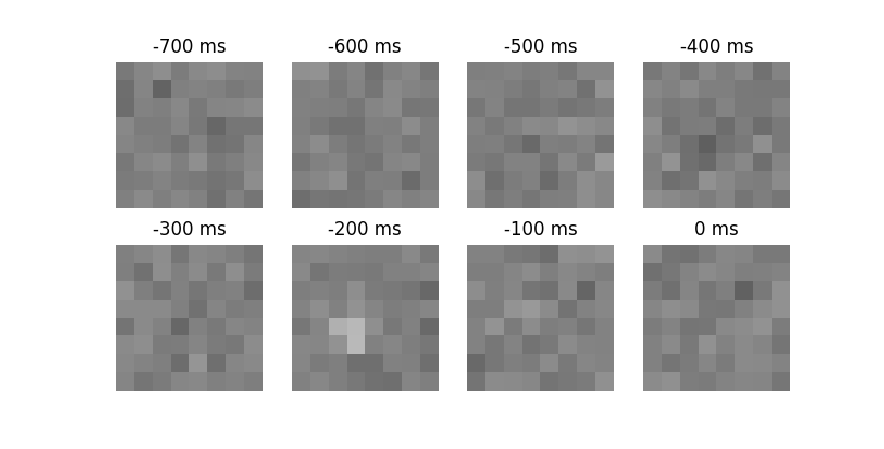

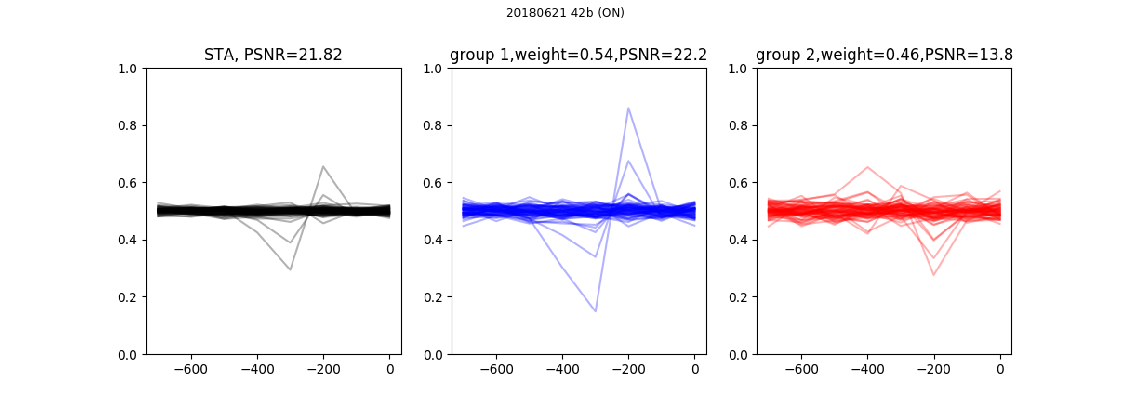

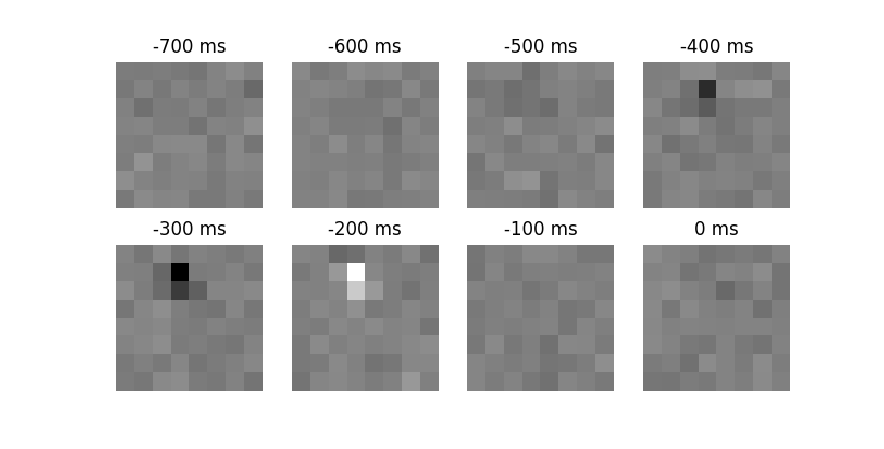

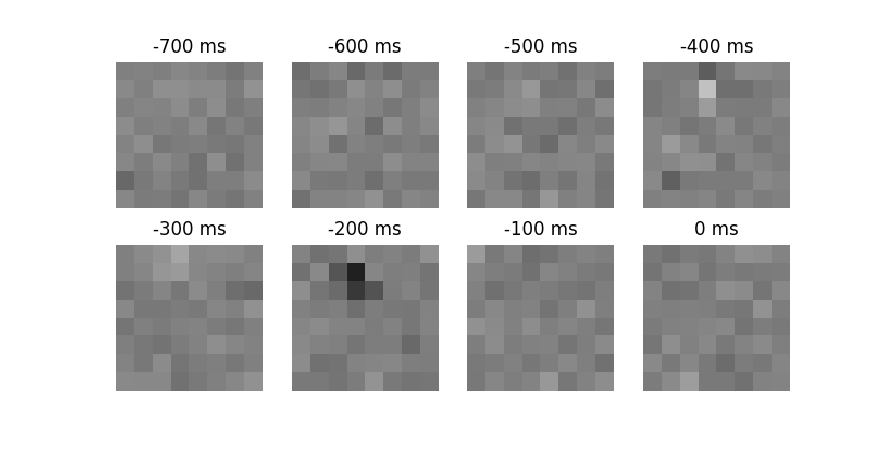

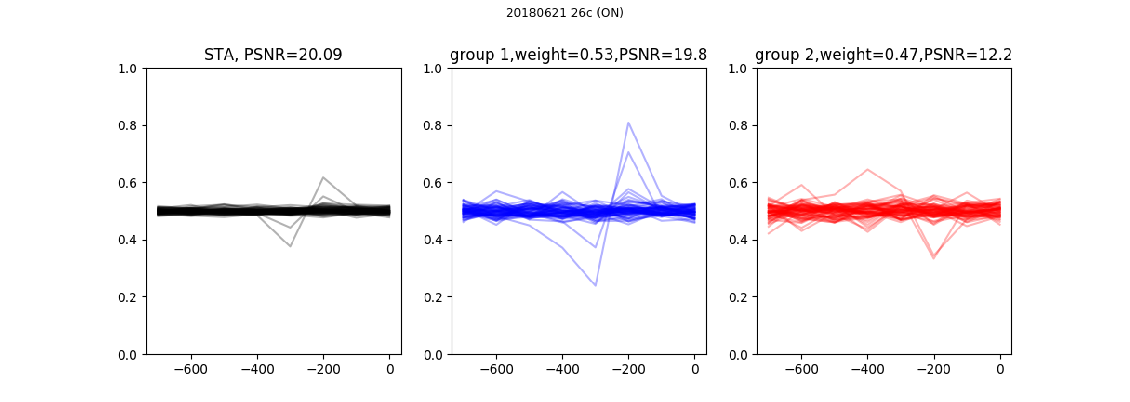

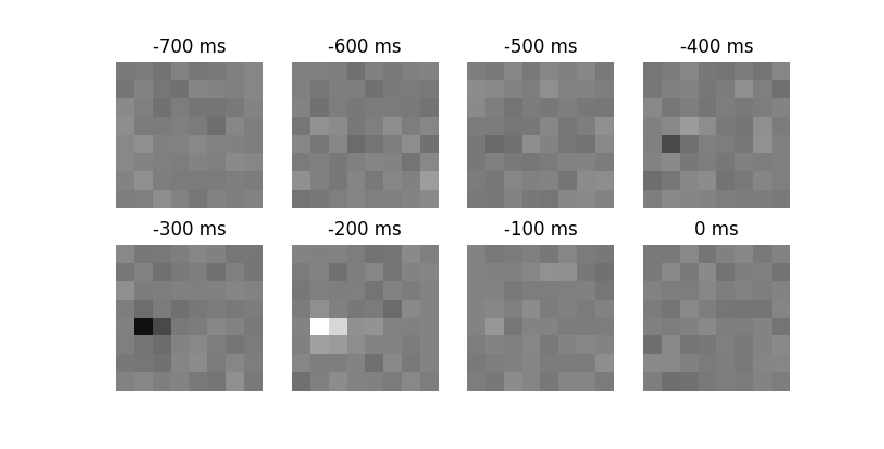

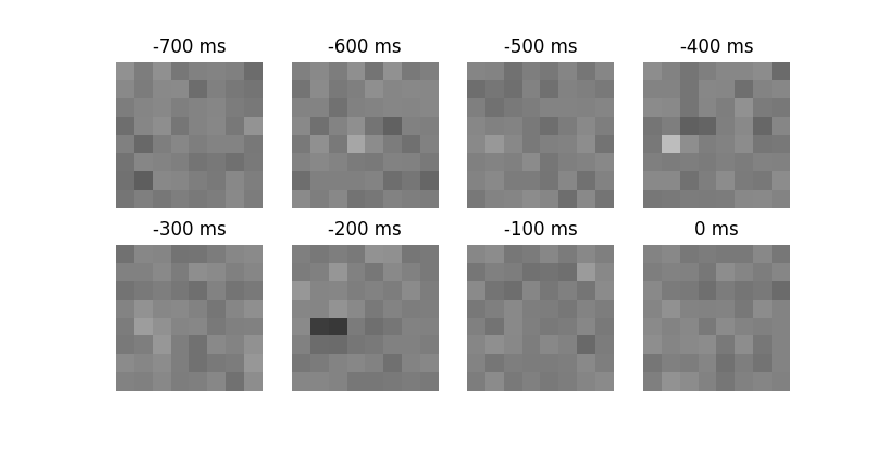

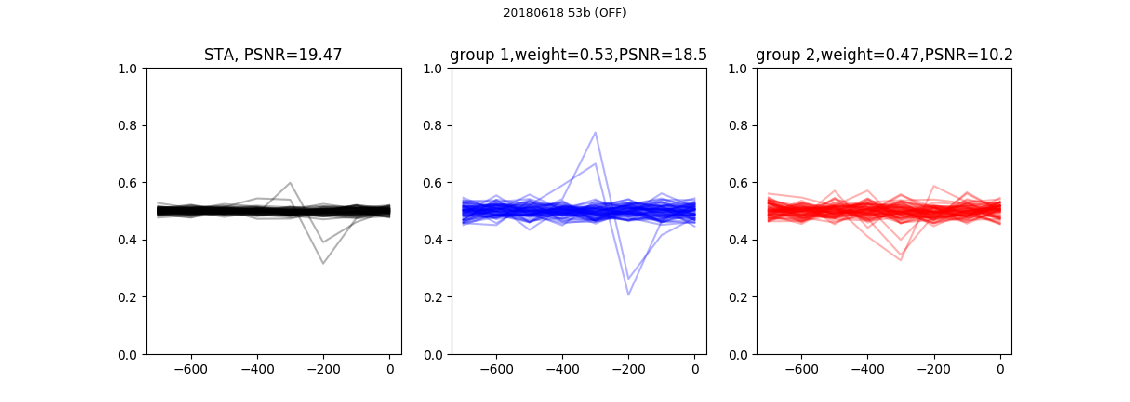

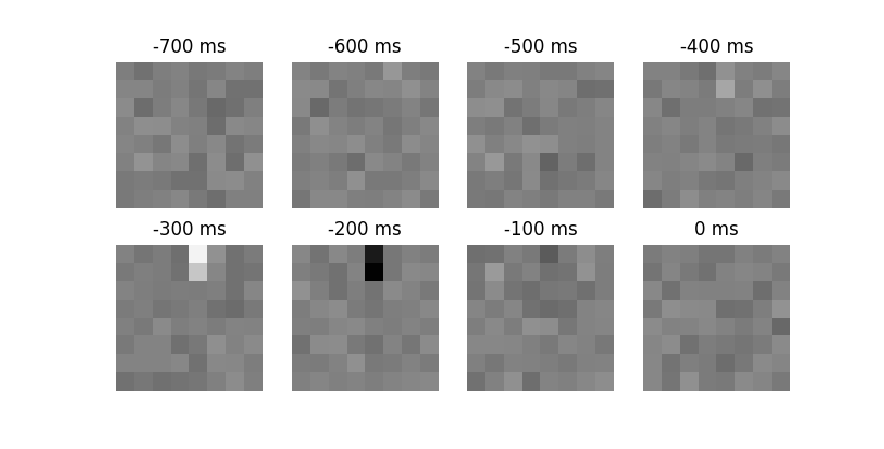

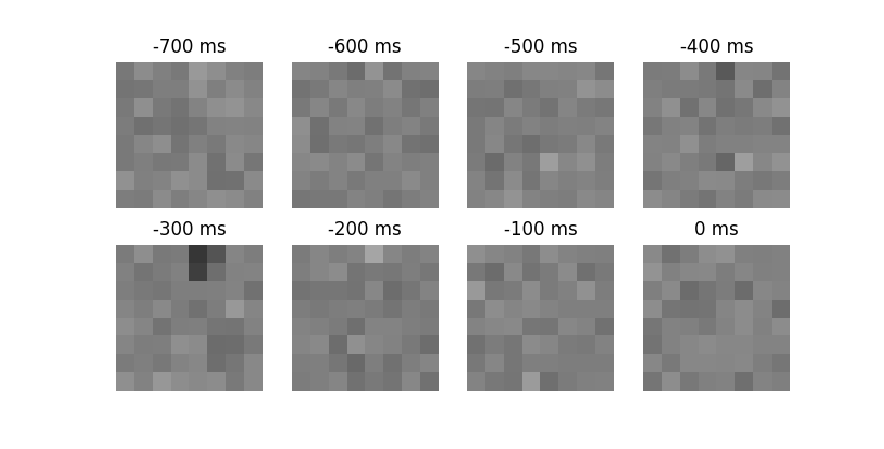

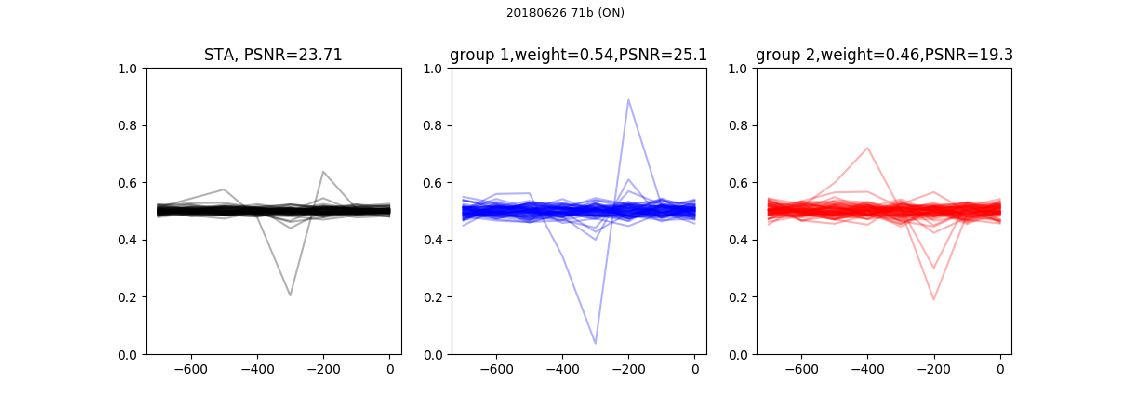

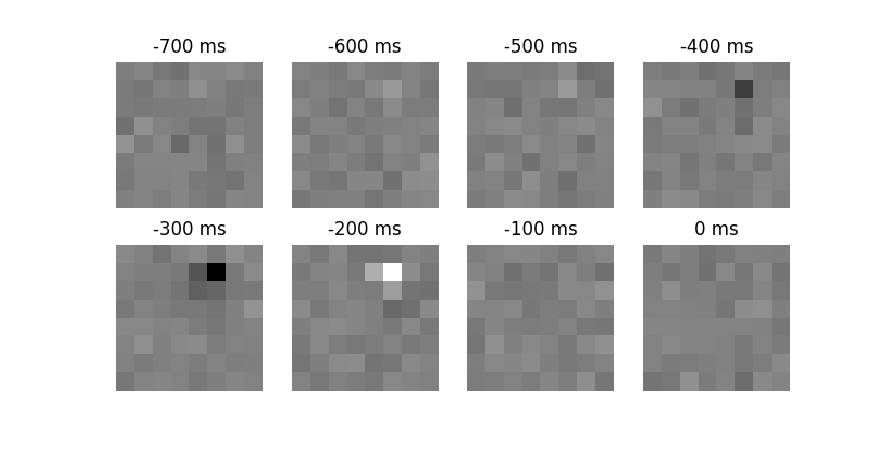

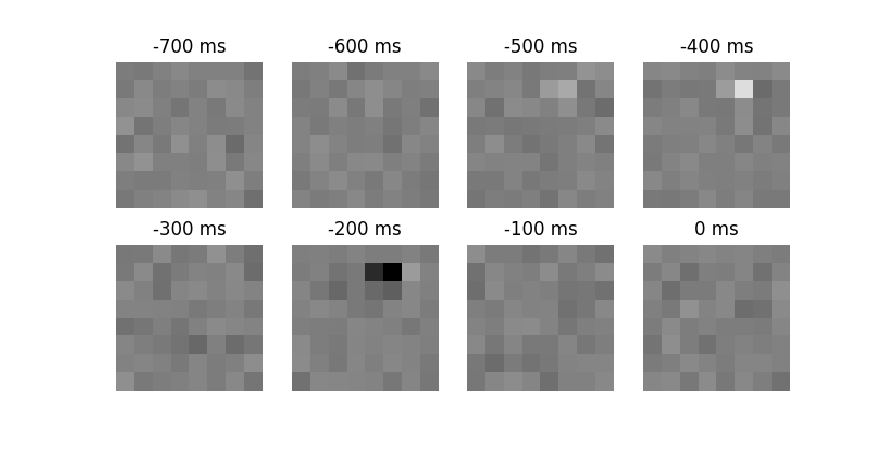

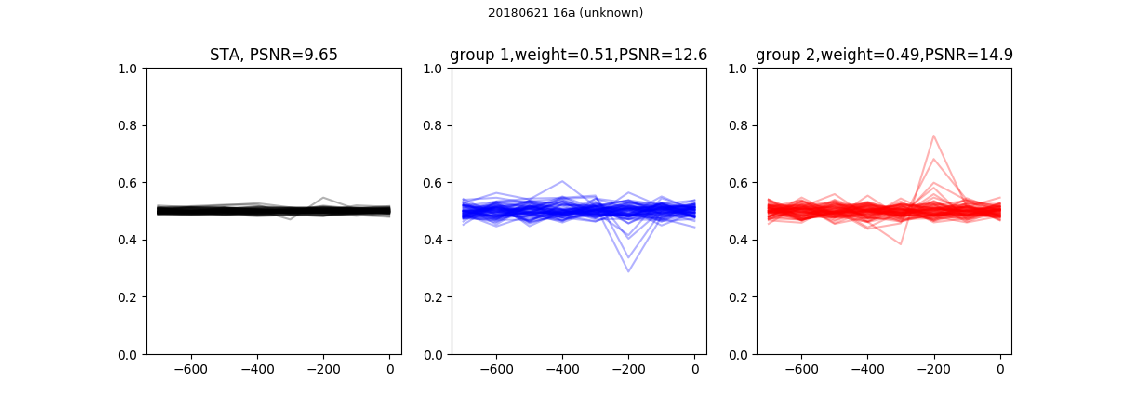

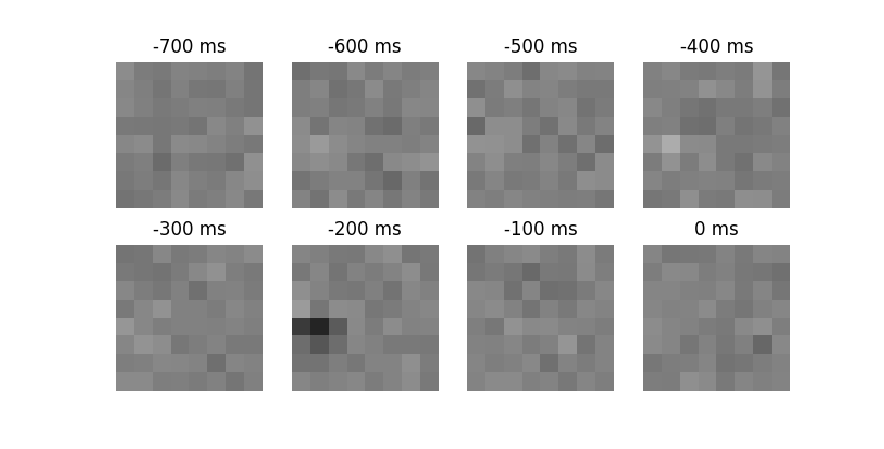

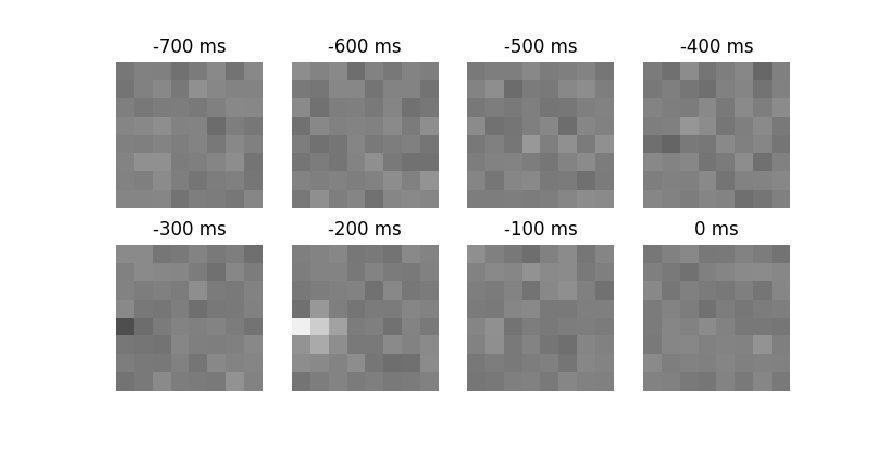

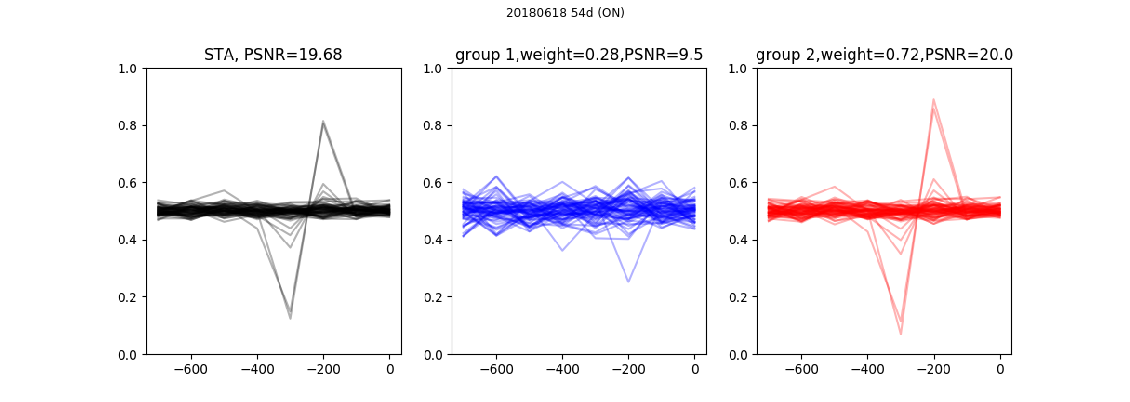

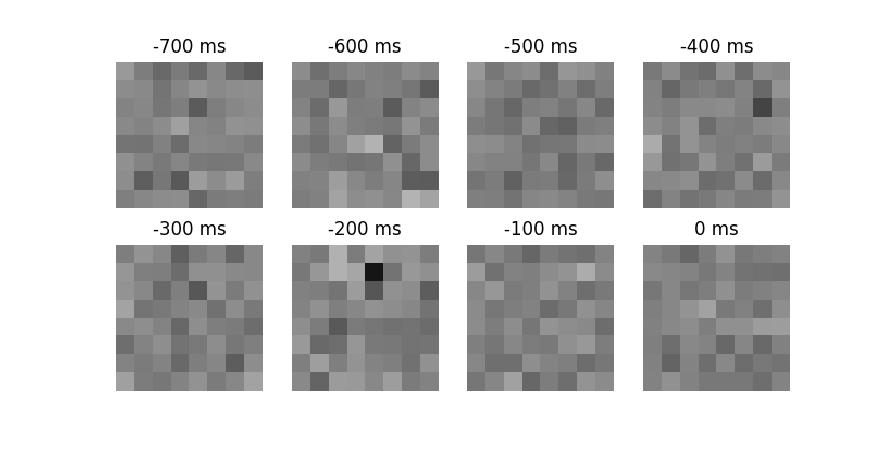

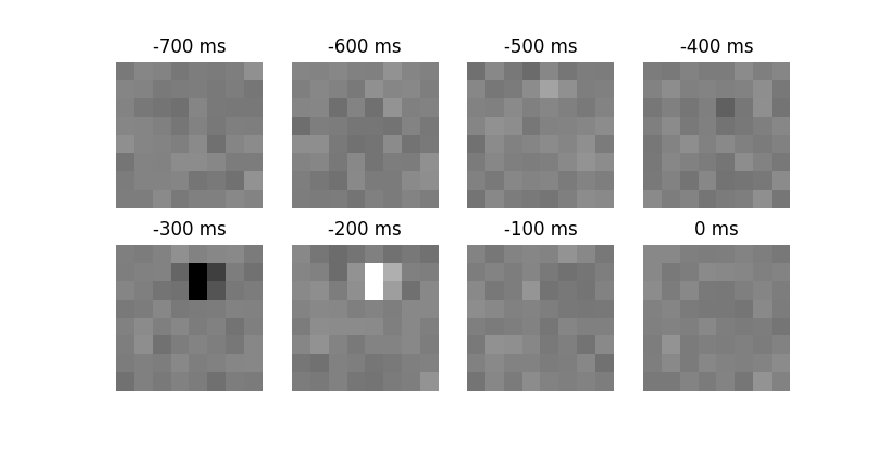

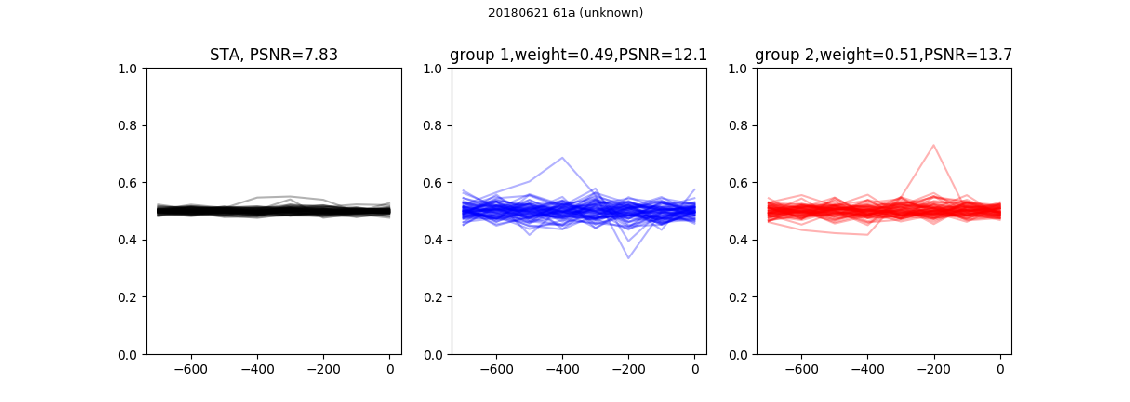

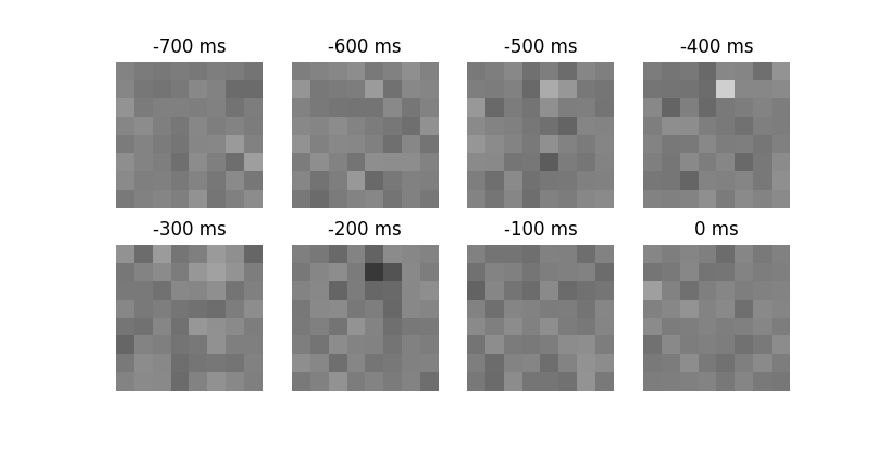

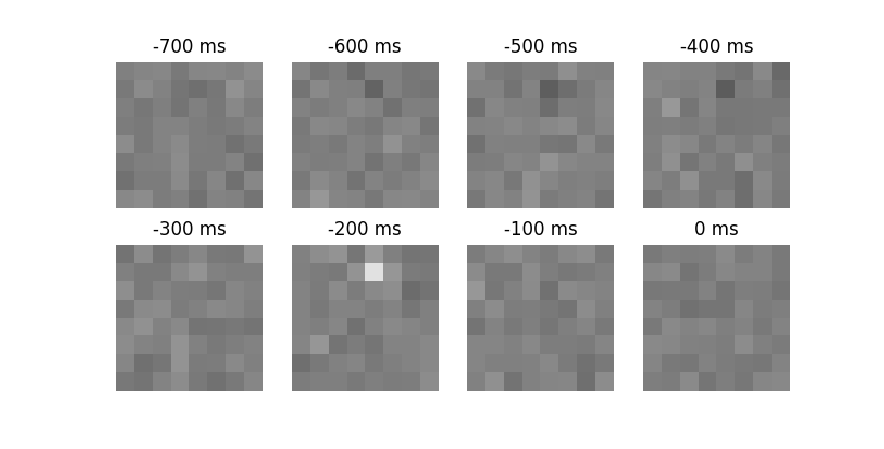

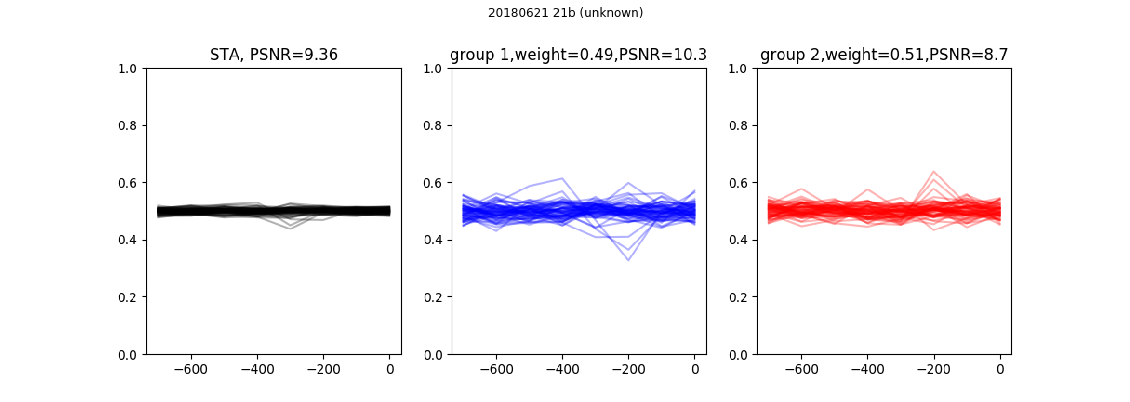

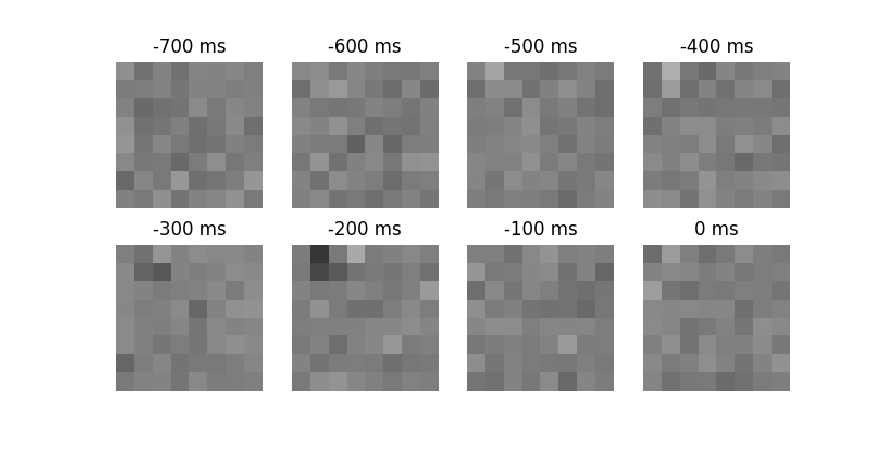

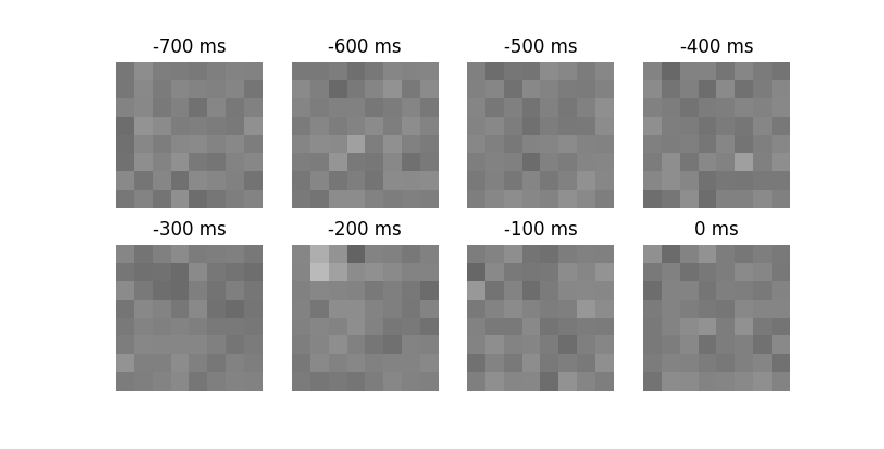

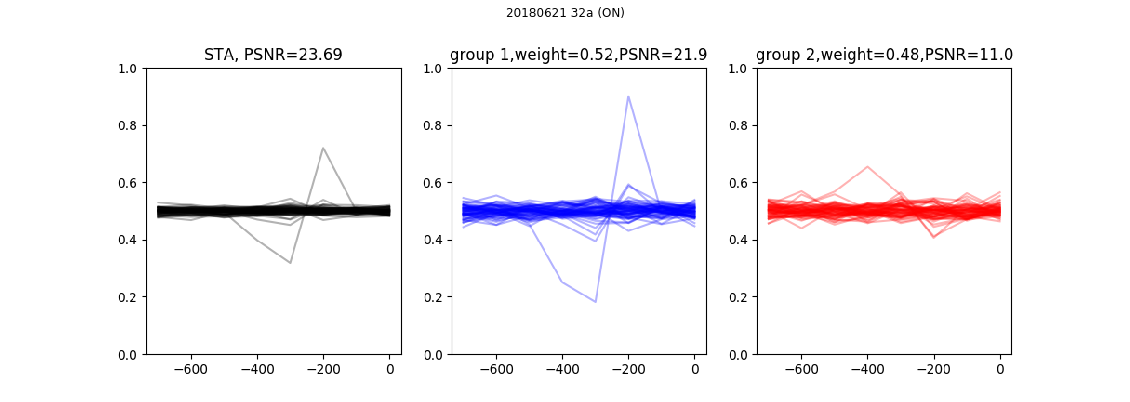

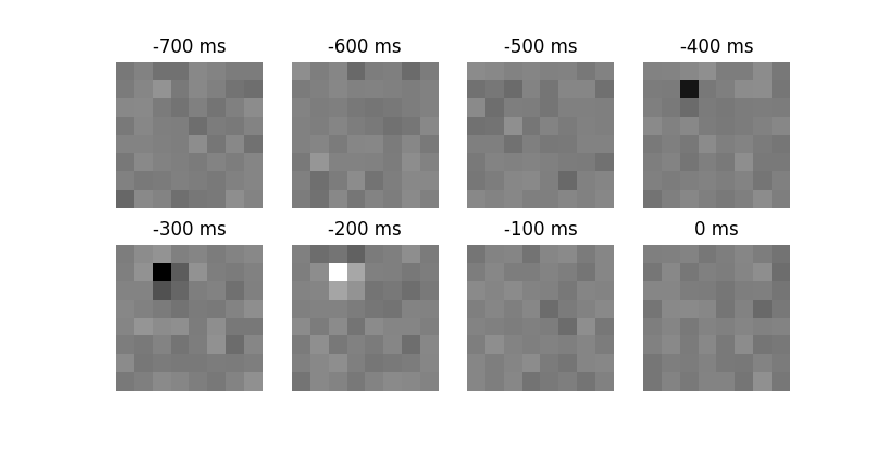

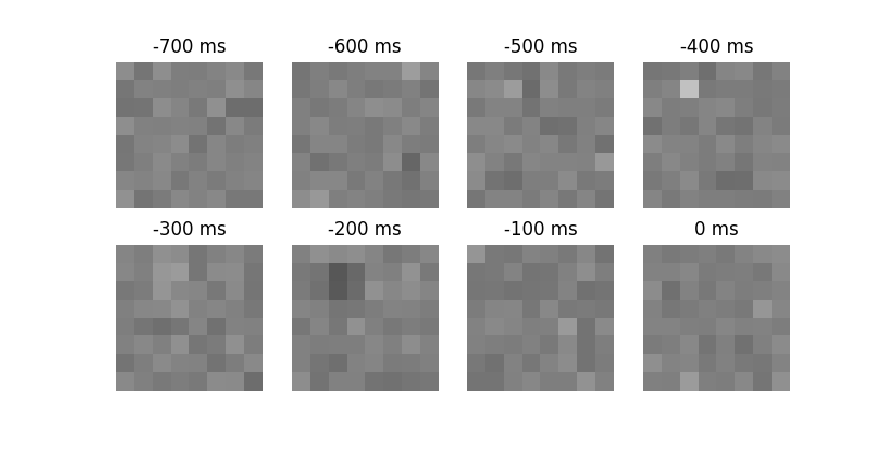

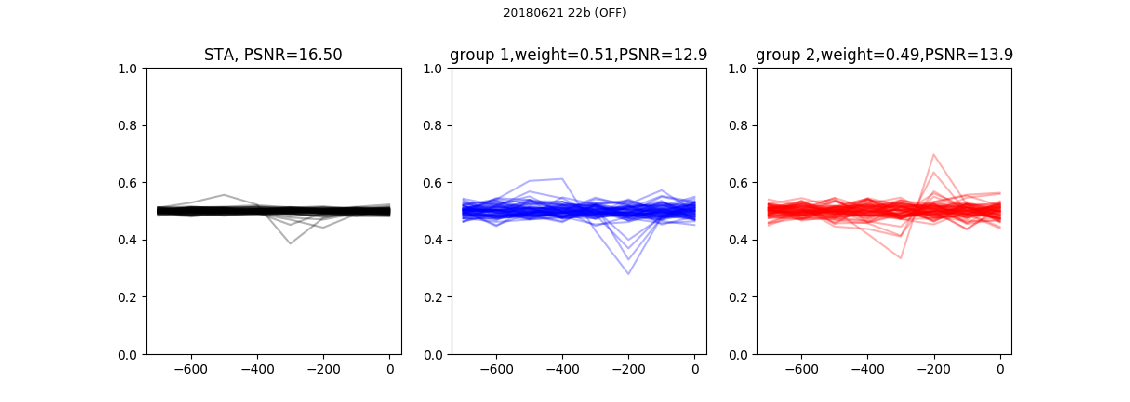

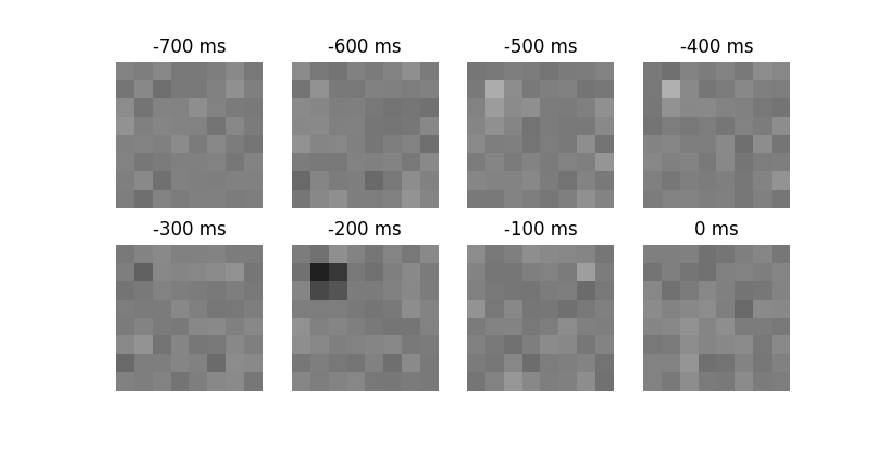

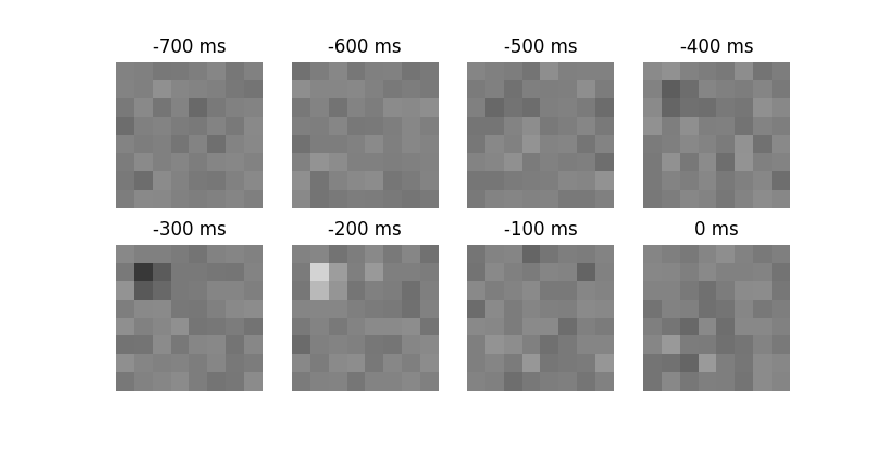

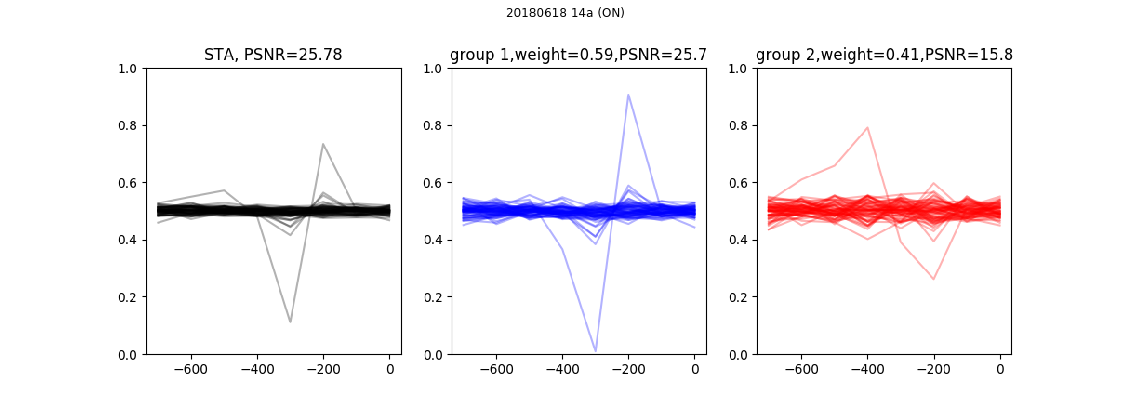

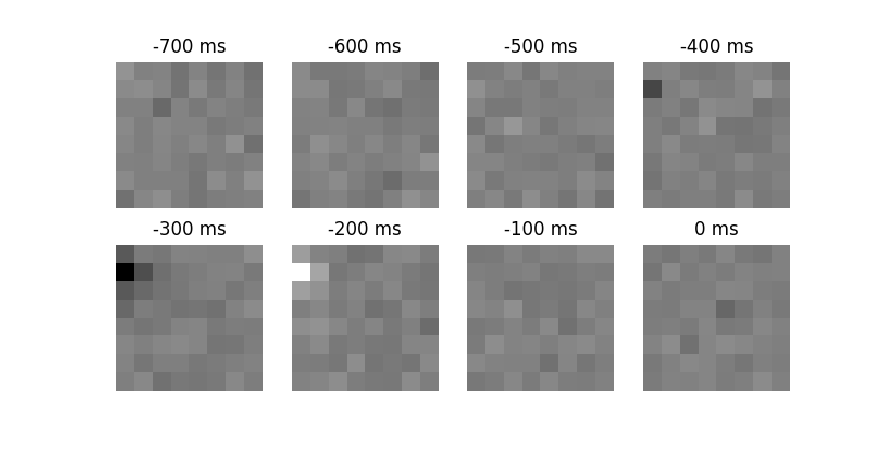

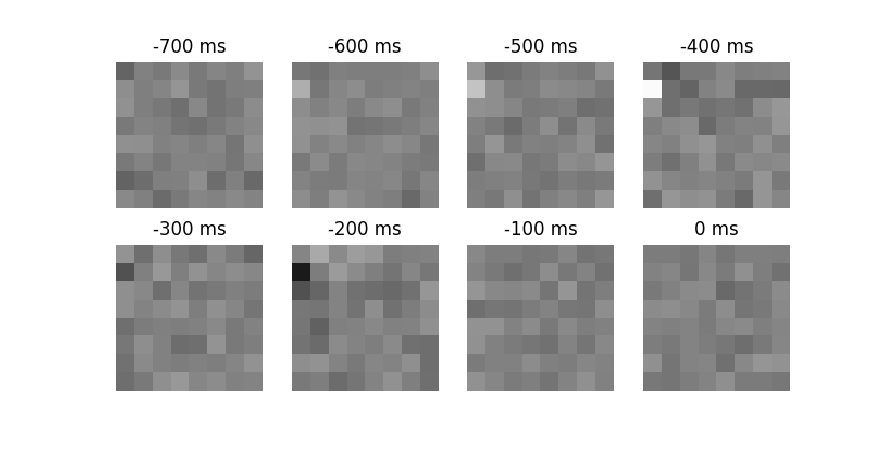

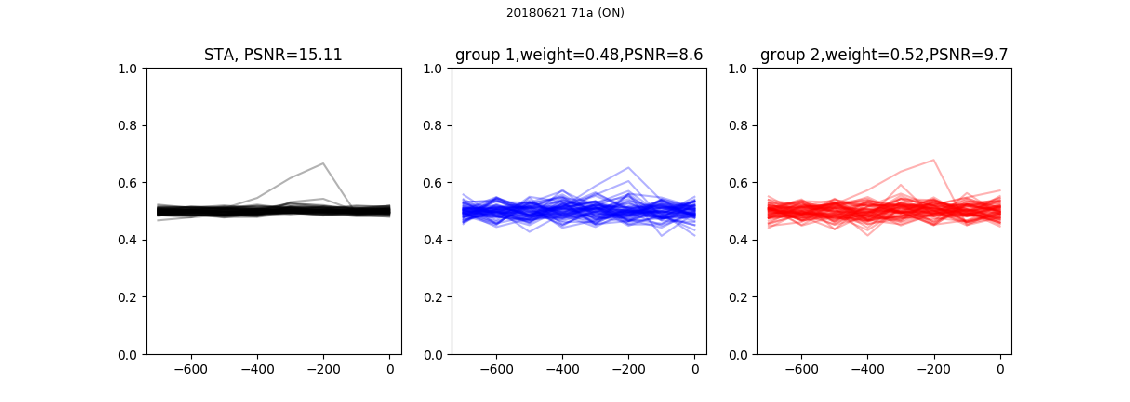

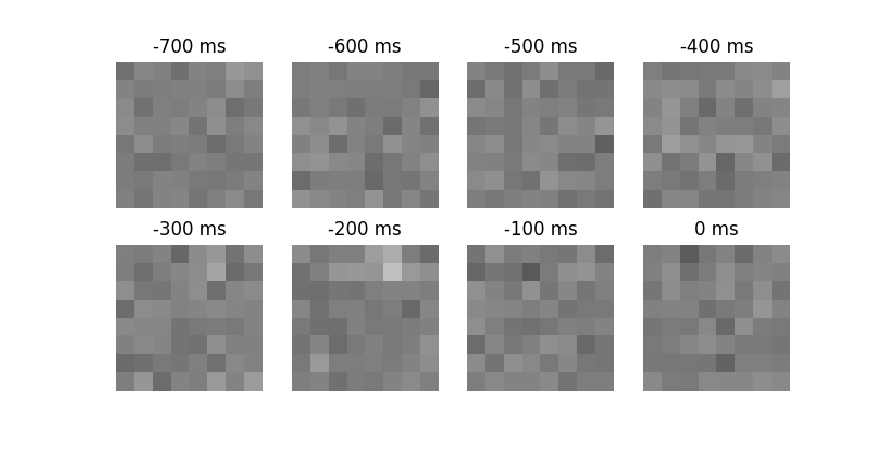

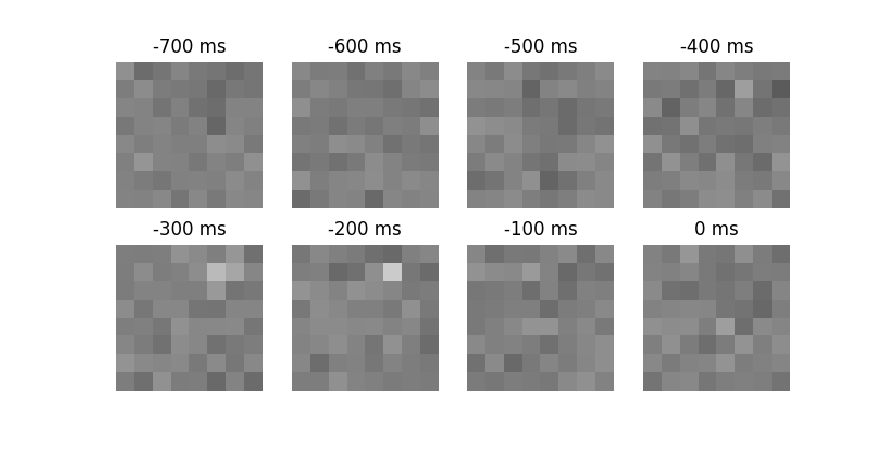

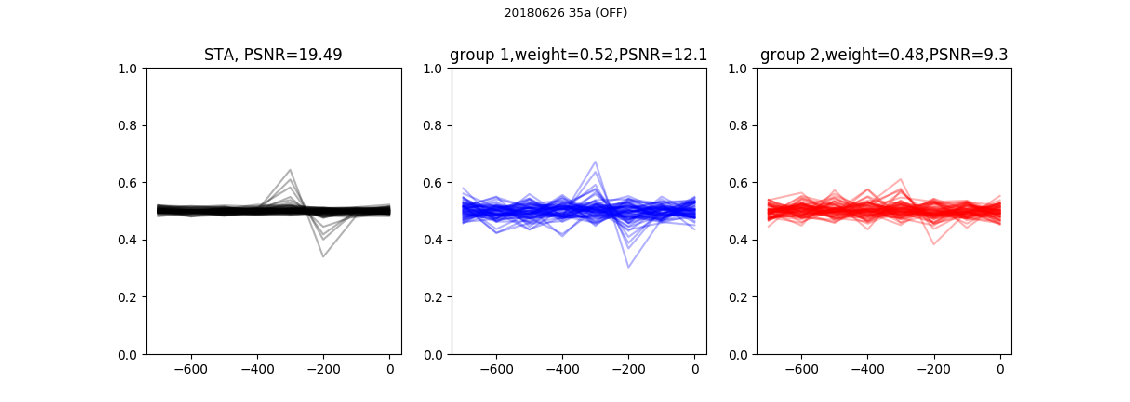

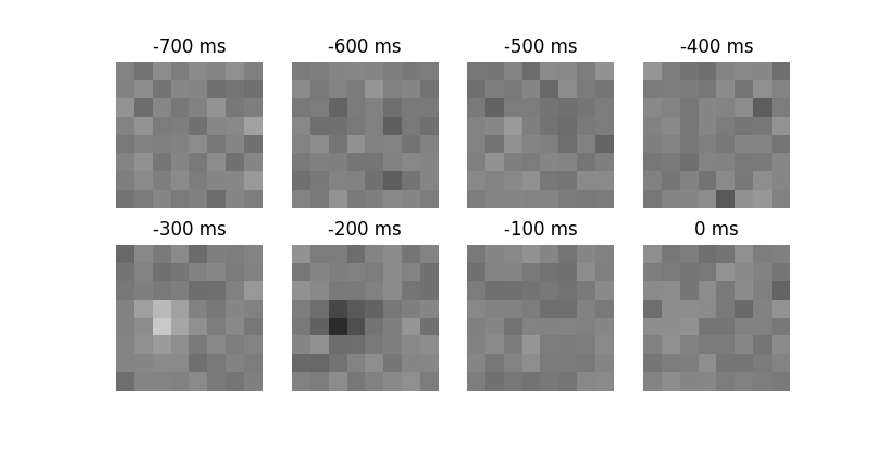

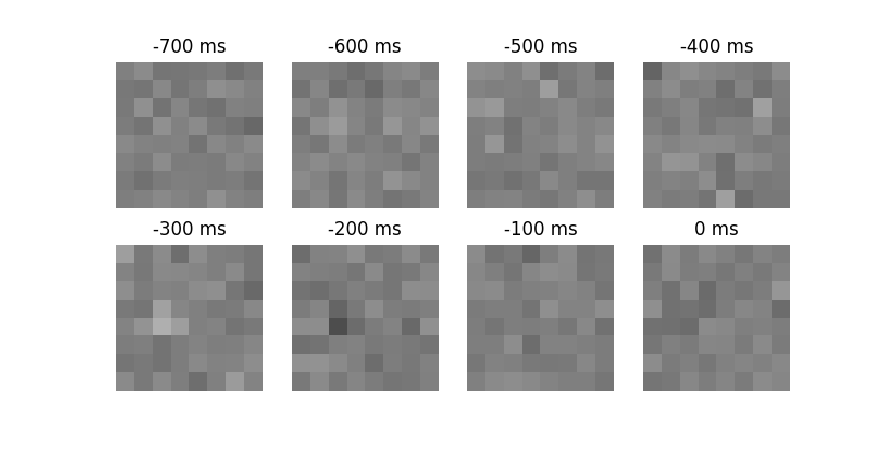

In [39]:
plot_examples(cluster_checked, dim, temporal_profile=True, spatial_profile=[1, 2], filename="combined_cluster_dim{}_spd{}_checked".format(dim,spike_per_dim))

In [40]:
# plt.hist(PSNR1_selected)
# plt.show()
# plt.hist(PSNR2_selected)
# plt.show()
# plt.scatter(PSNR1_selected,PSNR2_selected)
# plt.plot([5,25],[5,25], 'k--')
# plt.xlabel('PSNR1')
# plt.ylabel('PSNR2')
# plt.show()
# plt.scatter(PSNR_selected,PSNR1_selected)
# plt.scatter(PSNR_selected,PSNR2_selected)
# plt.plot([5,25],[5,25], 'k--')
# plt.xlabel('PSNR')
# plt.legend(['','PSNR1', 'PSNR2'])
# plt.show()

23


ON         13
OFF         5
unknown     5
Name: cell_type, dtype: int64

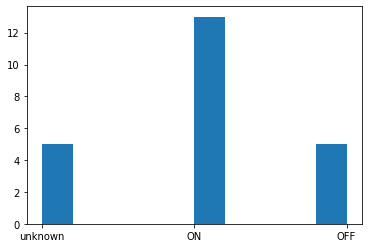

In [41]:

plt.hist(cluster_checked["cell_type"])

print(len(cluster_checked))
cluster_checked["cell_type"].value_counts()

In [42]:
# # sort by inner product and plot

# cluster_sorted_by_eig1 = cluster_with_enough_samples.sort_values('eig1').head(30)#.sort_values("dataset")

# plot_examples(cluster_sorted_by_eig1, "cluster_eig", dim=dim)


